# Example of how to fit spectra using species 

This tutorial shows how to use ```fitspec``` which uses the ```species``` package to fit NIR low resolution spectra.  We will use a NIR spectra (0.9-2.5μm) from SOAR/TripleSpec of the brown dwarf 2MASS J11011926-7732383. The data are currently published in Betti (2023) https://ui.adsabs.harvard.edu/abs/2023PhDT........13B/abstract 


The main functionality of ```fitspec```: 
- fit empirical spectra
- fit models
- calculate uncertainties on best fit models 

## Getting started

First download and install ```species``` from https://species.readthedocs.io/en/latest/installation.html if you do not have it downloaded.  You must also have ```pymultinest``` installed: https://johannesbuchner.github.io/PyMultiNest/install.html#building-the-libraries

First import Python modules. You should set your ```DYLD_LIBRARY_PATH``` following the ```species``` installation instructions.

written by: Sarah Betti 6-2025

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from astropy import units as u
from scipy.stats import binned_statistic
from astropy.io import fits

import os
# CHANGE PATH TO POINT TO YOUR pyMULTINEST installation! 
os.environ['DYLD_LIBRARY_PATH'] = '/Users/sbetti/data/MultiNest/lib'

import bdfit

Determine the path to your spectra and the object name.  The spectra can be in any format because we are going to re-save it in a simple ```.dat``` file.

In [2]:
DATADIR =  '2MASS J11011926-7732383.fits'
OBJ_NAME = '2MASS J11011926-7732383'


Here, we read the FITS file with ```astropy```.  For simplicity, we bin our data to R~500 and extract the full spectra and the spectra up to 1.9μm.  We only want the real values for fitting (no ```NaN```s or ```INF```s)

The data needs to be saved in the format ```{OBJ_NAME}_R{resolution}_short.dat``` (optional) for a sliced spectra and ```{OBJ_NAME}_R{resolution}_full.dat``` (required) for the full spectra.

In [3]:
a = fits.getdata(DATADIR)
wave = a[0]
flux = a[1]
noise = a[2]

binwave = np.arange(wave.min(), wave.max(), 0.005)
FLUX = binned_statistic(wave, flux, statistic='mean', bins=binwave)[0]
NOISE = binned_statistic(wave, flux, statistic='std', bins=binwave)[0]
WAVE = binwave[0:-1]
# only extract real values
idx = np.where(np.isfinite(FLUX))
idx2 = np.where(np.isfinite(FLUX) & (WAVE < 1.9))
np.savetxt(f'{OBJ_NAME}_R500_short.dat', np.c_[WAVE[idx2], FLUX[idx2], NOISE[idx2]])
np.savetxt(f'{OBJ_NAME}_R500_full.dat', np.c_[WAVE[idx], FLUX[idx], NOISE[idx]])

We now determine the parallax.  This is necessary for proper fitting of the object radius. We show a couple of different ways to get this value:
1. using astroquery.simbad
2. using CASPAR (Betti+2023) 
     - CASPAR (Comprehensive Archive of Substelalr and Planetary Accretion Rates) is an archive of accretion and stellar properties for accreting objects.
     
Method using simbad

In [4]:
from astroquery.simbad import Simbad
simbad = Simbad()
simbad.add_votable_fields("parallax")
result_table = simbad.query_object(OBJ_NAME)

PARALLAX = result_table['PLX_VALUE'][0]
PARALLAX_err = result_table['PLX_ERROR'][0]
print(PARALLAX, PARALLAX_err)
result_table[['MAIN_ID', 'PLX_VALUE', 'PLX_ERROR']]

-- --


MAIN_ID,PLX_VALUE,PLX_ERROR
,mas,mas
object,float64,float32
2MASS J11011926-7732383,--,--


Method using CASPAR.  
first download the CASPAR google sheet if you do not already have it. 

In [5]:
import gdown
url = 'https://drive.google.com/uc?id=1QbJHcrndhaP2JIrBazy4zcUULpgClCdt76nMilKfRNs'
output = "caspar.xlsx"
gdown.download(url, output)

Downloading...
From (original): https://drive.google.com/uc?id=1QbJHcrndhaP2JIrBazy4zcUULpgClCdt76nMilKfRNs
From (redirected): https://docs.google.com/spreadsheets/d/1QbJHcrndhaP2JIrBazy4zcUULpgClCdt76nMilKfRNs/export?format=xlsx
To: /Users/sbetti/Documents/Science/NIRAccretion/TSpec/bdfit/caspar.xlsx
3.99MB [00:00, 25.6MB/s]


'caspar.xlsx'

In [6]:
caspar = pd.read_excel('caspar.xlsx', sheet_name='Literature Database', skiprows=[1])
caspar['Mass jup'] = (np.array(caspar['Mass'].values)*u.Msun).to(u.Mjup).value
caspar['Radius jup'] = (np.array(caspar['Radius'].values)*u.Rsun).to(u.Rjup).value
caspar_obj = caspar[['Reference Name','GAIA EDR3 Parallax', 'GAIA EDR3 Parallax err', 'A_V', 'Teff', 'Mass','Mass jup', 'Radius jup']].loc[caspar['Reference Name']==OBJ_NAME]


PARALLAX = caspar_obj['GAIA EDR3 Parallax'].values[0]
PARALLAX_err = caspar_obj['GAIA EDR3 Parallax err'].values[0]

print(PARALLAX, PARALLAX_err)
caspar_obj

5.3603 0.149


,Reference Name,GAIA EDR3 Parallax,GAIA EDR3 Parallax err,A_V,Teff,Mass,Mass jup,Radius jup
204,2MASS J11011926-7732383,5.3603,0.149,1.59,2838.0,0.05,52.378276,5.741384


## Using ```fitspec```

We are going to use our R~500 spectra and find the best fit parameters that describe our spectra.  We will create an instance of ```fitspec``` by providing the OBJ_NAME, PARALLAX, PARALLAX_err, spectral resolution (spec_res), and the model library of choice from species.  

Note that the spectral resolution MUST be a float (e.g. ```500.```).  And integer will cause ```species``` to fail. 


If you created a shorted spectra, then both the short and full versions will be called into ```fitspec```.  Further down, there will be an attribute variable called ```spec_length```.  This indicates which spectra will be used for that attribute.  The options are "short" or "full". 

In [7]:

fs = bdfit.fitspec(OBJ_NAME, PARALLAX, PARALLAX_err, 
                       spec_res=500., model='bt-settl-cifist')


species

Version: 0.9.1.dev71+g96da3de.d20250528
Working folder: /Users/sbetti/Documents/Science/NIRAccretion/TSpec/bdfit

Configuration file: /Users/sbetti/Documents/Science/NIRAccretion/TSpec/bdfit/species_config.ini
Database file: species_database.hdf5
Data folder: data

Configuration settings:
   - Database: species_database.hdf5
   - Data folder: data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py not installed

----------
Add object
----------

Object name: 2MASS J11011926-7732383
Units: None
Deredden: None
Parallax (mas) = 5.36 +/- 0.15

Spectra:
   - Spectrum:
      - Database tag: 2MASS J11011926-7732383_short
      - Filename: 2MASS J11011926-7732383_R500_short.dat
      - Data shape: (157, 3)
      - Wavelength range (um): 0.95 - 1.81
      - Mean flux (W m-2 um-1): 6.43e-15
      - Mean error (W m-2 um-1): 2.37e-16
   - Spectrum:
      - Database tag: 2MASS J11011926-7732383_full
      - Filename: 2MASS J11011926-7732383_R500_full.dat
      - Data shape: (264, 3)
   

###  Empirical template fitting 

First, we find the best fit emprical template from spex and Bonnefoy+2014 for our spectra.  We chose the library (e.g. ```spec``` or ```bonnefoy+2014```) from the list of available ```species``` libraries.  We next chose which part of the spectra to fit the library to: ```spec_length = 'short'``` and ```wavel_range=(0.9,1.9)```.  We can also select which spectral types we want to look through, the range of Av to test against.  Finally, we have optional kwargs for plotting.  The label position refers to the position of the bottom most label in the figure. 


--------------------
Add spectral library
--------------------

Database tag: spex
Spectral types: ['M']



100%|█████████████████████████████████████| 17.2k/17.2k [00:00<00:00, 11.5MB/s]


100%|█████████████████████████████████████| 39.4k/39.4k [00:00<00:00, 38.6MB/s]
SHA256 hash of downloaded file: 5828589a46a4266a356031cc54d207f1adf65a6a698dd67eafe21dff61a99e1d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.05k/1.05k [00:00<00:00, 989kB/s]
SHA256 hash of downloaded file: 573dc9731028605f5390b81d98c8c8f9ca00cba674728b0953e9980a4d0bc138
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 9.35MB/s]
SHA256 hash of downloaded file: fa19cc9e5499298dccf268b0d0222289f1baacc422bce0bcf7a5db4673c80edf
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.67MB/s]
SHA256 hash of downloaded file: 962eb73c5ca9471d68af0396b84f92c1e73a1c980d36d7f8e712cb8fa0133379
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 11.3MB/s]
SHA256 hash of downloaded file: 0d6997acad3792c8bab4fd80137b87c13a388fde403717dcfab1925c86be724f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.94MB/s]
SHA256 hash of downloaded file: c8c1b45d76400961b3db928318d7a7db8eee61ddec99087fb392653c98713092
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 10.8MB/s]
SHA256 hash of downloaded file: 42e25979c9f7d06c242f9f5e16bbde883a1a9bac8e9a1ee1f91560f4201761e5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.52MB/s]
SHA256 hash of downloaded file: 4e932140db2727f4856761d43876a68438141927970c54612da97cd9d07be5b5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 6.99MB/s]
SHA256 hash of downloaded file: 57ce7a183086ec99e5512054d6e9c96eaef144b381950b5726dcc7d06cc2a878
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 983kB/s]
SHA256 hash of downloaded file: 2287e3c42a495b27cd5918156833377cbb4da7cc926a48b53a1bc71308e2ebcf
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.76k/7.76k [00:00<00:00, 9.11MB/s]
SHA256 hash of downloaded file: c1f130664153a7bbb8466b3743be12efaedade40f61b782d62a198ac239c67bf
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.25MB/s]
SHA256 hash of downloaded file: 5be34bf630c6e9e7aec10d9d94c6cdfbd4fad8905b5f2f5657587b587ba26756
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 9.93MB/s]
SHA256 hash of downloaded file: 626991ae041052dcf203c76346ce7aec6586ea22ad0c096fdc22d629fa90ff0d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.03MB/s]
SHA256 hash of downloaded file: 7f5dd8c9af261c99eb19f562542ecfea02a92d50d3d8fc86fb88391a1d5a0f94
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 6.48MB/s]
SHA256 hash of downloaded file: 283a5fe41d984284c679c75e47bb004406cb684fa40a7688e3ff9ed1f8dbace6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.64MB/s]
SHA256 hash of downloaded file: 00734e1dfd8ed8c2fe760c943afcf1f5cd7de22f9682e60422186ed8bf26a4e9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.44k/7.44k [00:00<00:00, 9.82MB/s]
SHA256 hash of downloaded file: a2f101ec186312db1d2096c09da767b9d615b5d75908f4b76b364f8bfe2f6279
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 772kB/s]
SHA256 hash of downloaded file: 740ba7676694650ec66f6c042a375a484670914e7cb5f0357388c233fd45a9b5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 6.76MB/s]
SHA256 hash of downloaded file: ee946dc633e2c38bbd927754e2740485685e3258d2d1b9da6cfd65fe1d3ccbf7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 625kB/s]
SHA256 hash of downloaded file: f7ff94d2b02f5b6ff21c2b6ea59748b3f87c5baf7bd55ff0e363f7a8882f81ea
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.65k/7.65k [00:00<00:00, 12.5MB/s]
SHA256 hash of downloaded file: 73b0860b68213551f3bda7ca5f67804cf786114b16080ecdc27ab538b0b772da
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 902kB/s]
SHA256 hash of downloaded file: d27bf9415b4eafc6b52651efd8850891cd34eacc2d513f3fa73948edf0255b20
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.72k/7.72k [00:00<00:00, 10.7MB/s]
SHA256 hash of downloaded file: e66c36edb7c393f4059ce8e85e4bef7aeeae8dc6a38311efa097d00cf7b19286
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.95MB/s]
SHA256 hash of downloaded file: 48cf76a08252de44939c62b38538ad557c001ea25ed24515c936b9ac9a3892af
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.40k/7.40k [00:00<00:00, 11.5MB/s]
SHA256 hash of downloaded file: 98a2e82c780874a3d97e3d28b20dc1a045463b1fb5b8500a3f14e32cff04d7bc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 912kB/s]
SHA256 hash of downloaded file: 1f4d54b9f32fa7dfd604839e6df19ed7819074fa34298a7572d28e54c6b470dc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 7.44MB/s]
SHA256 hash of downloaded file: 9bf6b14fdd56899dc7d79c496f48ef2f5bf0e42034017ec3225c58364f327b3c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.44MB/s]
SHA256 hash of downloaded file: 45474f097de8f99ff3854ebf630147effe4192ee1b220fa9a2ca4d23c53044f0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 8.06MB/s]
SHA256 hash of downloaded file: 83926fd4a7a88d205cca9d73b6838feb883ebc92e2f013eaceae03d466c34918
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.57MB/s]
SHA256 hash of downloaded file: 8c66d5cb846c4651dbb2223cc25424ae517e1c56d56fcbe55ce30c0cbb4dfd5d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 7.95MB/s]
SHA256 hash of downloaded file: 25be17996601db70c4ca8c9549ad13a22fb3f262ae105da939656531b62e325b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 2.00MB/s]
SHA256 hash of downloaded file: 0e2955e6cbf2f0ed5abf09d0cd58f6cba174aacc41369f4046d0f05007260200
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 6.18MB/s]
SHA256 hash of downloaded file: 15098599117f725cb92f81aaaf91a9a8574acfeddf012e4cde930e88161142d7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 883kB/s]
SHA256 hash of downloaded file: 1be6ecaed4da18515c25c05350d9f7683e13441ad871bd37dda1e19f3b2cfa6f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 11.0MB/s]
SHA256 hash of downloaded file: 5bfabd7b4485c7607542767a34e890a73827cf0f412cc50e55a270b032985a60
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 438kB/s]
SHA256 hash of downloaded file: 9cd41f94ea7ca486e1d5f6393828ed39f7eef3ce6f437be2a3a9411cf2198db4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.59k/7.59k [00:00<00:00, 10.5MB/s]
SHA256 hash of downloaded file: 8f95e2ee2350786a70ea58c8bdcb837a2011614f38caa9bf0cdc8d4f9db1bad4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.34MB/s]
SHA256 hash of downloaded file: 0f94fd6cdaac86f0b770e27cfb398a5fa5d5edfc41d1cb8cf368e85a48f9eea5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 9.61MB/s]
SHA256 hash of downloaded file: 9f1507bdcc56402223b419944cd50cd6e8469e1f27532ef92f9bc1e39c2fc4a1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 2.06MB/s]
SHA256 hash of downloaded file: f90c52ddf4af3b781d0b762da80032b3a2cead1e5dc15f9369ddfe1ce2b2002c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.40k/7.40k [00:00<00:00, 11.7MB/s]
SHA256 hash of downloaded file: 60a99f9ce6ad487452b71c05461e6922614cc98145e4442f1c1bd935145fd57c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.79MB/s]
SHA256 hash of downloaded file: 3ef27f97bbb3ab77b98c724994aebedcf26042f3cc83116e22364165ebedbe4f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 12.6MB/s]
SHA256 hash of downloaded file: 287c85e85b4caffe8f8752fc29073dae2ccea3194896a051a07451506be7bfec
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.92MB/s]
SHA256 hash of downloaded file: 8a259c9525b94e1a7737537eeb9e89f42b0cf1935862a8d2ca15be6a9257bcc7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 5.75MB/s]
SHA256 hash of downloaded file: 00e7d5cc7fd6101d5e769df5acccbb38c07adc378fd821c4e2921b274a389ffc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.91MB/s]
SHA256 hash of downloaded file: 5b4fce69d817ebc18ca39fb39e7d6012b237c399ee378feedebc19149b8279b6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.58k/7.58k [00:00<00:00, 11.9MB/s]
SHA256 hash of downloaded file: c4e78e32bb2b44e936a88002bd2767d6c70d823215c6b1e2ca525351c603592f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.56MB/s]
SHA256 hash of downloaded file: 8227c33683056945af3d8c0bac8a67fb22ed73128900763c494af3a43b8c0d95
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 6.58MB/s]
SHA256 hash of downloaded file: 1a1167ed2b0d080120f8d8686cd368d5484f903999b5e6aef5e6be8958a37de2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 842kB/s]
SHA256 hash of downloaded file: e0ad1b2b63b4a8059430a737484d9c1a10c3a837a61adb4286d964be86a2b5bf
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 4.66MB/s]
SHA256 hash of downloaded file: 114bc120a770d68e6903adb642e1e06a8658661497064a67d5e86ffbbda16324
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.03MB/s]
SHA256 hash of downloaded file: 6e6da649ecd101ab608cb389834b9f11cfdc0f56207ce3b099882a82a7d84cdb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 5.77MB/s]
SHA256 hash of downloaded file: 0d260c2b9b1e140728c3135de42c5863daf58ed1c82a8b52a635b0d7b7a60d9f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 986kB/s]
SHA256 hash of downloaded file: a408a852a68269d00d4e5eee04af012e7cb3c50ca72e7200c822939eaecb2f37
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.58k/7.58k [00:00<00:00, 5.49MB/s]
SHA256 hash of downloaded file: b0a5ffc3b1390f9720999db0c026680aaad847a79ef811926b25e3ab5a04abec
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 917kB/s]
SHA256 hash of downloaded file: 7e0cfb4704729975b307db4fca7225dc07bf4b001e072fe3abd930eacf75e3c4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 6.27MB/s]
SHA256 hash of downloaded file: a1059c5b802eda8ce1e37f4c0103562dcd1345ea40c7bac8ab898ac7fd8b5962
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 891kB/s]
SHA256 hash of downloaded file: 26122de4c4bf3380906f9574044ff0fc6202855ee361d92bfadda94e4efeb78f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.58k/7.58k [00:00<00:00, 7.47MB/s]
SHA256 hash of downloaded file: bfefc6c8230835396847c3bc60195821b6c8e8cc954c366f7f88d88842afc44a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 873kB/s]
SHA256 hash of downloaded file: 675ee4fcd302be7d589aa09dd15cbabde65c7c91a60958622384198664525b23
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 6.41MB/s]
SHA256 hash of downloaded file: 9a0c992d501cce84cd9dc9ddad83c34be2338405a9b3c4cf2b7488095b0779ec
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 653kB/s]
SHA256 hash of downloaded file: 3e07cd52c90a4752cbfdaffb4f963093d666193f89794b84d719c4be135c510f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.42k/7.42k [00:00<00:00, 4.89MB/s]
SHA256 hash of downloaded file: 0849e8331e1878de7a6811ff51af161241a59f253d09adc62b71cf0d49677e90
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 849kB/s]
SHA256 hash of downloaded file: 5f36c68d9e8e644db8d5c1effbdac9637c7c1a810eb97b5d36a1937ff649d460
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 5.71MB/s]
SHA256 hash of downloaded file: 032ec712219ca6a582f0699a8c81a0bdfea1d811e8ad9f5b537f7330678c6559
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 822kB/s]
SHA256 hash of downloaded file: 1cb759421e21c17f073b0c804a06c44527066af5a6e7ec0a3805acc59b324dcd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 7.97MB/s]
SHA256 hash of downloaded file: e6879bb6e06938d78ebae5ded11a2a2e28ac1d433c094af3ef90009a570c7bf7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.92MB/s]
SHA256 hash of downloaded file: 1fbe36a731d8f1deac1a56c4aa550e329967bcf30344945ffba43272a7cc36f1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.61k/7.61k [00:00<00:00, 4.99MB/s]
SHA256 hash of downloaded file: 3a2c11558598c63f2c4ca07db34a519a2b19d461e070d9f5d990ce5a9399adc1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 691kB/s]
SHA256 hash of downloaded file: 91c65c639fd11bb07af483487c4ece809d5f461ab5ed65fba54c36e217153aee
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 4.74MB/s]
SHA256 hash of downloaded file: 1a67c6f12fff2dec8b1bcb4a96394a8d48a259d1207b4ed384c518ae73cf957e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 761kB/s]
SHA256 hash of downloaded file: 90aef899a11a1935d14a63c1e8da0cef460864a679e17cf2daa0f737096f2be9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.56k/7.56k [00:00<00:00, 5.91MB/s]
SHA256 hash of downloaded file: febe0e40acb8e16a53207e682d0b590e79d0af666181efd9f077f34aca6653d2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.89MB/s]
SHA256 hash of downloaded file: ffa46d1c76f7281e34020747db52bfae5a55c041db261dc32a4044654c3814f6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.71k/7.71k [00:00<00:00, 5.80MB/s]
SHA256 hash of downloaded file: 3fccffcb4eaf44aa47897c04a8c120a08b52e7aa49aa33daf8f642698952762a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.11MB/s]
SHA256 hash of downloaded file: 4d081c32f6a7384eb22191fb9fe3a2450d814bff024561c2265db588adf10fee
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.42k/7.42k [00:00<00:00, 5.26MB/s]
SHA256 hash of downloaded file: 7d25293340559c9bd50c402a642483a3b71ec70913a46b820cbe38a0d6f503d9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 789kB/s]
SHA256 hash of downloaded file: ecdd4628aa0c13659444cb7c74c664f3799024005f33d0bffd17adac5d8d2b6a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.69k/7.69k [00:00<00:00, 5.83MB/s]
SHA256 hash of downloaded file: 88ce153e300cb17c0ae5128b6b03d484f93831214aa79e2d0b62885bf47e93da
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 846kB/s]
SHA256 hash of downloaded file: 85e02a0ee49f74655447f1f816f82c20e4db06658622d0fa02828a32a300d2f8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 6.55MB/s]
SHA256 hash of downloaded file: 22d07756c1832ac9e0261cb32f243db565cd9a59fafa4557986afc9a1c0a0937
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 853kB/s]
SHA256 hash of downloaded file: f0abcc3c5e370480a8c8cedf3ebe23cbdf100a8408931ae92656cb8a775d8ce3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.68k/6.68k [00:00<00:00, 5.06MB/s]
SHA256 hash of downloaded file: 3396f73e58ba2d95fd4e022187de96e01a67b312bc28f7489d67a7efe6dde7ef
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 764kB/s]
SHA256 hash of downloaded file: 60ea8d29065cd00a6472f2f54fe45dc0935a8872efedf0bccc3b9b8e21f6607a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.62k/7.62k [00:00<00:00, 5.85MB/s]
SHA256 hash of downloaded file: 9f5a8916595da15090832e7dfaf1edde0bf98f2de0140b6c17da3fb1f43ede3d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 904kB/s]
SHA256 hash of downloaded file: 1b5d57185f9ab8bccbf1899effd192ac0805a2d2947b31ec01e8564f9943fc89
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.32k/7.32k [00:00<00:00, 5.39MB/s]
SHA256 hash of downloaded file: 8660021d14d4d56e50ee467e7cdfd19a38dc39ce1ed223b7c61094bb0f725c95
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.12MB/s]
SHA256 hash of downloaded file: 8756cc020a86f11b9cc7aaaf108ce60d32a63c3f154a029bc7a3d7c006c280da
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.80k/7.80k [00:00<00:00, 4.27MB/s]
SHA256 hash of downloaded file: dab4e381ac61ac5aef363110ef026a7b94f52753a447e46dcd96eaa1cde3963c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 804kB/s]
SHA256 hash of downloaded file: 3c5ebb8329a1225f95b6754ae5d014eeb1a9b4313fc728e8a30f158c3c5dab9e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.87k/6.87k [00:00<00:00, 5.50MB/s]
SHA256 hash of downloaded file: 6b117c4567b2408e06f0d1bed175b16002cc3c2ae986540fa64e980d656ffbe6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 879kB/s]
SHA256 hash of downloaded file: 860c7a40c47b37aa45675c53cbd379af7955001b88b3dde26609e0955bae7b4d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 5.96MB/s]
SHA256 hash of downloaded file: b7df1bb6a7d8e17ea8a6a29621b5c8fb1491e591cfd4621ba264b18b8f02d5c9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.38MB/s]
SHA256 hash of downloaded file: ebdb4d721eb0f3a00847eca8dd1c3542343ee321af6cee8eb6fd78a7a46ab018
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 12.3MB/s]
SHA256 hash of downloaded file: b37000ac6e43d6218365c30c02a2213d841b6c9d969c02658dadfbb50797baef
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 848kB/s]
SHA256 hash of downloaded file: 923b3a15d7286da1e0405641f1d682ab02a449200c752ad89de3a68ce8c5b332
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 5.50MB/s]
SHA256 hash of downloaded file: e2e86e90b9654fa47cb8d8009aec8ec0dc1ffb01f048251fe60eaceea3360882
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 1.53MB/s]
SHA256 hash of downloaded file: 62465dda81cf504d3d3b2d6179fc7ac9ed16d563ca1f53e6d9a636f1d5b98900
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 9.90MB/s]
SHA256 hash of downloaded file: d96fca39b76717acf55bb4995c66bdeeb317f38fd310e2e2fc29a9e36151563a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.00k/1.00k [00:00<00:00, 853kB/s]
SHA256 hash of downloaded file: d6a9fc58809b5afd77f59cf21ea60e1dea2d9d40b74fbb6128c98138fb37ee98
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 6.09MB/s]
SHA256 hash of downloaded file: b9a86019bf6df90ece5c4fc63dd716bfd1eac3d2c5bfe9f014e69861e74fd2b6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 845kB/s]
SHA256 hash of downloaded file: 07c922a098dfc6e626fee192a52d5eab1e13951f5b2b44e30f92de9741057363
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 5.04MB/s]
SHA256 hash of downloaded file: 8eb4947519fb7600a1207a3ce63aecabfd904fde90d78f62975e064648afcadc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 903kB/s]
SHA256 hash of downloaded file: 2b7677ddf14ae34ee327c0a54fc9e95037180b6a54926a405ec90bfc1e1fa5c4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.70k/6.70k [00:00<00:00, 5.17MB/s]
SHA256 hash of downloaded file: 9868600252889cbac2ac5df73c4840b2a81f9ae5a5a7f96dab7cd572217ada8b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.05k/1.05k [00:00<00:00, 915kB/s]
SHA256 hash of downloaded file: 6c974d5b902851bf2b3b6b297479b8df39b335546e24f11f366d04b886972555
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 5.48MB/s]
SHA256 hash of downloaded file: 660a586d602cecf6cbe14a7963b0e00cd93533dc46eb39801088dcf7fa9017f8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.05k/1.05k [00:00<00:00, 856kB/s]
SHA256 hash of downloaded file: 34201bac2f956cee6f44bec81dae4ca6c1f8e234cce73619c85233686b940dfd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 8.79MB/s]
SHA256 hash of downloaded file: a059fa4b626d81c3c744ced080ec9a4016d573a0db781d88c517df95fef1166e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 770kB/s]
SHA256 hash of downloaded file: 895b5169eb720d3128ab6234285ce5938e68ef9c4b03c3c01b8a1f078c8c79a1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.41k/7.41k [00:00<00:00, 5.76MB/s]
SHA256 hash of downloaded file: e5bb9f4d84960bfdf076068fc73a82a1a1ea4a6512d2b9fc42602a667573c433
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.49MB/s]
SHA256 hash of downloaded file: fce541f3eba678aec965281f0ef5c76540ae6f7d56e802893d384d1e073fe3ef
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 9.64MB/s]
SHA256 hash of downloaded file: 2811f1ade00a80d4a0f130992dd3fdf5524d94cf28ce34d5c10fd7217856cd12
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 884kB/s]
SHA256 hash of downloaded file: 776ca1b258908985205963be6a340ba5560683aff370cb42753fe31b19a9476b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 4.53MB/s]
SHA256 hash of downloaded file: 7b5f50d15556c382e9c7f16c36373f9396115521d099bb5276f30b2a647b5e70
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.24MB/s]
SHA256 hash of downloaded file: d5c076d890039a0f8c9e2ef6b8ab0535aa8ae291742c1c591fd9ba2c173d429f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 8.30MB/s]
SHA256 hash of downloaded file: b0ab4a311da0bc162f17e2c3cc936faceb745864838372fd01d9d13c832c122f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 819kB/s]
SHA256 hash of downloaded file: 27128387b9a7e5d2309b1953023cba7f134fdfc08c6847682421baec549b5e03
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 5.46MB/s]
SHA256 hash of downloaded file: 21c7c16565f5152a807f9998e2fd49288b7d8dd6fa3300b25928a5c3e3c99dbd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.07MB/s]
SHA256 hash of downloaded file: 6101689fe5cb29438a158a30ab40dc7cd5440a0ee45fd7ad0979102f138e294a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 9.23MB/s]
SHA256 hash of downloaded file: c3dbece5b3da7a013b72b786011ab77a896d401fbc11ef7dc3288555163f26b8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 892kB/s]
SHA256 hash of downloaded file: 7cbb424768b12f96f297a07f077a26df7e0396822bbe6338ed982ee874915d7a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 5.65MB/s]
SHA256 hash of downloaded file: 18df999d45ab9a833a180b976414ded5981f58ae7df67a7068e6f7254b16d0fa
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.17MB/s]
SHA256 hash of downloaded file: 03040b27e4805bb34b73e3984adb9762949da17ddcbbf15e2cef525ab72d3aed
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.76k/6.76k [00:00<00:00, 5.39MB/s]
SHA256 hash of downloaded file: 7209b916c55cfb34ef83d2698fd9118913926d32d5e88cf72b64d97a7f7cdf57
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 795kB/s]
SHA256 hash of downloaded file: e6bea9c1b6b6e0859e8c3bd549a7a0f26e45322d2f175180a4d730dfe2a866cd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.76k/6.76k [00:00<00:00, 5.26MB/s]
SHA256 hash of downloaded file: 358623f5f4ac3d787a38b76f8f2b7926b148059483f78e5b43391f9dd58d14bb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 811kB/s]
SHA256 hash of downloaded file: a39cdb1cac7eefaf403246e5dadad0bbded700237328a371361fd341cbe983da
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 5.82MB/s]
SHA256 hash of downloaded file: 25cc004ccc5e51c03457e43b0b2a19d241f9e01ec6cdc735a3bd1040a5aadf17
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.41MB/s]
SHA256 hash of downloaded file: ef7d7125806246fc8fc9f9cb9a9b69edc96d99f43ef26898a04a7ba12627c9b5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 5.63MB/s]
SHA256 hash of downloaded file: 52de58b9508c7e52890b469a514dec9324d8bb4e3aa0d72d92287194a72c0072
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 751kB/s]
SHA256 hash of downloaded file: 56ac88fb14a87ac0b3bb4095e1c7a3d26fc8b4c255e671b9433ceb613df0da1b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 5.52MB/s]
SHA256 hash of downloaded file: 8fa63ae809e05f24a7dfb8bd209fd6575150810600cafff675bf3a9f86bdae0f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.06MB/s]
SHA256 hash of downloaded file: 19fff665b11f92aa6fb5ed1e7766db0adbf2ade501ff9bad4bbe67c800cf12c9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.62k/7.62k [00:00<00:00, 5.43MB/s]
SHA256 hash of downloaded file: 6be30daabe2fc8d4c14ad51e1c460fd1a4660e5a01a5ea9cdb37511147086ab2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 617kB/s]
SHA256 hash of downloaded file: 6b08da61abc3189616ac2d7091cc62561eae7402e897f617bc14a368230799ca
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.70k/6.70k [00:00<00:00, 5.30MB/s]
SHA256 hash of downloaded file: f9484f79d9743d2a7f12757c4ee5dfeebf4097f3c9055eb13f307cf94700335c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 787kB/s]
SHA256 hash of downloaded file: 5adab4174390d49983fb538deb18f4a03593396a896d7a20b270382b921e27bd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.61k/7.61k [00:00<00:00, 4.33MB/s]
SHA256 hash of downloaded file: 8672ec100e81033525746d392cb7382c69b2538d5fd98dc8b920deddc416163a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.00MB/s]
SHA256 hash of downloaded file: 26f7b61b8982a3987ab7719158722b0f5a93039b6428a11f9c0ac81410a99084
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.77k/7.77k [00:00<00:00, 9.41MB/s]
SHA256 hash of downloaded file: d35716193b3ef64d383f3320cdad71079249b161c62bc514dcb226bf9b3a3516
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 1.01MB/s]
SHA256 hash of downloaded file: fba60c48074c80e7d5a36212e1c6c28d643d85bfb532c9f056d182fc558d9437
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 6.26MB/s]
SHA256 hash of downloaded file: 2b781aac519215b249d5b8bd94001c4957bd6bd135f5e7c9f9f624571fec772e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 850kB/s]
SHA256 hash of downloaded file: 142651c1fcb6387088bb1b6ddee2480a2f84af5ae6f906747036ce3fcbc4c3a6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 7.02MB/s]
SHA256 hash of downloaded file: 175afcc88478587b60c27d9f1198672aa13a0d59d4954494670dc3c60ed46ecd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 788kB/s]
SHA256 hash of downloaded file: 200ee83c4021a7b8587c8ea40af3515a74bf2e5182573097ed4e7a189e719f73
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 12.6MB/s]
SHA256 hash of downloaded file: e606323a98b9f79c30338fa484562e9f40a8c8018a0937bd4373aab9b535fc8f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.04MB/s]
SHA256 hash of downloaded file: 4fd5d80404ae22ce651e5d7af618be38b8823cd6c7f8d3772ac75ddbe1962255
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.40k/7.40k [00:00<00:00, 11.2MB/s]
SHA256 hash of downloaded file: 2ef4a1b524581dfa8b201462cf862e05ad67e746bc93fa39c1050c9ace660974
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.23MB/s]
SHA256 hash of downloaded file: 8252af63e18ca23ddc98aa77c7e100ddbd4810e1351aff9aa4b47d70d8d3fc1d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 8.77MB/s]
SHA256 hash of downloaded file: 85cdb883582bcb737017265dbaf745acfb60c4bd7efcc7f9373b5e763be64e67
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.66MB/s]
SHA256 hash of downloaded file: a12b507413a30ada8767bbcfdac548c536604d296061b15d78d624a68c1b908f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 10.5MB/s]
SHA256 hash of downloaded file: cd7980a0dd452816a32b6b299d1bf158c0a6178b99d63bdf118e53187e20c396
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 868kB/s]
SHA256 hash of downloaded file: 743215cb0a510b052bd656980309833a4eded6c3def60e1148a31d83ca4862a2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 8.32MB/s]
SHA256 hash of downloaded file: a4401c3eaa30d3b6c2d39025c81386e112b7fac5e446696c89079fd7bb53740f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.33MB/s]
SHA256 hash of downloaded file: db271526b03d9eb5fccb60d5beba679e53d175f5e040906ce91e46b4eed27848
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 13.9MB/s]
SHA256 hash of downloaded file: 78c75110445b417ae9d81f57cd9958dcc0ffc43ff6170150fd58c8e7d073369b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.46MB/s]
SHA256 hash of downloaded file: 1f9d202363e9a26a1eec068196764d8528ca94b2b92e2ec5d4e00fc3acc940fa
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 8.06MB/s]
SHA256 hash of downloaded file: 4208c92ee67726ce047396340330ffffee533233da19a204166998545e5a473f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.83MB/s]
SHA256 hash of downloaded file: c93a239b12f2788dc0c292e529bcb54de7e802dd52af0deb69c80273143759e9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 6.50MB/s]
SHA256 hash of downloaded file: 5bcf0b56a3321b274cad5cc7fb4b0f5fdd012efbe69f91147906a4176ffefb3b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.10MB/s]
SHA256 hash of downloaded file: 3e2a93814ab58c1aa6664148cb70478a8aba3b94220499e048acad4cc2939838
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 13.5MB/s]
SHA256 hash of downloaded file: 78eb99851bf14c919a92519e41a2809f8174797ae8dcf32d71ff46010b8af9fd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.51MB/s]
SHA256 hash of downloaded file: 15e375a3c0c9b283fd416a95178820a6c57d8ebbad09be1d6b9fd0d0b5cc5bfc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.76k/6.76k [00:00<00:00, 4.59MB/s]
SHA256 hash of downloaded file: 11e8843e3fe6723261119d3b5ff024f1437854c02c11b06c132bb53f82f8195e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 898kB/s]
SHA256 hash of downloaded file: 36782b2196cfccf9d65a0a7ac1156509d0ce386665ded9808f975d1f83f3316e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 9.96MB/s]
SHA256 hash of downloaded file: 3e26ecf1aa288f8b4aab9c0bfa0edc6d867d2ecceefb82df6d77575770d30482
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.56MB/s]
SHA256 hash of downloaded file: d10e280917b805b45109aebe058d45677e09d7531595f3de70302e68e8d1ff4f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.40k/7.40k [00:00<00:00, 5.66MB/s]
SHA256 hash of downloaded file: 81008a9106455fae225ec5ab6e5753732e8b44879bfc2693e832971a2cef597f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 839kB/s]
SHA256 hash of downloaded file: 47b3c10f744c143974fc3a4b2ac15bd9ed10fa916f8c32dd22755d747c40941f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 9.27MB/s]
SHA256 hash of downloaded file: 52c47399da161940df7d585548ebbbc7d737cedf04873a3841640cac58b787ad
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 681kB/s]
SHA256 hash of downloaded file: 1f9a9b72dc4a912869d4801f3574cab41ce9928256f30dabce9a890e06540adc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.76k/7.76k [00:00<00:00, 5.91MB/s]
SHA256 hash of downloaded file: 6cd43e3d9dc53049834c3400e1a58023a776ff2e33cd58b4477242262a735388
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.47MB/s]
SHA256 hash of downloaded file: c58b85ad3a6c49413d9a9efa22b830b7946b78e3fdffe0b4dec27deb50bd0193
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 9.02MB/s]
SHA256 hash of downloaded file: 62233d5d2e345db04b6c8a87bc65141bf54f4b5eb29a794a8afabb8b88859f9b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 850kB/s]
SHA256 hash of downloaded file: 32a3c7bdbd4f95dc7c505bcf0eb8eaab81e9e45bb1dff9bdb87ff64de63ca91f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.38k/7.38k [00:00<00:00, 5.96MB/s]
SHA256 hash of downloaded file: fbc85f0e4d69f20affc15af977fd1eba353db81909cb89120fa2f893497fdc71
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 811kB/s]
SHA256 hash of downloaded file: 6809b1c571a8e1c455f891acc4dca1f7caa47f4bf22554831a319bed9579bf65
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 5.70MB/s]
SHA256 hash of downloaded file: a326dc76e1217c0f2a801d69c5e6989866a3982d2f24ce675f0c18aebb340032
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 845kB/s]
SHA256 hash of downloaded file: dc308683364209a8a66b9ceda7bb16a48208060f2fd593795d0a3d99e5195411
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 6.67MB/s]
SHA256 hash of downloaded file: 0ae259963b7fe6b198857ede47ccd55e3c99c01a3338dff2b970e79cdfc62589
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 861kB/s]
SHA256 hash of downloaded file: 9cd882d10062c2f73163d8fc719173ba2dfe62fd5a168aca88ed05090f786ca8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 4.69MB/s]
SHA256 hash of downloaded file: fb3b359e6d1df1d1ca979c8a388efcf55a1f12f88582bbf9eb22f2494815d72d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 818kB/s]
SHA256 hash of downloaded file: a033e33843587dbcd44026916151b47263d2019c055808e2def64b9a332d5faf
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.58k/7.58k [00:00<00:00, 6.07MB/s]
SHA256 hash of downloaded file: 1847fec330067836d6cd861c03083f9c6567a67fda5acbe1ef66d546da7dad72
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 774kB/s]
SHA256 hash of downloaded file: a6dcd4ef30111a3691d435abec5e76ee1da0c780eefde62e521c33f590cd8565
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 5.96MB/s]
SHA256 hash of downloaded file: 7c924679c1e2bdcac1b79846034e16a0a23800525dcc67338dd43e554b373a51
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 369kB/s]
SHA256 hash of downloaded file: 2f1817812583ebe559d3821a33feb643e0bfc8a00634163e8799878ff33c97d9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.42k/7.42k [00:00<00:00, 10.2MB/s]
SHA256 hash of downloaded file: 94f70820b1823c21335b0fde33d3a4bc61eeb9cf0cecf1a3e871f331b79cc089
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 970kB/s]
SHA256 hash of downloaded file: 7e26186c6eb02850959cf0b5b4b5dd07e178cd44714e9941c2130fb3b38fa90f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 5.24MB/s]
SHA256 hash of downloaded file: 5a95e2386689ad122a34453b9760eebe957938676cead314627424ba5effe1c6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 851kB/s]
SHA256 hash of downloaded file: d05bf893a98688026ee705167e2a161de535d6be3edfbb24266930044e443192
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 9.09MB/s]
SHA256 hash of downloaded file: 173434436f00e5cab3671820fdf42120bce596e5e6005440bb05d44c91bc7a51
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 1.94MB/s]
SHA256 hash of downloaded file: e99699334a1d28e2c6edc729fe8ec3e3c168444e5bb90c41217342899646ccc5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 5.67MB/s]
SHA256 hash of downloaded file: 19c347f54a45acd764df3ef0fbd0fb0241c48474a3e5a4976f8acb7185dbc1b4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.18MB/s]
SHA256 hash of downloaded file: 86b940f0ae347a1749b351f57c9923008ed427a046419bce6259689bcea3cda8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 12.1MB/s]
SHA256 hash of downloaded file: 04532ad0d3233984160cf7f3235f907df70915550d7a4913aaad467cb338f429
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.02MB/s]
SHA256 hash of downloaded file: 3869971414ac4c7ed1d9bea4f9274786e7cc2514c92fc21262d92cb300be2207
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.68k/6.68k [00:00<00:00, 5.10MB/s]
SHA256 hash of downloaded file: 49739774f071a0100b93dc878ac2fb21de8132734f328b15e6ff934aac6a28ac
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 615kB/s]
SHA256 hash of downloaded file: 363c530eb3edc9939a9f1a748258d229b25c2706a30c9eba39bed6933ddad03a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.68k/6.68k [00:00<00:00, 11.1MB/s]
SHA256 hash of downloaded file: 8d979225124274e2c7c6b5b87291bb7cc55b227c864e363042da51616c94d0ec
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.34MB/s]
SHA256 hash of downloaded file: 8d574d92357900af689018cf056e03bcb4044e46dfda646d9dd78f02ac8d4022
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.70k/7.70k [00:00<00:00, 5.64MB/s]
SHA256 hash of downloaded file: 331fa52350c578eaf1b6579cb2f8af1f19196c2c20708cca6a894465626d2718
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 588kB/s]
SHA256 hash of downloaded file: b04e9a0361760c8b62a5534313c65bead04113412d2dd35b5e53320da2872db6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 8.50MB/s]
SHA256 hash of downloaded file: d78cedd9c6de6c85dee2b2e202a5757545ea3a63d3265c7d1bbeb9e51f34d9f3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.42MB/s]
SHA256 hash of downloaded file: c676ab3e77047726b015ead485eca49b60e3f04b937c77aaa000ca9d17410064
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.43k/6.43k [00:00<00:00, 5.27MB/s]
SHA256 hash of downloaded file: ce4338d781fc611ce7b10f1f8b4a6a9a8e170e0167a5eb268db90dbd876bb949
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 737kB/s]
SHA256 hash of downloaded file: b69ac552ff3f7210cd2c6a17d09a71bd4c4a6c4603d11a79feb9d1fd95a15f6d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 6.72MB/s]
SHA256 hash of downloaded file: c267cf8ceefc77ceb68b67d520c6777ef12af07c10bf1e9bd5933c6a44ecd5ec
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.30MB/s]
SHA256 hash of downloaded file: 36ce210ae6cfceabc6555f1724f7179741b25272f36838ac65bccdaadbb77fb6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.56k/7.56k [00:00<00:00, 9.77MB/s]
SHA256 hash of downloaded file: e744e19367101257e52e5bc9a9dcbdf5305f093db51a24c33040e37cfa4ff74a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 818kB/s]
SHA256 hash of downloaded file: 65f6966695a4df5c09682185e570e29c0b3a60b2175ec3306cdc41edc214e05b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 9.30MB/s]
SHA256 hash of downloaded file: b2b9bae365a40a9769614f79d0807d13475b60d19da72632d5bc0a541929ac8c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 637kB/s]
SHA256 hash of downloaded file: 9a86310253b5899016dabe495ba59b988453386f9b66eb639e21d6c952f3502d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 5.38MB/s]
SHA256 hash of downloaded file: a459acf835b93f9fb55b2512cea63edc9a9315f1fbd6067b687cf3611da1e69c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 644kB/s]
SHA256 hash of downloaded file: 0ff2f7b75fd23ffae5cb4f176f29d5fb0931d4eb171b8088bd93897b22a9286a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.81k/6.81k [00:00<00:00, 5.19MB/s]
SHA256 hash of downloaded file: ca0dd56a36bbecc228899c353de9e489837775936d17f60206854849d01a4290
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 838kB/s]
SHA256 hash of downloaded file: d1c7f2ad494ae84f8323f80aead6afae603d44dacdb70d9cdb5140c097269e96
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 5.42MB/s]
SHA256 hash of downloaded file: acbfabee451fd9cfc262078d4069488ce49185e1c849c0126a1ff7f68c1a432a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 2.12MB/s]
SHA256 hash of downloaded file: cf2759bf7a7766ecbc14c4789b9894a58ddd1b23443c5e7394d6de09fabfdd34
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 6.87MB/s]
SHA256 hash of downloaded file: b9e9266b1f275bbfe7ef8030ae54712686c5aec1a072fac47c64f8eb680fb493
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 677kB/s]
SHA256 hash of downloaded file: f6be36f0297c9b2b7934eac6133be31b8a7058b8594b273e88c742ca2f924386
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.74k/7.74k [00:00<00:00, 5.61MB/s]
SHA256 hash of downloaded file: 0ff684e68b118238af88025031529289f13b29f08ede306a1d7f1552f7607364
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 812kB/s]
SHA256 hash of downloaded file: db832b54e6588782fb3ed6b4949bae6e94defef760243d2fc4314565e8808f3d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 12.8MB/s]
SHA256 hash of downloaded file: 14a09358c90e40a611bf5eaad0646c3b622fe5fa55115fa794c2e575928bd2d5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 846kB/s]
SHA256 hash of downloaded file: b30d55c548a419724ae4ec9872a2e5635876abd16fcb019fa61d979ae1a834a3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.56k/7.56k [00:00<00:00, 7.67MB/s]
SHA256 hash of downloaded file: eb72c35e1f47b23e1e6995c7f8951daa7529c193a5916ab47f8619424cfe70cd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 863kB/s]
SHA256 hash of downloaded file: 99c864830753c0937eb4851476a6776f969c32b135ed621f0eff89a4339acb16
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 6.47MB/s]
SHA256 hash of downloaded file: e80a6cc7986827a0b1d4c76d30339c8f40d77d6936d994a53cd738e471df9fae
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 858kB/s]
SHA256 hash of downloaded file: 36ae39d68b9e6f656e8a1ecbe4b66b294671248a240a94d1f686ffcc767dbcde
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 6.34MB/s]
SHA256 hash of downloaded file: eb845071af245d76780bca0d54622b45b4f979b50f1abb2e9b887b2e0abf6537
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 886kB/s]
SHA256 hash of downloaded file: 4393d791822738666b7c01928c59dc620076f12f7808e045b9cecafa5d12217d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 4.30MB/s]
SHA256 hash of downloaded file: bfc4640c5ae2d938175874d1fb805c4779d284f36a2b31f980569859e9658858
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 776kB/s]
SHA256 hash of downloaded file: ca7ae5baad2d3a6cd29cea122b2c3fc3f5a20f560f0275cd0b896649086da6e9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.86k/6.86k [00:00<00:00, 5.07MB/s]
SHA256 hash of downloaded file: ea354f92552fdebee7bea84a159e9d659ccb06a84037a4d38b2094efc9ac5707
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 790kB/s]
SHA256 hash of downloaded file: e584b43916ca9f32b07a58a3b970b22a342f7a5c647d915e001905f46220ff45
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 5.68MB/s]
SHA256 hash of downloaded file: 1664181343637e35c3402df2842a72ced921fec30c9f35cd8a549b291b7420d0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 831kB/s]
SHA256 hash of downloaded file: 6b0568eb5ea8ce38686330d3f5242432aae402df20d5e6dc3e396811db85225a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 4.52MB/s]
SHA256 hash of downloaded file: 2d4b6cd267c71ba36fea96f086410b93b21a5035fa21f88b14f0eef96122268d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 809kB/s]
SHA256 hash of downloaded file: 45aa1729a8d6b30236250a27c11575969162e7d9fe391191c2a0cd88c65ccf61
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.56k/7.56k [00:00<00:00, 5.58MB/s]
SHA256 hash of downloaded file: ade5ccd93dd60f117c1e909f3b49c3763d3f2064a87e2ef299a0aa24203f7523
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.02MB/s]
SHA256 hash of downloaded file: eaadc7e1e9aba8e7f4b8b67eaa0052a6b17e40e96d59552fcbee061de84b7d78
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.62k/7.62k [00:00<00:00, 16.0MB/s]
SHA256 hash of downloaded file: d63945738de0c904928426a9ae80afcf0730c88ee9becc7efe7a439116cd772f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.11MB/s]
SHA256 hash of downloaded file: ea15d9496078219fb26be2f6053e3ace66bfa091ad7354f2b13092f015d845b4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 13.2MB/s]
SHA256 hash of downloaded file: 2d4aa82d878a26f9336b467b9adf4e376b111fc12c335741583d0ed46de48b93
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.54MB/s]
SHA256 hash of downloaded file: bf46e3d169fc6024c67b455988bffc9b4c37a09a9f002f4f4ff5995bc3da8b78
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 9.26MB/s]
SHA256 hash of downloaded file: 2a429e1345adc7d4711c94a15bccb543c1fd24fe51e83da73ac8ce8b5d9dcbc9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.17MB/s]
SHA256 hash of downloaded file: dd9d3bab06d3c9f4c3642f9610a101f55a24d3e74588604b358933da62ba56f6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.62k/7.62k [00:00<00:00, 7.53MB/s]
SHA256 hash of downloaded file: c8bc48ef257a79a84301e21efa9ed8fae3047df1434ebffee7d8a475ed66dd84
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 789kB/s]
SHA256 hash of downloaded file: 328a316f5e7962a101b8f19bd26986185233105106d91470af9876e48390fb5e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 5.43MB/s]
SHA256 hash of downloaded file: fcb3e7818184164a84ca6f8e04134ae8f8d037a0cf9fbe3a8e6b407e680d76b2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 886kB/s]
SHA256 hash of downloaded file: 30d445694f383c43238dbfc2bbf8dac07e9e0bb8b0cfc0381332a229549f381e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.58k/7.58k [00:00<00:00, 12.4MB/s]
SHA256 hash of downloaded file: 77313b89f657a4208ea0472d7de4432348dfb1613a1ec30d5ce2ab0990ecda2f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.78MB/s]
SHA256 hash of downloaded file: 07c9ea370b575d13dbe8765745388515d91e1623994cb043d1b2a4bc390a8f4f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 8.46MB/s]
SHA256 hash of downloaded file: 1b97a6dee1ffad7ee522f67470f24bb64a7663de835b0b830eead0e074819776
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.52MB/s]
SHA256 hash of downloaded file: 4b17839872507775c3ec117dc84291d1d321be2b6a0ae42adb87da23c2896f66
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 5.35MB/s]
SHA256 hash of downloaded file: e3b69683c648ed35dd9263f1a88306408dff1f4559465f87b5c3e46fa9e378ce
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 874kB/s]
SHA256 hash of downloaded file: 539bb72a82e1291446be08ee907a4c6139c4f530794e7077f335163db7c0c0fe
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.43k/7.43k [00:00<00:00, 12.2MB/s]
SHA256 hash of downloaded file: 45ebae0d1e376e9b2cdfd30db0546b67267d0d676a3e4c497689fe905012853b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.93MB/s]
SHA256 hash of downloaded file: 71f1935a4758f75bbba2636a71d00191909273dcd7d9d9285285e646719715b1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.75k/7.75k [00:00<00:00, 7.07MB/s]
SHA256 hash of downloaded file: 4518b5ea83eba068edf648f86f875c454cb43c1138d245b1ea011564115b3051
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.22MB/s]
SHA256 hash of downloaded file: e11416995a1c797ffa5a9d6be214ec8e4329dcca05a6d1502dc0bc74f7a6af58
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.67k/7.67k [00:00<00:00, 16.4MB/s]
SHA256 hash of downloaded file: 7261b83d7d7d724857afa837de312e8fe286fb9c1077b29e6212ccec4e194ed3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.78MB/s]
SHA256 hash of downloaded file: f1052f7d9e7dc20a3a1e90b642180b9a39b1b83c0b5bac237a846bd53f6bab11
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 6.34MB/s]
SHA256 hash of downloaded file: 1e5ea304febd07e8d7766e147580da59d7a8cc16156d3e46de04e9e6865725bc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.31MB/s]
SHA256 hash of downloaded file: 97a40de51785cfad01560094095e36bdff172c6d0cefb6dba8e19587bd302557
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 12.3MB/s]
SHA256 hash of downloaded file: 06da364b5e0c61d5ca9fbfa3575a8dd493898007fe722a1980ecaeb28cdb2184
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.05MB/s]
SHA256 hash of downloaded file: a33640218b9b6e786439b593badd91737941a64b744cfa7e8ba2c4924e024773
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 5.28MB/s]
SHA256 hash of downloaded file: 72b4fdb0151d64407704d8b3c9f045eeae5538089bd53325d4350f5f71023034
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 2.21MB/s]
SHA256 hash of downloaded file: 347b3b6e2d36e123d54d7eac7af6906d9888737a215697ae55ebe20cd6fdbf1b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 13.5MB/s]
SHA256 hash of downloaded file: 8455c229e5aaa7eb5c7d776d8a42946cd097235bde61af84df69328e8d0c89ba
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 564kB/s]
SHA256 hash of downloaded file: 31023dd89d461ac7b41a93b0b7620abcdcb3ef0aa89da2526328f85f4e774cd9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 5.24MB/s]
SHA256 hash of downloaded file: dc97bc2949388fd61d50e9a0acb72d9ed95caf070d8932fcf5e850eaae2d1d83
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.31MB/s]
SHA256 hash of downloaded file: 5b4ef4ea8354056977d50d388c309664969f0bd491aaea90633668ed011526e1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.11k/7.11k [00:00<00:00, 12.3MB/s]
SHA256 hash of downloaded file: 646ce9c57082890182ae4e938747378a2ea967308bbe10ee3b37cf76a3f7c6a0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 868kB/s]
SHA256 hash of downloaded file: ab274451517072212319ed319577b1042abb5e0d316b709b1842530044e2ef39
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.72k/6.72k [00:00<00:00, 10.8MB/s]
SHA256 hash of downloaded file: 20bb7e20c4aecb2fe2c9361ee8f4d6bf1657d911e7b1cf05a96579a33320fa38
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 899kB/s]
SHA256 hash of downloaded file: 3da6568bbd8b7ab96adcd7f5ef3f6ff84df1be26b262dea4dc05e9b6cc9fc465
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.89k/6.89k [00:00<00:00, 10.4MB/s]
SHA256 hash of downloaded file: acb3ad3eb6a461cdb32da39a5f0de032cecdfcb7787ea7b755332e30f191a94c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.32MB/s]
SHA256 hash of downloaded file: 98054d795ba8e7d315069abea41e9bc6dfd0eeed6655c1588b3cee677244d02b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 6.15MB/s]
SHA256 hash of downloaded file: 665303daa2564e0f36ac771f5d633580869466e67d80e6d831e4cc91c2022579
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.17MB/s]
SHA256 hash of downloaded file: 9ab678f46f5abed3be4c970af1194e715c65ab662453322766ade6c5bb114908
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.58k/7.58k [00:00<00:00, 10.2MB/s]
SHA256 hash of downloaded file: 883c2afa117eae08cd410bcb067e707ae93b503e0d85997867079138ab3b83f6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.87MB/s]
SHA256 hash of downloaded file: 10843a38099d477298559c7ac19685571cf7596fb18f9c1b2ee2b5341ca2691c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 9.25MB/s]
SHA256 hash of downloaded file: 42fdd0cc21573752da2ae9c64a0053a89a90cc55213e6cfe55504f83a6bb39be
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.44MB/s]
SHA256 hash of downloaded file: 9acc916f2428644c3c97e98c8427bb27e798abe87ad5568e71ebd3ca300c498c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 7.54MB/s]
SHA256 hash of downloaded file: cea8f55efcc90290aaa9a5f90d7bf1599a2a9e43ad1b2d5d93c8f8818d2c947e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.81MB/s]
SHA256 hash of downloaded file: f2214257b8ffb715d34fa10da3fd7ddc56f1f82e970ed8a78caaeed20e1bb58d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.71k/6.71k [00:00<00:00, 9.57MB/s]
SHA256 hash of downloaded file: fe8271172b63503b8d5e0d20bf96287909e40c728b7fb604d99cc118722a4f7b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 676kB/s]
SHA256 hash of downloaded file: 2ac34b7a3a8c9a9261a6259ef9c04b2e19a7ae20a95d9270e156c03180d00d1e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 6.35MB/s]
SHA256 hash of downloaded file: 9d2df6839fe24c9b6ad88b13dc060de672d884470a3714692d384b95dda9f221
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 1.92MB/s]
SHA256 hash of downloaded file: 9928b609fe67d6e2e2519b811cfb92d6a01b277185a13b29bb86e312105523ac
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 11.0MB/s]
SHA256 hash of downloaded file: 38c741543c470f7662fba4ebd737f25cc082197282647a10a5d72e3695a3145d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 777kB/s]
SHA256 hash of downloaded file: 8ed630efe36c76e201bd9e264446645e8ab9a2122168910e056dc9eaa4348b40
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 4.93MB/s]
SHA256 hash of downloaded file: fffeb84de86b8b6815d6c490d94c52a853c0e59eb31119b65f19a80a7ae27723
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.74MB/s]
SHA256 hash of downloaded file: 5f8d573f7372803c22ef9863d2b4c2416a5724cc10a42d481b28497b9ffb554f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.71k/6.71k [00:00<00:00, 8.86MB/s]
SHA256 hash of downloaded file: 5041bb47dcceb9856aead6338d1a2ef4afd03f5dea86fbe7c109d8385fae929e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.21MB/s]
SHA256 hash of downloaded file: e893d2d92421c39105a2008d8afbbfb0636df4e1325b1661158c91e4ffb78d33
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.62k/7.62k [00:00<00:00, 5.41MB/s]
SHA256 hash of downloaded file: 8816f6bdce657666a4b98023b200b965a36f31e9b919185bc12c446ea965c130
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 930kB/s]
SHA256 hash of downloaded file: 16268ecf24a94f29b9a70c01da4e4be802fcb4cfdbf152e3036895df02014bdc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.56k/7.56k [00:00<00:00, 13.1MB/s]
SHA256 hash of downloaded file: d0934f820aefa0ce5202c3ff2eaab3f05074c5f001a6ce8a1f13876b9232441f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.05k/1.05k [00:00<00:00, 1.44MB/s]
SHA256 hash of downloaded file: ae760f0d3fbcf0af1f1ac05add975e35f0fcd1cc4daa5c7390e3952688f674e6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 5.81MB/s]
SHA256 hash of downloaded file: e13b693eb623a28b447dd9ec6fdfac68716e8cef1b0c0c524b784438fa73c13c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 823kB/s]
SHA256 hash of downloaded file: 7b6883c3c1e6bdb761cf942f7bde2fa8fb8262016dd2dd74aee2e2a0f56ff986
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 5.97k/5.97k [00:00<00:00, 8.31MB/s]
SHA256 hash of downloaded file: 39a8f56c5c18bfdeacdcb055a05114f203dab4b0d4efdff0b3ad33bb022c36ad
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 946kB/s]
SHA256 hash of downloaded file: e1cc1dfeff4c4d955067123fa89f27b24d78574e5ae8879571064576537b8325
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.68k/7.68k [00:00<00:00, 12.2MB/s]
SHA256 hash of downloaded file: dc0c5ee185bfb978764cd87f519e01bca905fe6f1e9a19ed7e45374f4e16195a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.79MB/s]
SHA256 hash of downloaded file: 42cffcdd0f737cbcc58f41601886749080cdc3a97fe790baf50da3de1007455e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.70k/7.70k [00:00<00:00, 9.43MB/s]
SHA256 hash of downloaded file: 18d9b7e4640cd271a5487b588db620cabcd25fbf0db47e51976c35b99e574187
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.23MB/s]
SHA256 hash of downloaded file: 25ecf24e19e7a22e7d89b7a341c16827cde0e7ec0c93f1ece3b97211bf56d8f9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 12.1MB/s]
SHA256 hash of downloaded file: 1269cea6904551ae626121931f04f3646584be30e9686a71014c908db30aaacd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 908kB/s]
SHA256 hash of downloaded file: 4da6a905828caf27b885999cd87b52976758c3fa0668e60acafb9345495a4b38
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 5.12MB/s]
SHA256 hash of downloaded file: 04ac705a7ef15e33c9939422709f60beaed3c733d94239fdd1ace70469ab7803
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.06MB/s]
SHA256 hash of downloaded file: ed1a88d70747f4b55bd65d3f48ac1a3fb1282ee5f1e63e9bed6f0587d25dd3f7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 4.37MB/s]
SHA256 hash of downloaded file: 2037733014c47e5039be009d299ec6d9d3a5a29e8083821e31eec8dea7c41e15
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.03MB/s]
SHA256 hash of downloaded file: 7c0503cc5d97fc3275330abc8d4cc52b162b71554abd430aab29bf0f160a2446
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 10.7MB/s]
SHA256 hash of downloaded file: 79636e32095e13ae65707856f42ffaccfadaa891a5e61e38c851046d25d7f3fd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 847kB/s]
SHA256 hash of downloaded file: e01cb014674df4e9cb914516c5cf7ea594983a8c3183c39ed35a166a3c107dbf
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.56k/7.56k [00:00<00:00, 9.06MB/s]
SHA256 hash of downloaded file: 0076d6ce27b344e1d0bdcacf2db42e6b066a1989f11dee733fb221b9aec1ec9f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 834kB/s]
SHA256 hash of downloaded file: 0235b65ea5073b06cfbe51f0d0092036fb62a1e0b199aaa7101fe548e35c026c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 11.4MB/s]
SHA256 hash of downloaded file: ef1233281fb7c97bf711926adfe2d2ab831fc4a8ba9c6dc9b86f8298542b665c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 822kB/s]
SHA256 hash of downloaded file: 3c432cebd09bbf7abe339028d3d2e0e9055d68695bff456fd1bea452f1291593
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.66k/7.66k [00:00<00:00, 4.68MB/s]
SHA256 hash of downloaded file: ece72a668b6f128437d104e5d360ce43bf8921ee9fd24e73be5014a9c4f09575
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.60MB/s]
SHA256 hash of downloaded file: 217bb4a1544471fd138c494762a062b45bfcf1c40321b0095d41e6ef022be356
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.22k/7.22k [00:00<00:00, 9.96MB/s]
SHA256 hash of downloaded file: be1fca4a9db5acc3e85c00325173ce30dd0b99f14bd276587bb7d18a915d35f4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 777kB/s]
SHA256 hash of downloaded file: d877c8d0d0994191dfe0df22e5c1cd70516a7f55fac994ce165dec03a4cc5b99
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 11.3MB/s]
SHA256 hash of downloaded file: 18984749328ce2cbe80b33adffc3823acc2de327babfb5d97a7af58001840b4c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 856kB/s]
SHA256 hash of downloaded file: d80df06240ed3601a317c0bab970b5eb26dad3084470af5d6a53aaac2f7af946
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.63k/7.63k [00:00<00:00, 6.44MB/s]
SHA256 hash of downloaded file: 9cc38ee19a0021195a25582ecdb2cb843365cc78392f6f480c6d658d214bbb4e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 918kB/s]
SHA256 hash of downloaded file: 99998f41f2d8eaf2cd10a48f07791ff1bcc3671ca79f87525c017c67584f5798
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.69k/7.69k [00:00<00:00, 9.58MB/s]
SHA256 hash of downloaded file: 4bd30b5f4009c1db4a0ddf245d9ac242a12f30b249075f497d63513d8366c01f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.47MB/s]
SHA256 hash of downloaded file: dadb4aace79f563353d2ddab85caa23c37a75c257b6cb482fedd2b7b7293172f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 5.74MB/s]
SHA256 hash of downloaded file: 2efbd7209bd633bbbc8065b7974717daf61fb66701b96b10102edb33f57596f1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 834kB/s]
SHA256 hash of downloaded file: 18f02f0fac2f186f566ecb626daabdb7de077f9b74af79d1dd75fe6ac4fd6e38
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 8.06MB/s]
SHA256 hash of downloaded file: 4b12736ddd66839b5a1fca7c7e9325d17948fa06ad8d03137ba460f6f70ffbe9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.69MB/s]
SHA256 hash of downloaded file: 201e05cbe046a3563422212341e27419c75b5ae89a6e787a79c3a7ace8c89f40
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 7.13MB/s]
SHA256 hash of downloaded file: c1bfb3d3d1a5f8ffa29dbe8eb8132b07ebeef0cba9b3f6915a0ef97fdc3878fc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.05k/1.05k [00:00<00:00, 1.92MB/s]
SHA256 hash of downloaded file: c5f3ad9984f3b4cf97bcc94cc4d12149fc5909485f8f216f60b08c3ea4488627
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.77k/7.77k [00:00<00:00, 12.0MB/s]
SHA256 hash of downloaded file: e1bae9ffc1136768ffcec0ad7c78650e99bfae1cd0234eb785d7019635b3524d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 819kB/s]
SHA256 hash of downloaded file: 13f532530730b4a8fcf5ce0eea0cb56bcf46bb61b6a8e0b0f84156471e13f26d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 11.5MB/s]
SHA256 hash of downloaded file: 8f08db94f25c8082cf74d911e83dc8711094172208c4b64d0598c2ef80637e00
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 892kB/s]
SHA256 hash of downloaded file: ae85a864a7f0cbf93dc39aa8be7481f39f5cf5ca65c65a3e5f4f29b0bead3eaf
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.58k/7.58k [00:00<00:00, 13.3MB/s]
SHA256 hash of downloaded file: c701ae8e90fe1e3884baddd58db35f948072ddb6e9d297c133d5a966f3b5cd39
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.23MB/s]
SHA256 hash of downloaded file: d106f6c4292d68ad35c53425e0f85e6662b28ad87a042af0120a37920e4cf0f9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 11.0MB/s]
SHA256 hash of downloaded file: 3c97864667f9ac28247bcff6b0783d7d7e136fcb94f8f680d4743a51a2bdfa33
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.12MB/s]
SHA256 hash of downloaded file: ece22b1f476918b623788eaf29ffa682ef24a4f995face64d034f52fb8bbaffa
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.56k/7.56k [00:00<00:00, 6.27MB/s]
SHA256 hash of downloaded file: b5d7bf6a6d886f43eafe1b7f0e612bf80dcc3a02f9f93b96e26cceceafb2a3e4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.53MB/s]
SHA256 hash of downloaded file: 9bcd786117bcc7caaf998bd5a4fc4615ecdc25bdb10e205ff4e78a4c811a1999
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.72k/7.72k [00:00<00:00, 5.25MB/s]
SHA256 hash of downloaded file: c9c6d83c5495fca137904e064c86311221c8e024a3e1317be4de7303a7235cb6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.05k/1.05k [00:00<00:00, 1.87MB/s]
SHA256 hash of downloaded file: bf9be5be0fb461c62abe4558a02bc9ca896f5265eb21340266438accf6d11614
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.58k/7.58k [00:00<00:00, 5.43MB/s]
SHA256 hash of downloaded file: bf707a6d994d17c37604cc590d8b45035b91b1681f281fe86123e1bb12d04514
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 775kB/s]
SHA256 hash of downloaded file: e7beefb7db0df60da216ffade64c6978b657002b8087e675095032ad66cc853f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 15.4MB/s]
SHA256 hash of downloaded file: 78a2a338f30422a833aee4792314a5af0159985093aaa5b0538feb5a045c81a0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 605kB/s]
SHA256 hash of downloaded file: 2f07dbb62cc623376ca4d4f07f944398dfeb88ec0609f51b939bd44ad5091368
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 6.56MB/s]
SHA256 hash of downloaded file: 63fd92b8f2a5573886b91e43993fd254dda60b03c41b0eae0bd483d98d023883
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.52MB/s]
SHA256 hash of downloaded file: cc05b6da20c22ed71e1eec5bcef2f8a88e97a8d86f7953dbec186aa68b3caa0e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.62k/7.62k [00:00<00:00, 6.65MB/s]
SHA256 hash of downloaded file: a6c54fffd3ea54a8cb2829962aa0548d6f3aa05bb41cfbd14c3a2e7cea2b2d31
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 912kB/s]
SHA256 hash of downloaded file: 8c4c7bc3ab03ba371c7d6db1d66c04ea38f96606a295360a0573d348e2559641
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.69k/7.69k [00:00<00:00, 14.1MB/s]
SHA256 hash of downloaded file: 2b2566fb1e6a8cbcf4eea535c44251759488af9bd2d4f30d0f683bc8cd16e0cd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.09MB/s]
SHA256 hash of downloaded file: 1996c552a544f3585694f0f722d9e3424850a7b7fc01cf866f38675125b4baa8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 7.56MB/s]
SHA256 hash of downloaded file: 05e0cd978c1d3729326fd2ff64245ade20b9f68a64296af92c5c658d5a9c5146
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.77MB/s]
SHA256 hash of downloaded file: 614954d3f44166a2e29cfbecdc4683f6410b091a3c9dc5b6e2a1f0b12d01e19d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.64k/7.64k [00:00<00:00, 6.47MB/s]
SHA256 hash of downloaded file: 3d8923e0bd1dd8230384c7a06c18ff44b4a03cc7fc9c8773ea3e999c0096587d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.04MB/s]
SHA256 hash of downloaded file: 7b2fdc22c04c0e692ee4898913d52bca3b38f17c8b896a0ae08b38391083be7b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.61k/6.61k [00:00<00:00, 5.52MB/s]
SHA256 hash of downloaded file: 05d499f9c4483711910acda8c9e3725e61ae0a09f4cd245a43cf03f1c0f10a2e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.54MB/s]
SHA256 hash of downloaded file: ef5a08c9c2e6b3b62cc3d58dd98d14db75c39cb44a643829a60019f88f01c879
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 11.2MB/s]
SHA256 hash of downloaded file: 1aacf92a5aab91cb5c4821880c1bd98f00e8f658c28c722543ce6791e85b994f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 882kB/s]
SHA256 hash of downloaded file: 4ab31335a6d2eaab0f394b5019ecdad9d3a1f2cbd936724d485fe2507032cca4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.67k/7.67k [00:00<00:00, 6.59MB/s]
SHA256 hash of downloaded file: 119d72cea411596b661f1d36cef573e95dddabe0d478761c5e31f6a1242dca0c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.89MB/s]
SHA256 hash of downloaded file: 96c5b7a48b02e62841751b11b9e58b00677619ab60d1038c43ecd5d1e1e8097b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 12.6MB/s]
SHA256 hash of downloaded file: 1552e2385519ac874956174e3828a3e3689f9c6a36038bed4974f3a4526e39e9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 738kB/s]
SHA256 hash of downloaded file: d2f45bfb259750954f925789667daf18cc81f5c0f725283a32a98fa53740c1ca
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 5.90MB/s]
SHA256 hash of downloaded file: 76eec8fb15ffebbff7d17c9f011bf7304d3909a421aa8ab948548088a0ec705a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 949kB/s]
SHA256 hash of downloaded file: 80b6175ccf1bf0adc8518994f5bd4a2c47df0ffabdac59fc67b2d98bde583f48
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.26k/7.26k [00:00<00:00, 11.1MB/s]
SHA256 hash of downloaded file: 769838987c819d7f4c14f58258b65d4554ebd0121b1e6cc651221445efa1d67b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.15MB/s]
SHA256 hash of downloaded file: e096443f64be072771259822730f36494f8ce03ab8e1e649d0516fa1c4ee6a42
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 11.7MB/s]
SHA256 hash of downloaded file: ad99f83f8410920d047fe0a5648e2b86ddcfc1c5fe71db04e1701bd8bf64a907
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 797kB/s]
SHA256 hash of downloaded file: f906286b707302956e8d4a24b229e639a5d4b31ae2e291f57826aa5a060fc69e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.78k/7.78k [00:00<00:00, 12.7MB/s]
SHA256 hash of downloaded file: e87e99b4b530940dbe672f6dc613cc820603eb7bc72476923836b63f1ebc073a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.07MB/s]
SHA256 hash of downloaded file: f8e6ebee582bb0dcd4741aff77063a78e89c95393ed405c08d66a35c6cdcdec1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 5.89MB/s]
SHA256 hash of downloaded file: 436832cf518a94357ba6a419b48a010f35c2a339de095cd65fb51f8df1c58305
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.19MB/s]
SHA256 hash of downloaded file: 770a1e16eeddf24144a563803ee3e2b414afa4e822c56964233f36e49431b098
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 8.06MB/s]
SHA256 hash of downloaded file: f83fedbed79d1a82fc466d209ab449a28d33b6f60b7a8dd97c85fa4cb01406de
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 824kB/s]
SHA256 hash of downloaded file: 7e9c08ea2e20f8faccf8fa390164a3571e89860a04526e9c796ab1cd1632c882
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 10.2MB/s]
SHA256 hash of downloaded file: 29847fdceac137f4610857124a62ed58f0302ae75eeeacbc7f35a147d7d8a53a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.94MB/s]
SHA256 hash of downloaded file: 872edffaa64f58ce29e32cadfc6afc3ac0f54bcc2d12dd9a94182008ab5bfe90
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 5.85MB/s]
SHA256 hash of downloaded file: 44393ecde53025df595d15a946d26fe81b6faf47c5d41fc43fac99b07bda8e2d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 724kB/s]
SHA256 hash of downloaded file: 519058ebfb8644d7f91971cf6b644fd3673789db5a08c1485c1e66526e81492c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 4.55MB/s]
SHA256 hash of downloaded file: d31af212406c438df9eb83aab4ed57fec147be1110a48117e8e5cdf17db28eb9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 802kB/s]
SHA256 hash of downloaded file: a03674d3f791a4c381484f1f03bfff902d8c24197dfa3d04fff0f74bc6175797
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.41k/7.41k [00:00<00:00, 4.53MB/s]
SHA256 hash of downloaded file: 254bc5a789697c6c88691e95c9ebf35e90f5711c03e2f6cffd6905dcadd0a135
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 885kB/s]
SHA256 hash of downloaded file: 54747a7c71fe0a772ae9adcbf94bbdfb454cad8b7202f62f4aae2eb1d4d81771
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.87k/6.87k [00:00<00:00, 5.07MB/s]
SHA256 hash of downloaded file: 0d7eac172213445d6469ae9a277564054896743660895fee5b9ba9575dbe9433
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 824kB/s]
SHA256 hash of downloaded file: bf06fa26d64a449eb8103f54413e10b59d3f9bcd05e9c639629c77de3b29d029
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 12.5MB/s]
SHA256 hash of downloaded file: 3b685b08bcc8dfaa7afb1629204468bd98f41afd6ec92335b4b44a05beecf711
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.49MB/s]
SHA256 hash of downloaded file: ee04fd61da524339f4c57e0f5e2ae022448c9141a285efeb712c32941d2fc041
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 5.40MB/s]
SHA256 hash of downloaded file: 22b5e037bd7431d0259e6e9d4efed6c10a0447557e0d001d71aa041770271ec8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.37MB/s]
SHA256 hash of downloaded file: 4663a2449f890e0fd97deae91aa020ab1e08399dd0e497cd9b84e6ebffed74d3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 8.40MB/s]
SHA256 hash of downloaded file: efa0320266b60c9cfe008f5b97579dbc0cbd57cac792ba6f44ff216ec0b331a3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 839kB/s]
SHA256 hash of downloaded file: 5bb191cccdf92110ed32e0a749f0ed934264cd7e2a7acef0add3744cef80164c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 11.7MB/s]
SHA256 hash of downloaded file: 316fc254e90137d9eafa0e5688ab2168ea8417dcd2255dd5519c20b9bd1d26ae
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.06MB/s]
SHA256 hash of downloaded file: a14e5fe97d95937f3192e3fadccf41f965341fb2e5e11eb4373c48fa5c70a62a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.41k/7.41k [00:00<00:00, 7.51MB/s]
SHA256 hash of downloaded file: cd36cf25a9a05225e2c2e39688b8c3aa3b86b5fc2d54fa52e644879a07993db6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 908kB/s]
SHA256 hash of downloaded file: 4728e3a238fa2df2f93ff77d3239421e23df5370bd02e54cfa2d5ea537a68126
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 15.4MB/s]
SHA256 hash of downloaded file: da07fdf032f06a87c127969823677a26bed13832d4d34636e799a646af3e20b1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 513kB/s]
SHA256 hash of downloaded file: 9d461f5d5159e22addac425619735ea67017489dbd6c7ea95e518a9ca0a0b3d9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.81k/7.81k [00:00<00:00, 12.1MB/s]
SHA256 hash of downloaded file: 050b42b4a492e7d3bf4800c8724ee38bfbd1d599a9491ab8bbbc62bd221370e3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.52MB/s]
SHA256 hash of downloaded file: 3e7a3bbdb63b067256794a66e05ea8bc53b1fc9c5631522784c192a178eb367b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 13.8MB/s]
SHA256 hash of downloaded file: 1d337480c1b6171b7b397dec054fa78c3fa32ef71a0f6843946b25cc01a4b38f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.13MB/s]
SHA256 hash of downloaded file: 148913211b3b319b23ee12c22b80bc32a93903e66d9ad659281e21b100d2a06e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 15.5MB/s]
SHA256 hash of downloaded file: bb7047974133d22aec4fccd14345fd31387e55f55e9a80de162f242110897379
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 851kB/s]
SHA256 hash of downloaded file: 576d39228c0c42e898474f5cba90d94bf073a8275609f4b0b3e66d33fb7db9d0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.40k/7.40k [00:00<00:00, 10.5MB/s]
SHA256 hash of downloaded file: 7bba38aa88c93ea5aa4da1c8b0c7c6c0d9fdd9bab68ecab35dd47bd9353e107c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.87MB/s]
SHA256 hash of downloaded file: c161f0b792e715b80d15f15f33f5dddbee8475b99cd0e60f1eb7aff7fe53865e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 6.29MB/s]
SHA256 hash of downloaded file: c55fae9d69bba3383b50b569b60300015d3cd22b85bb68915895d2e8354dfd4b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.25MB/s]
SHA256 hash of downloaded file: 0c7684d4a1197743ef70a6e42a5d77db709a71e704e599062ca07860ca61e3ba
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 8.67MB/s]
SHA256 hash of downloaded file: d7b8075b19933cd5c0efde2e5efc9257b4d05fb2b7917b74c29578d2b4d4613e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.11MB/s]
SHA256 hash of downloaded file: 14afa942055240f0a0671168863c4c19bab6430465327130e2234f6c3aa503cc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 7.12MB/s]
SHA256 hash of downloaded file: 21dc5c2e6ae282287d9f467ebd4b2a494b1fd5a6498f688b799745f26b8bdd36
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.43MB/s]
SHA256 hash of downloaded file: e4f812914d91e367d6b6296783d0e708fa9c12274acc66d8f43e7fe96225cc3b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.41k/7.41k [00:00<00:00, 5.43MB/s]
SHA256 hash of downloaded file: 8c49f521f50b0024ebc6477af8df34d3c1631ca3e35de65fbb5f715d3ebb9515
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.28MB/s]
SHA256 hash of downloaded file: 72cff4127dec36d7cbcbb3643530fad8c7d837fa987cda1b303a7681cc3741bf
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.42k/7.42k [00:00<00:00, 4.67MB/s]
SHA256 hash of downloaded file: da5787298d884689d6cb56f2ffdeb273110a321865e34e1fc84124a69e517b21
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.46MB/s]
SHA256 hash of downloaded file: 88a254c5654859347451a45d5017b4f10906ddd083d5602cccb7d7d95700cd1c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.19k/7.19k [00:00<00:00, 9.64MB/s]
SHA256 hash of downloaded file: bc07254b566ffa4f86b30d14bb7414325216ed04bd25b1b52d555f8065361ac5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.73MB/s]
SHA256 hash of downloaded file: 014e39225899f732ba3a46a4416c28a59259e23a2af115a701bac7ebcca25329
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.58k/7.58k [00:00<00:00, 5.18MB/s]
SHA256 hash of downloaded file: 6e412d142f0718f4a0c05cf6c6a2dc590f9119de5b5694f900650cca807642b8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 857kB/s]
SHA256 hash of downloaded file: 2eb22534ae2c2f92346c60b17ed10379d1909afa773a236e84dde737d8039441
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 9.29MB/s]
SHA256 hash of downloaded file: 1547c0ef791abceb0466990a0e1e51e205ca427b59689b157ee41ee55481509b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 785kB/s]
SHA256 hash of downloaded file: 0999ee7826440e90dade0bbe799210cb6169f62bb16c0b9722dba3c4a0dc2d5e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 5.32MB/s]
SHA256 hash of downloaded file: c00600b4560bad992f5985eb5c602898ed0debf1e4f47d8715249e1dc0f6c0a2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 557kB/s]
SHA256 hash of downloaded file: 06825cc23f7272c97e4f08e774e135031eba02510d886d409816f0347254d078
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.60k/6.60k [00:00<00:00, 4.23MB/s]
SHA256 hash of downloaded file: 3955608435e120e5891dfa368a6e3163a5b85a4cf84a58c4c526f3b86ae11cb4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.92MB/s]
SHA256 hash of downloaded file: 0d7d902dadb826a19bf1988d926123fb5fbb5c9901f8b8f365ec376beef73a74
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 6.07MB/s]
SHA256 hash of downloaded file: 49555558ec1d54336eb85c9892b5f6a50860b96c0da5da872be35fe3e92a3f46
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 660kB/s]
SHA256 hash of downloaded file: 8db4049421c39fdf7c0f0d69b4c690ddfbf40e849312e3a411f685abae324bf2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 5.42MB/s]
SHA256 hash of downloaded file: 4fedbdffe01e2eb5af6729b0e7baea30fb5cee5268202aa0c36c352d8ef502ef
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 792kB/s]
SHA256 hash of downloaded file: 332b5ce6dd68367af28be4299211618dbb7e29da88792fca8454d48f27a6efcc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.39k/7.39k [00:00<00:00, 5.56MB/s]
SHA256 hash of downloaded file: 6c0c0755b0fc362a268a65821bdafbce2c156aa3edc87039cdbaf38da5206e9e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 977kB/s]
SHA256 hash of downloaded file: 9be230e7ee51434bd7627805dc8aac16121c5b551411b98d2bb94215beeb44f9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 6.17MB/s]
SHA256 hash of downloaded file: f16c941b675003deaf5fd165769f6616f0ce85436d384b7339edd88c63989c21
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.71MB/s]
SHA256 hash of downloaded file: 8c72b45d0ca32a745ebf6e4a0730282f759cf3cffecee037b133df64e44deefa
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 5.31MB/s]
SHA256 hash of downloaded file: aa4f618933b75183b35e6dd8bad653075deefc1fd12b77d43e5fc27eb2aaf91b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.85MB/s]
SHA256 hash of downloaded file: 2eb2188a5e5dee0cd4abc8c823225bc94c639d765479c2b8712b11e1752f4bf7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 7.70MB/s]
SHA256 hash of downloaded file: ab6bd6664729017135e2e4d8329da0d289b2f955ea845ef656bb1d954a8cdfee
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.97MB/s]
SHA256 hash of downloaded file: a184cb38d5179452e204e4f67a16631e3f4662b886d55f75afb6817974831169
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.41k/7.41k [00:00<00:00, 3.70MB/s]
SHA256 hash of downloaded file: 0f344042bbdc707610d07b1594cc2406a958a5c64a08d899ad032649670b926e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.75MB/s]
SHA256 hash of downloaded file: 07f5a674b0942a9c4a9e6e7b6bdfebc50cc7bafd82f9525c9ffa170a0fb96811
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 8.09MB/s]
SHA256 hash of downloaded file: dfec96d91e8bea24ba35c72a05a71b7c9b396233b953fc1699c3d93c9ca742ce
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 965kB/s]
SHA256 hash of downloaded file: a5ece50985545f33719d250e88fa945abbc4670b1e5525d5a703903d6125c542
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 4.28MB/s]
SHA256 hash of downloaded file: 71533a342d9cca63329b7e48fbc86fc777655495d8b85e84559af1611487a09e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.06k/1.06k [00:00<00:00, 1.52MB/s]
SHA256 hash of downloaded file: a3fe829dcd28b10c28d0a17d6aa1bafdfd4472009202470f75934e9f53c5d20a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.60k/7.60k [00:00<00:00, 5.20MB/s]
SHA256 hash of downloaded file: b8a6ba2b82d696d5317d77fe18f1f659f76460ed1282e2df4cf11e2a34233b3e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.31MB/s]
SHA256 hash of downloaded file: 40371b9996401d3973cf2f8eec5e9db8fcc17bf74b8747c39e4619648d4c0a19
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.43k/7.43k [00:00<00:00, 8.27MB/s]
SHA256 hash of downloaded file: 13a9ec4b752bbc56c4143a50cebdbe6ae40492976dcd5cd34023510079a6792f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 1.82MB/s]
SHA256 hash of downloaded file: a30b828bdc5cc360823d6f2b0830e5a26ed2f4f320f10cbd0e08d050036db11f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.37k/7.37k [00:00<00:00, 8.67MB/s]
SHA256 hash of downloaded file: 9432313a796a8aa4d165d5002ed57d8d5563cec6c859ff3061047e42251fbfb9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.68MB/s]
SHA256 hash of downloaded file: 2c3e0691ccd85a2f901ebc1d639c579def8ae653611a0268258394fc32957e21
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 8.82MB/s]
SHA256 hash of downloaded file: 6e1a1ae912d5e72176eb3251c3baee5f499d1d0ec0e158161fdcdc6f3549b20f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.87MB/s]
SHA256 hash of downloaded file: fed666226a8a205607ea81ae72a5da54a838de95140e381dcaffb4a85a55af9f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 12.8MB/s]
SHA256 hash of downloaded file: 4f78f69985ac307f77a41fef76e9c7c203bae3e3e049fd0c46456947a759c8a3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 677kB/s]
SHA256 hash of downloaded file: d260ab7de12db95ad011e34679d9c626c24bf9464c0b32fae3fa7a8b100d0e55
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 9.35MB/s]
SHA256 hash of downloaded file: b3714081e325f9c8fbd30e6a551c89d78fe867295761b21dfd47833b4ebfc5b5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 870kB/s]
SHA256 hash of downloaded file: 527df31879b1bcbbd98fe0d7b7d0e8867b5a3ec5d793df79cc209bbac5ef8ee5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.83k/6.83k [00:00<00:00, 8.42MB/s]
SHA256 hash of downloaded file: 129e92edb8f5549d27e6251279b46631f50b08ae2a12dfd3ae0b78cfdc9182eb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 1.20MB/s]
SHA256 hash of downloaded file: 5f168c542d5f76ded7726f18b4d440707668133132cf559a3d5d4617f9688fd3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 4.45MB/s]
SHA256 hash of downloaded file: a26a520e6690c2c4ed1295ffc2fae900b3f24b1bd96935a0d9a7aa070ac3b6b9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.66MB/s]
SHA256 hash of downloaded file: 94ce7a16e50fd9af585956c49da84b8e1572602fef1b24f3e939d12c26f6e41e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 11.0MB/s]
SHA256 hash of downloaded file: 0db8e3035925e32408efbe954ebc06e41275f599d5a2c053cac4a00d2cf87b95
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 833kB/s]
SHA256 hash of downloaded file: d50b596b565435273056e82186f2f4a405031e6f3dd6f6027d853d94f3c81c52
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.59k/7.59k [00:00<00:00, 9.95MB/s]
SHA256 hash of downloaded file: 800708d773caa41c94282b79c340d20e137d2d9ca5bd3db686f1129fdf8c46ac
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 917kB/s]
SHA256 hash of downloaded file: ef2843169fb048ca2fca7c578950c8ef5881422b24845190ee4f8c44fcd1187e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 9.47MB/s]
SHA256 hash of downloaded file: 21db12bb21d50b45d472ba8d6756d3d495a62d72265e154379008209bf865589
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 729kB/s]
SHA256 hash of downloaded file: 595a821e35081bbc0b04153c6a97906a28eca2da65a102b648c668be8da808e3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.39k/7.39k [00:00<00:00, 5.48MB/s]
SHA256 hash of downloaded file: 21afa27a89bce4055928569b167298f8562c77ac9c26fcb4cd7af174d1e55e57
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.18MB/s]
SHA256 hash of downloaded file: e4db6a9490db89f913264ad29a1940d205c36e581dbbca46ee762c19abcba197
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.56k/7.56k [00:00<00:00, 8.68MB/s]
SHA256 hash of downloaded file: da953b28746f62837b883d35db067526b21baf87e6cd146e7c483edad1201f01
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.45MB/s]
SHA256 hash of downloaded file: 01da24a88a97d80347985aff776ead9a4624513e72548be06fb78659daa4634a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.64k/7.64k [00:00<00:00, 7.18MB/s]
SHA256 hash of downloaded file: b19982f04c24791ecb3719bf1b4a823b21110301da90883bc264213d0d0365e3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 769kB/s]
SHA256 hash of downloaded file: 16f535ae6a5d08191d7d42c757aa76e6a492cd389254240e168958f57c74d976
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 10.6MB/s]
SHA256 hash of downloaded file: e416022fda6eb99694c4b2a750605fac591685e5f4860701271033540b81a1e5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.05k/1.05k [00:00<00:00, 1.03MB/s]
SHA256 hash of downloaded file: 5790f66c8bb40e7119f8288a78160307829de1679929c85401e8132a1769e01d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.67k/7.67k [00:00<00:00, 5.90MB/s]
SHA256 hash of downloaded file: 87f3c8d96efa2f96be5abcd5835e06cdcfbf742eb85add81a9870f5cf883602c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.91MB/s]
SHA256 hash of downloaded file: 830754322b7a607060f804e3dd0a950c523a4e34a8dca07376dfa3a3a2aefba1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.69k/7.69k [00:00<00:00, 5.63MB/s]
SHA256 hash of downloaded file: 16d3c03fc7d33fbfff7cc51787074aa601eeaafbb7ea4bcf007a06d51f518ea4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.35MB/s]
SHA256 hash of downloaded file: 4ffc5e17247c9fe03a00049047331d0ab5fc42ef22d0eb2d89282464817346f5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.66k/7.66k [00:00<00:00, 4.47MB/s]
SHA256 hash of downloaded file: e1558d92521d63ee963709bc344a81f63c106ccc4cf004dffca0a2facc51e6a9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.65MB/s]
SHA256 hash of downloaded file: 8b6a1414a685fd923b98d37e02ab785b751bf1079dd76abe5441605ccd28f307
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 6.34MB/s]
SHA256 hash of downloaded file: 68c49784d3b88131ecac1c36c16ea2f53e654c02c0cdfcb9ee2a2580a07d936a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.45MB/s]
SHA256 hash of downloaded file: 2b3c539c50c2cc0b15cdc4608386aa3030c353deb3829f4c776b89ea05fd69e3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 9.89MB/s]
SHA256 hash of downloaded file: 888e8b2f0fedcd51548836cf164f5d4c667909cf6781eaf45bdbaeaf37f2eae0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 745kB/s]
SHA256 hash of downloaded file: b82d30b56fd7a4bac84e856a77852e4a0a057e7a63b3c925aedd3dd82f6ed73d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 5.73MB/s]
SHA256 hash of downloaded file: 3d364146c90694231dd76e5619760500299b4648d87190ef5da00e98e0630b26
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 848kB/s]
SHA256 hash of downloaded file: f9c56dcc09445856f71ec4beaf0b03629060b119a15e88ff02ed542276c52a7b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.58k/7.58k [00:00<00:00, 8.99MB/s]
SHA256 hash of downloaded file: 89910ce5c655d94f51debe11e1a990372200efc2ab400aae149a3f43255a4723
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 707kB/s]
SHA256 hash of downloaded file: 98c60f779136ae2e7ce39b6a829ab4b2fb29c2ed99a851fd3147155a2cee0968
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 7.13MB/s]
SHA256 hash of downloaded file: 4aba03daf5a59a356cc3d99b519494d5479529ddf073638b05bbfb17c2e61a39
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 855kB/s]
SHA256 hash of downloaded file: 6df064934b3ee6436c423f9ef6d013c707999fb7f718c96a34472b86079e3f40
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 5.83MB/s]
SHA256 hash of downloaded file: f0a77ccbe27471dc684af578896e63ba24145302c0de592274b7aeee35bed12b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 798kB/s]
SHA256 hash of downloaded file: a6520702f5cca00274fe589902d9a4d9b2af492beb1ecebb4c77182f72e621a0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.61k/7.61k [00:00<00:00, 7.92MB/s]
SHA256 hash of downloaded file: 76be49bd3510925fe011555aa42c8475cdaf152b0cee0760c65ae9c8a32cbca9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.90MB/s]
SHA256 hash of downloaded file: 2effee51c2b91e5ecf5d60c9a8135a0f1c7430a6030016f86a4a87a69ed44390
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 8.22MB/s]
SHA256 hash of downloaded file: 315013695e78c3554af91b9883c9825f08a796b87cee8874e327e616c1311760
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.82MB/s]
SHA256 hash of downloaded file: e09a4e3cada48b917d4dece07c3989259b0802f1eaa3fba4928142575bd665be
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.42k/7.42k [00:00<00:00, 11.7MB/s]
SHA256 hash of downloaded file: c67341a615571285b0e9510e2d4f283db6a151b1b83894157c0d15880e21e4c9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 785kB/s]
SHA256 hash of downloaded file: 2314d41346d4f6062b5e2da9f43931ae482eb182d5cde1d1c9e2acf42616ae54
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 4.66MB/s]
SHA256 hash of downloaded file: d0c4b2c8e983f4ad16462cd27179191874d94297e4c2d16b7227dbc86684120b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 880kB/s]
SHA256 hash of downloaded file: 2e8cf31468509f519543b36922798a50f776746e0946fdb15a161ecc261cadb7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.42k/7.42k [00:00<00:00, 6.35MB/s]
SHA256 hash of downloaded file: 14dcc16013f1ee78a08dec1c0f32b4edea5f2970b716f4975c2b543a91da4d1e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 770kB/s]
SHA256 hash of downloaded file: 55a2d622f62ac8e9b15503b3b92cdc191a4c3d084902492f0eee3437a95b631c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 16.3MB/s]
SHA256 hash of downloaded file: 3c31f9ed7a7ab699a1e7b42b0105c6b3cdcd29c8fb71d318822aee120817ac0a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.94MB/s]
SHA256 hash of downloaded file: 307080d0998b98adfd5cb9c336f7d48d01c88a5dba95a87c5430fae0c2224f10
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 5.36MB/s]
SHA256 hash of downloaded file: c010a56b13a306aeb70c5265f443c61396fa0a5595ba58a00c316cbe6c6d7ca5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 531kB/s]
SHA256 hash of downloaded file: dd051cb65e81225bfc2304695f8b93681e6c57edc9aec7a54374b96963999037
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 5.97MB/s]
SHA256 hash of downloaded file: 7453aedff75e4dd98c30d8c4e825f1f3d27de21b1f51efe70b570625ef848b81
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 825kB/s]
SHA256 hash of downloaded file: fc7bddd4ffbd38a987ebf2b730b55230773420aa650b89b90fb1a6b0eabc2aef
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 8.49MB/s]
SHA256 hash of downloaded file: 96794f7732d7e64845170753acd54913f48b85df3f1ceef6aba88937e5206841
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.16MB/s]
SHA256 hash of downloaded file: 58c9b92808ccd1a14fbc03882a0edc0104ef52c4b085d6ccfd588845089bd29a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 6.48MB/s]
SHA256 hash of downloaded file: 8318e6891507f6962ddf107dbad47ac62d2e649bc38ace1402936a4084e02a7e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.81MB/s]
SHA256 hash of downloaded file: 230bae12c6014d5586f35d6760c23dc2ffefe95f7471435d02923358b048a823
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 9.99MB/s]
SHA256 hash of downloaded file: 0d05b789b243f722ea56da555ac2293c72f68b6f70148d23b5244fbc67775023
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 877kB/s]
SHA256 hash of downloaded file: 13e6d56822be17ddd067169a93c039de5c39fdeba88ca5826e31c1a837458363
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 4.59MB/s]
SHA256 hash of downloaded file: 73dadf7328f79ac64440da4b2eebd8afe24e5063536512adc39ed4f1bfdb23a3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.32MB/s]
SHA256 hash of downloaded file: 49414e7b893761402b5c1ed2d3408ed29cbe7a164cfb8d27f99f1ab9a2719c26
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 5.03MB/s]
SHA256 hash of downloaded file: 180e3614d84cd59ec85eac28299092d5d07d1df11a8aaeb55e12aa00ad09b47b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 791kB/s]
SHA256 hash of downloaded file: d8524fc6753191d8f468f63535e71eed71b70ccf0c606a3b6f99c97d2a3b5c61
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 9.78MB/s]
SHA256 hash of downloaded file: 4ec48b4abbd92d29b6511f16bae200e33f1729ddc78df061fd9eebaf3dd7e155
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.02MB/s]
SHA256 hash of downloaded file: ac3776a151cede57481318f637a5e00f823f600293670fd2fc99560956ea8587
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 9.75MB/s]
SHA256 hash of downloaded file: 721a2f91ac3566b0dc929cfe41bc3bc5e44134b2cf2091e2c2519444d646537c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.81MB/s]
SHA256 hash of downloaded file: f90d05ceb063fc06a7b41e972411aeb0a933a6b53aa9b6bc1b7f9b2facc9982d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.75k/7.75k [00:00<00:00, 8.00MB/s]
SHA256 hash of downloaded file: 633a98d1da1ef5f1dd0046c0e53634b1ba15ccfd9888c593ac64092531a6cb08
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.48MB/s]
SHA256 hash of downloaded file: b6f324bfddb8362f77b001c2d922d634b022395d503c86a9134c0b945c688a56
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 9.81MB/s]
SHA256 hash of downloaded file: 707fd4f94f7696b1653a538548c56e897679fc544c830c7de3ce8c57118b242c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.84MB/s]
SHA256 hash of downloaded file: be5802114504ea7e0ca7e000861e9e2916636508297fdf4885a5c5f6876ea15d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.61k/7.61k [00:00<00:00, 5.68MB/s]
SHA256 hash of downloaded file: 94a31c2e96be7beb369daa01fd29567b8f4fb209977f9f6573acc2d9a880a9e8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 794kB/s]
SHA256 hash of downloaded file: 253636bf5a850e465d62867b85f0aa0691c56331226985d769bea2178450906e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.69k/7.69k [00:00<00:00, 5.34MB/s]
SHA256 hash of downloaded file: 35f18433cef5528a76f972c4b3f874d079c84af0a9c3951d6e16cab2ad2f4e49
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 610kB/s]
SHA256 hash of downloaded file: 6dfb32246ffb33f01e6b0a7443a61295f9008dfe7c18f5724dc85a24257cf402
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 5.58MB/s]
SHA256 hash of downloaded file: 4c2c1f8d04a789e9ce1e8ea10f33c76a94d3fe6e717d8e137c590846ee243734
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.21MB/s]
SHA256 hash of downloaded file: d7231a1f745a71979213d3598f8c81cc7848e20136282a82389aab517e8dfbcb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.59k/7.59k [00:00<00:00, 4.46MB/s]
SHA256 hash of downloaded file: 6444d04411c29ffc4d59414847d53e7bb73e14714e3c0ad5831f6e7bb9dbb99c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 720kB/s]
SHA256 hash of downloaded file: 722e0b0a3d2b0d0c3c74bcd23f1d265c57665782ed47e51379440581205ce621
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 5.41MB/s]
SHA256 hash of downloaded file: e784db79aefd9150cc45008c1250da59950c430fb89b0ecacead20a2c75da70e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 838kB/s]
SHA256 hash of downloaded file: aa9430657a4c890e52375a8433075cefdb6843cc81c345921cc9062bc333f43c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.61k/7.61k [00:00<00:00, 4.23MB/s]
SHA256 hash of downloaded file: db7486fd193fa0e515d9d2eb360eb7e895bba91a4199e7e9e67a4a022d619627
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 886kB/s]
SHA256 hash of downloaded file: 940d4c8968cb1f56e71737e8b93dc50e3bbb4ff1a87a944b6666227b16ac8be8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 5.82MB/s]
SHA256 hash of downloaded file: c95175424f5247757f329bd6951d9758e6875b3faeb4c7de3cc2cba643fe4272
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 858kB/s]
SHA256 hash of downloaded file: 8371332ef7731a449e64404708e7b17fa8191b3707b9b674a7e6239f2fe40613
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 5.70MB/s]
SHA256 hash of downloaded file: 208d0165fc4bdfad93aa81aebf6092c8b8d09347a081256d6d1df8888ce51bfa
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 862kB/s]
SHA256 hash of downloaded file: 2c2256050ea61844e5e94bf53081f37aa427ee5e95ca9c73fc634140cc0133d8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 6.17MB/s]
SHA256 hash of downloaded file: 5a998d02abee84b4228eaa3af869a3f6699199b1459c392788807f83f38e3085
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.73MB/s]
SHA256 hash of downloaded file: 1fc79aed3213c62db0542097377da292adcd3b893a6928b1d34c2ccdc4396883
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.44k/7.44k [00:00<00:00, 6.48MB/s]
SHA256 hash of downloaded file: 1632707131d9c3298e67d9606bc71da5634f6fddd8b64eafe16b0465efc50e85
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 824kB/s]
SHA256 hash of downloaded file: 943c4ab719bb438e04d56da155c0ecc16888d135c6e68b18a443858537b04f28
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 3.27MB/s]
SHA256 hash of downloaded file: 4bca1e0193b9a3eb87708466f4d5ec2bace7da2a20019d75a9e297f4dafe0637
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 753kB/s]
SHA256 hash of downloaded file: 953105cf3b5e9d0495276b9c4eff06be70de0b3d8d403c4f5f774eb70c098d05
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.40k/7.40k [00:00<00:00, 6.91MB/s]
SHA256 hash of downloaded file: 0f11db0f7b8cb9dd9bf064f8f92924b0b529f19b934be4d87c3476e145b22f5c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 830kB/s]
SHA256 hash of downloaded file: c48d03d6f567d76183d12a519e0262f1c47847d51c415732ec6e5beae40c68c5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.67k/7.67k [00:00<00:00, 6.24MB/s]
SHA256 hash of downloaded file: 0fa7f8fbdb924f7cdf2cab0ded618cfd828b5180a85de5bcec1f733fee034eb8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 801kB/s]
SHA256 hash of downloaded file: d6128ae8b104ab519e432dccb9e07b80c1c476563672e00b0d953057af2944d2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.38k/7.38k [00:00<00:00, 5.95MB/s]
SHA256 hash of downloaded file: ad40c3734b79b0784b796cecd6bda2a80983a1a12797a58440bdbabe3972d02d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 1.06MB/s]
SHA256 hash of downloaded file: 1250ba62a3baaf3769820e87ffbbfb4816842c52f54a7251f7700dd276514f1c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.41k/7.41k [00:00<00:00, 13.0MB/s]
SHA256 hash of downloaded file: 00989380721ed2a372e3c1e707d5deb91575c400069c86d1db944d805fd4219e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.01MB/s]
SHA256 hash of downloaded file: 460b550df122e7e69a970c3c8b7e0359ce878d5eb14b6606610e89237d11ae44
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 9.70MB/s]
SHA256 hash of downloaded file: 35e3f30d5f108d3379002e1396d858f8ebde01ff70cd06cc3c31a1bbe8f7a791
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.10MB/s]
SHA256 hash of downloaded file: bf751638b55b0fd9b1e6f74ec3a4cfadb55e4d38933e03e18cf8a7e0b11b8931
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 12.2MB/s]
SHA256 hash of downloaded file: 6b4f6e6b5e7629c1ba8cae324318f7e9ad83e771239bb3d2307ee65095da4a62
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 1.08MB/s]
SHA256 hash of downloaded file: 2746b0d17a0e8adbf26c745f133f80029c105d4b9fd12437bb0de32140a22e7a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.36k/7.36k [00:00<00:00, 6.48MB/s]
SHA256 hash of downloaded file: 1a6e2cc23b24912942e34996aefea89334bd09d29de1f0e6d91f7b41c0d1e792
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 709kB/s]
SHA256 hash of downloaded file: ff41c558b011bf75f5d49f5cbbd6a40debdc7c1b980caddeb9f971d28b49b9df
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 9.13MB/s]
SHA256 hash of downloaded file: 20c7ce369dd77003892c0edfb0f3789d0ec3fe4e193411b326b14bf07df69f9d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.48MB/s]
SHA256 hash of downloaded file: a57b2ee871f32d8704c0f419ce025d6584cbb6156ba73ffa30caaa5c28ec783d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 4.22MB/s]
SHA256 hash of downloaded file: 293ca9b7907de08a7a9ab245f8bf4ced6377ef9df17de1fef9ecf83624068560
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 798kB/s]
SHA256 hash of downloaded file: 0414ff68f7acfefa7dbb9d8b9556abfe9bfd98c3b7efcd298ffdece6ee55a4de
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.44k/7.44k [00:00<00:00, 9.95MB/s]
SHA256 hash of downloaded file: 598781d1bed12a56f12b40522b5a2216090a8a8ca638f07f3d047e47f966bd04
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 1.38MB/s]
SHA256 hash of downloaded file: ce10f17834d37b00e3fcc38978476193189abd49bc1828d94f28ef77f314d62b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.41k/7.41k [00:00<00:00, 5.37MB/s]
SHA256 hash of downloaded file: e2a3c16498d8f3db7300ac07e91ee22fa9aca89644b2b0d6a95ac80167608e11
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 809kB/s]
SHA256 hash of downloaded file: 097a6e86ef509b7e4dead5745736b1373b877fa185dbf550e18e884de2d8bb4f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 8.99MB/s]
SHA256 hash of downloaded file: 63600df7be3f9718f24c9dcb4c20ecef5ce74d6bbae6c11bbb6deda9fb0f4c47
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 1.76MB/s]
SHA256 hash of downloaded file: 9165efcf7823813973bf073dc81038ce86c6560d7c1b7d3203307ec661022bc5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.39k/7.39k [00:00<00:00, 5.56MB/s]
SHA256 hash of downloaded file: 59666091824331790c905143e5a6a3c37d04cdbaf9521e19d36be314a8aa1dfb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 902kB/s]
SHA256 hash of downloaded file: b3727c6544bd8759bc8825272dd27dbfba65be2ce4550d08214cfb7a70a81f7e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.39k/7.39k [00:00<00:00, 4.79MB/s]
SHA256 hash of downloaded file: bd8b43f1bfe3ce0e5762b083513941958e0793323b439eb70b52474495624086
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 2.50MB/s]
SHA256 hash of downloaded file: 3d5972827bfb3433d5440b68d996d0e59ff5780eecc3a965e236de8fe83273ab
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.44k/7.44k [00:00<00:00, 4.69MB/s]
SHA256 hash of downloaded file: 074ba2e3053d9da433cb3465dd1b8ae4b443f1c95203e619d0e03698a74d29f0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 499kB/s]
SHA256 hash of downloaded file: 1ff47d43ee159ccb4e234adbd447e98c3e3de252ed45dd060ba3878092ee04e4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 4.81MB/s]
SHA256 hash of downloaded file: 2296c644216bafa7018e3be08a082280cd64b872c8036a8e04aea65e56ea3b7e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.11MB/s]
SHA256 hash of downloaded file: fd429716c75b09ea1042a4949672a75ae722ff417182148103f88a4dcff6df65
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.44k/7.44k [00:00<00:00, 8.03MB/s]
SHA256 hash of downloaded file: 1207cf6fc3aa338b6354b3b128b01128d14a031a3e51437db94c514311e646f5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 742kB/s]
SHA256 hash of downloaded file: cf83b17b6a26322a78b8a54d4c0a36282978543fe3d39137b20e11f561b579e4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 6.48MB/s]
SHA256 hash of downloaded file: a3a3ebe0b4ab3d78b0ec5b77c1029b0e7a5605a47a36a665689cdbb7736d3759
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.26MB/s]
SHA256 hash of downloaded file: dc9c556d5353a0d7a92332e5f715ec427baabee829778e574a2e1f7a2bd49119
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.88k/6.88k [00:00<00:00, 4.86MB/s]
SHA256 hash of downloaded file: 3926ebc3bc347002cc7cfff27e125b31fd8c4d53fcba4d2209c3c8efe95f41f8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 1.09MB/s]
SHA256 hash of downloaded file: 9785dcd986a5f29c0a6bdbe383d7c487d0992a713fdf2af9236525c1c7342337
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.40k/7.40k [00:00<00:00, 4.47MB/s]
SHA256 hash of downloaded file: b5e963979ca11868fd18bcd51391098d7f51daf66cdb3257e8669a8ec874fcb4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 730kB/s]
SHA256 hash of downloaded file: 8b81eca167bd452b4bbb52a77f20c3147aaba6dc691f943d9202848446742c31
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.58k/7.58k [00:00<00:00, 11.2MB/s]
SHA256 hash of downloaded file: a017547633657ab55675f81b62c29757e207b5de008fb85b87dece271b5309d4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.21MB/s]
SHA256 hash of downloaded file: 27a8f1e03c7720e35057c73c93d9dd53582ea01b1e40611b80cfd27784295a87
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 4.36MB/s]
SHA256 hash of downloaded file: 141d1f92a87039e3eba5977f1772e0d7f8326d67215db00c5445db34116f676b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.58MB/s]
SHA256 hash of downloaded file: bfaea811040af623bccb35a65b903a6d0981f2cf5e379cb91ce9a6e0fa465b57
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.58k/7.58k [00:00<00:00, 9.21MB/s]
SHA256 hash of downloaded file: 567c3bfb0e917c3101edd59db3a1645dfefa4ccdd1678cbd83cdc8162a14612c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 1.94MB/s]
SHA256 hash of downloaded file: 8777a07238512ceefeb04b45013d3cd1c54a03f8900f46099df2531211e9bd02
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.41k/7.41k [00:00<00:00, 8.87MB/s]
SHA256 hash of downloaded file: dd993c66c4fc28bae81f123b01667b2500633667951abeb4ef8f9c90f4be335c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 778kB/s]
SHA256 hash of downloaded file: cbdc85f3a16b4424bca065fd1b70c4d573894ab987ba4e2fe07b6e0775b0bf06
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 6.20MB/s]
SHA256 hash of downloaded file: ba45e8b341780f2d9409861630e738236a575f848634992af0e343044b75ca41
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.00k/1.00k [00:00<00:00, 704kB/s]
SHA256 hash of downloaded file: 792fde247f9af01484aafb6e28ba84bae71d14cb90037e12481a88011f3163e2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.43k/7.43k [00:00<00:00, 6.10MB/s]
SHA256 hash of downloaded file: b07daa9ceeb41a5babe19e368655e12e4e2d39581da86f7d0b3813d2fac0569c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 926kB/s]
SHA256 hash of downloaded file: 970ab47d3532e6dcafe0018a0751534e2ebfce952f33f395e014cc395600f8d6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 8.17MB/s]
SHA256 hash of downloaded file: 0d85c49dc6dfb68e6dbf68e6b9f3375eb9c765cadbf9d9769ba296d60c954c56
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.41MB/s]
SHA256 hash of downloaded file: b8dd351fdb570101c181db91cf99009f2fc4018fc5882e8e99c0788d1b379179
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 8.29MB/s]
SHA256 hash of downloaded file: e4b2c1dbdafe8ff4d097ecdb92aab1453131ebb055bfc95977902d442e66334b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.05k/1.05k [00:00<00:00, 332kB/s]
SHA256 hash of downloaded file: c2637e2e66ad0b1d8dd2fdc3c86a6fc01c815c6d0c41683411ad89cf902f3c7f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.77k/7.77k [00:00<00:00, 11.3MB/s]
SHA256 hash of downloaded file: 0ba29f6b78835dbd8fe1d7e64c3da42d120170b64cb23e42a797cc14c00f113e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.02MB/s]
SHA256 hash of downloaded file: ef41b49ce391060173a02209f1321bde490d1f26d0de9d394ecfea245e308c5a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.70k/7.70k [00:00<00:00, 17.0MB/s]
SHA256 hash of downloaded file: 61e0692c86fe51685ddc2130671c4dc40807f3eb38a608715b43abb669178ce8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 809kB/s]
SHA256 hash of downloaded file: a5a774fd9847b90edd5eb4549fa0084af9d71d8c177f1e9ee9f180ef545e8fc6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.44k/7.44k [00:00<00:00, 9.02MB/s]
SHA256 hash of downloaded file: 966e590eb5ad48d87f56509f237e6953f3b6962f40db0d706c0b73a04de56eb1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 811kB/s]
SHA256 hash of downloaded file: 44cf8231f49019179d5a35c317e4a91a141572da602230c37ca696bbfea569dd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 13.4MB/s]
SHA256 hash of downloaded file: 97f688b288df1db431868cd694f784385b3b4602f0324d9e50a9e6d440347595
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.35MB/s]
SHA256 hash of downloaded file: 8fbaed96fc37184f996389870361abf695ae1ac494bbe20efcab7bfea1f3435f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.63k/7.63k [00:00<00:00, 5.02MB/s]
SHA256 hash of downloaded file: 1d143829478866c3429bdf99e2ef630da650b18f9110296157b582939b91cea8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.55MB/s]
SHA256 hash of downloaded file: d16b5bb53c2231025fb3a6e54b475e275062bfe4885bcca4e93761b8bd9afdb1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 8.34MB/s]
SHA256 hash of downloaded file: ecd412270c82f078eae8b3eac868366d1c95253079fd9872330bb0ab77ec9a5c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 1.78MB/s]
SHA256 hash of downloaded file: d205ee09e40b42deca15712c5ba35498d450bf9349edef726ee7829c128b81da
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 7.46MB/s]
SHA256 hash of downloaded file: 9edc56054e2e5c7d45d4d46afce5da30163c528a1208b687fc1d01fe6fea268c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.28MB/s]
SHA256 hash of downloaded file: 5341498a5839a30dcfa9ea92fc1df0df05997a3fe7bb4b38791ad7a1c4a0d517
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 15.6MB/s]
SHA256 hash of downloaded file: 730fc739db2a57203148267fa5958cfcddccda99cf6bce2a91ee2f8583602de1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 1.57MB/s]
SHA256 hash of downloaded file: a460bee41f07d12d94f5b51a98ba9c2d2314315b5d797947f80fb8df51f31eef
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 14.0MB/s]
SHA256 hash of downloaded file: 7bef1e399450be2e7fab3590ba59fe9b87182c554e30ddf97ac79d6b053b7a48
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 933kB/s]
SHA256 hash of downloaded file: b59c278eee1eacd91e28771ad4f15a1241c4463dcfafe0f337cacaea3dc2d8f2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 6.45MB/s]
SHA256 hash of downloaded file: 0449758ce34b661c433a45101b250758b796d79e8d723b0613b5209805184113
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.68MB/s]
SHA256 hash of downloaded file: 40f7afac3db054ed0972350e8f034ee3906e0305e2a86079910094b206b67f9a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.58k/7.58k [00:00<00:00, 5.26MB/s]
SHA256 hash of downloaded file: 3839facfb9af1674a5fcbef98f49b9233f6657dcf13787e953e1628967093223
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.25MB/s]
SHA256 hash of downloaded file: 161eaed89f266da66cb720f0d855b4bac1a52a2e6c532713e08c66c5820187d8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 6.07MB/s]
SHA256 hash of downloaded file: 13b2a73d46ec75fe004b7c79aa4b59d6f813b182e5b571a1f50b7de6dd37c346
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.49MB/s]
SHA256 hash of downloaded file: 2211d4fcac14b39ea15763867d99f0917628ca2e30b36af2576cbb2d2a3b3582
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 8.50MB/s]
SHA256 hash of downloaded file: 5402d31cefb2a36122d923eb816b132225fb7292881c951895600c5dde3074f7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 506kB/s]
SHA256 hash of downloaded file: 3353516b50539f62628df28e94110c97448cddf6fe0bbc937ebc5568d79a39a3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 9.45MB/s]
SHA256 hash of downloaded file: 24e41ca9ff853e0fceea96eb7404f2df9a78eabaee0ffb1d6ff0f7d49bd9ac42
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 827kB/s]
SHA256 hash of downloaded file: 8fe24efb70229db71146987fe52a7488d6db993a48898656f7980643de9a2887
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.38k/7.38k [00:00<00:00, 9.83MB/s]
SHA256 hash of downloaded file: 5fdd5b119f7fb22d3afbbffcb4bff09db5bd575d88b273273731b0f629af526b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.93MB/s]
SHA256 hash of downloaded file: 56857542de94237b47a5241e853cb9deda5c0efd46b566c962d79194d4166e7c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 10.7MB/s]
SHA256 hash of downloaded file: 9626af2a7a158962eb7501550654a705ce48473c262d1e4cfd55867b3f265a9b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 682kB/s]
SHA256 hash of downloaded file: e6c673e433ee042bb088231c53001c916ed77696231977acae65b4bc716bc381
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 6.42MB/s]
SHA256 hash of downloaded file: 260be7fbe6663a0c4aa52261407c7ce09497a1946325d01fc7063c92264dd15d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.96MB/s]
SHA256 hash of downloaded file: ff26200d8619cd80bf4169690b53ca991d7da047c39b9179a29253d97ff808bb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 5.97MB/s]
SHA256 hash of downloaded file: edc571bef86449c78e5b82439e66b3477c47cca73ee9ea72cefe8e00c87d9277
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.08MB/s]
SHA256 hash of downloaded file: e3f5a45bc6349ebe04250dba073e8a0d22832775cf7ffced66b275369c38ea34
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.68k/7.68k [00:00<00:00, 4.29MB/s]
SHA256 hash of downloaded file: 2f64eb2cbf537e92dd6add921b1d6fd311b0dd008426da35f61081b8f02cb6bd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 895kB/s]
SHA256 hash of downloaded file: e0cf051692583bd737caa4828fbfe619f645dcbb064da9039d3dec69818f5c59
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.42k/7.42k [00:00<00:00, 8.17MB/s]
SHA256 hash of downloaded file: 3bff76112148d562b52b883fd58d9328f1864d035f92d251a6e02de764af0ba6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.70MB/s]
SHA256 hash of downloaded file: 12da3dc60cba5aa4b35b2f2f20a6b3b11b6f154678d964466b91042b930fa4a5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 5.46MB/s]
SHA256 hash of downloaded file: 1045daa8a2f0535491fe395b657847cd35bb0b128e8734eeb5ddf4ea159b2513
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 903kB/s]
SHA256 hash of downloaded file: 3d562742994da3ec58fca707d30b3653b5549130a9daf0e3e70c91e1867d0d20
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 7.35MB/s]
SHA256 hash of downloaded file: 46c502ddf8f949c0f8fec551f0c28e2d25f23f8b0e7d61a4de38887079970396
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.77MB/s]
SHA256 hash of downloaded file: 75f4fa0c0353ef9eab9bb2fea31d1b8b177d2082041b3ca0cebdaea7bfd95cf0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.56k/7.56k [00:00<00:00, 9.65MB/s]
SHA256 hash of downloaded file: ef2a8986b6e97e3ee22cf1cbe6bfc9cf480b51b63b80ed65e2bc2d85eb250496
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.76MB/s]
SHA256 hash of downloaded file: e658384cc62a4ceb9186fd1c64af16d2ff13dbddd07e33946aa4aa986e6d1c49
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 10.6MB/s]
SHA256 hash of downloaded file: 89e5106736aa1911afce80b5f8c85c9508fdf524395a41eabd95fd4d025101c2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 816kB/s]
SHA256 hash of downloaded file: c8cbdd8fbe3c745524caa9361f1aa56be29465db9e61d29a06e22cb21e199db7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 10.7MB/s]
SHA256 hash of downloaded file: 864cd3f2a8b6868bdd1da65586cc69a6cc1fbaee8519aa858e850dfdab907de5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 814kB/s]
SHA256 hash of downloaded file: 05c8e031f181db9b181af1fd8d57066c4346d1531b53939e805a4972c354e01d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 5.24MB/s]
SHA256 hash of downloaded file: ac66bbc8b68a965c847665bf54c9feed010d1c9542bd7dc828ca81dd1dfd0e74
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 903kB/s]
SHA256 hash of downloaded file: 0c7088ddd737a1843dd9cdd6828b4401c7ccd78b9316732faba32bda63e1a342
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 7.00MB/s]
SHA256 hash of downloaded file: b3a414795ccb7dd40ddab875c00ae362185fc5b946fd2b6ffd6f6a2d6db153ea
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 2.02MB/s]
SHA256 hash of downloaded file: 292bfea320b4c65dd20600c8a12b91e8d73953276f82fe0ffbabbd2036aa8ea0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.41k/7.41k [00:00<00:00, 5.70MB/s]
SHA256 hash of downloaded file: 7e18b3245b4fe34a0bd24c90fa4150f7805fdd1dc36f08f6d0a9e44f1dba084a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.38MB/s]
SHA256 hash of downloaded file: 12f452973a7f2b79bb0799c8cd6217f5783713307451e6a76cd06eb3117b19b7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 4.93MB/s]
SHA256 hash of downloaded file: b2580be4f3dc623161d25ade027f99479ac8c27ed6958cc92499dd01fc862862
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 847kB/s]
SHA256 hash of downloaded file: d0e8bc829c3dc462f1a81d6ed1288bbac4a39337a35677a396e0134775bddcfc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.26k/7.26k [00:00<00:00, 5.69MB/s]
SHA256 hash of downloaded file: e9ad6c496fe33ee0f396aa10e93698bbd5f384786483e9e5ee10568e5fadc568
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 1.07MB/s]
SHA256 hash of downloaded file: 1774058817786ec10eb538f6275155a290cef2b88d6155df2dca0745297c5adf
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.87k/6.87k [00:00<00:00, 11.0MB/s]
SHA256 hash of downloaded file: a8357e1592e8a05217a9344ba4af11879eb48be6876786c44c311e183ecbfb44
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.55MB/s]
SHA256 hash of downloaded file: a28dfcdf7773df94b1441ca7723f1b3bb0dac26cd06f18d38fff59beb8a7da2d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.37k/7.37k [00:00<00:00, 7.25MB/s]
SHA256 hash of downloaded file: 99fb8e1fd393613348d75554bdc10d566164ef3a114b965e1b4d62d1a9a1d299
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 791kB/s]
SHA256 hash of downloaded file: f26b312127c4fd72e8ca43d2cf8a7237792a9c27be2d6c08f3bfda58348de7b9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 5.15MB/s]
SHA256 hash of downloaded file: d0e8909489f2f6c6b3fb48824df235bf6b48a800a3416540b7eb952f45d31c3c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 794kB/s]
SHA256 hash of downloaded file: dd99c9715ef1eb546c77d98cc9d5f0a64a7d72cd3d7cb4a406178fab1eaaf680
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 3.96MB/s]
SHA256 hash of downloaded file: 6361828ba0a159afb7e767bb651fbc7255303a2488b771dd06bf553f3aeaa87a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 903kB/s]
SHA256 hash of downloaded file: 9786d2a85ce521cb8dfcf98a775b9c473a8e6ca0cf5fe8ce6e3cde873664822a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 8.16MB/s]
SHA256 hash of downloaded file: b00e6a0875d021cebcd5e28a16f341a311a097019b9eb2558c2c9c08a7bcff4f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 859kB/s]
SHA256 hash of downloaded file: 140e7b35cc44dc840647cbe8629620ad4a96f2e235f36d4c5fbadd73a2a6498c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 7.46MB/s]
SHA256 hash of downloaded file: 5bc33bcab4a1ddcf7be93b94dd0d41d614bf1e31bf0c32dcdabe3fc24915324e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.73MB/s]
SHA256 hash of downloaded file: bee4a193a2b66c67e149c21693208af1a4666653cd45c58dbd7bbb11af36ff5a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 4.40MB/s]
SHA256 hash of downloaded file: f73005c2480121eaf60ed2be83698f69416a6c1d1d31ce23b96154353dc13f9e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 832kB/s]
SHA256 hash of downloaded file: c58445d7b9cd9ec4e8134e9ae2816148f7c04b00561447592e0f9d6c6b4fe18a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 4.61MB/s]
SHA256 hash of downloaded file: 80bcb00969cfa685d22700fc27edf25d554e79518cb28b53a429196c7ac42b74
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 869kB/s]
SHA256 hash of downloaded file: ea83b5dd3e881b3cb9ccca96c46d1410fe63b02f50589858dd60911d9bebfa4b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 8.70MB/s]
SHA256 hash of downloaded file: d4e8341b41228a7d196c59cf3baf21edb1cca28bb56c451963c81469b6f6af01
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.63MB/s]
SHA256 hash of downloaded file: 2249c6ac9b80b7c1824a66cd0a6c35c30ad825d382ff90cc737f5b61065edbc0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 10.9MB/s]
SHA256 hash of downloaded file: 3b63d0494c9a83065e3c148f7b5e342ac09390ccc05de07cedb37b7738e5660c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 855kB/s]
SHA256 hash of downloaded file: 65fc2d6f6144f260726ec8857fd3cdf128b6ae3f178ebe6e7e1e79dfa815e00b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.87k/6.87k [00:00<00:00, 11.5MB/s]
SHA256 hash of downloaded file: 30a4b5d53405e91030b32a4fae5d97e3c65deae49bece9af0fdfa632dbd39bf3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.87MB/s]
SHA256 hash of downloaded file: e13e5f15a06d25f0a90f99377eaa0ddd77e72464a6c1dffa4e28fad72d90d948
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 9.81MB/s]
SHA256 hash of downloaded file: ad39cf41be7781697485c8aaec93a6b9971cb8720914000c3bc2d873e55a7b25
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.17MB/s]
SHA256 hash of downloaded file: 7a75b130fc3e9d482d8f9d21b37001bbcca62b243c15768e8970c086c03992be
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.67k/7.67k [00:00<00:00, 12.0MB/s]
SHA256 hash of downloaded file: 91ab335fa74c01370ae8da7664bb2a63996cad8ee30b4bf25f982bcf4d4ae65f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.62MB/s]
SHA256 hash of downloaded file: 6123d925f30aac60d643c3e564252781e3b793bfd2b648b774ab302efc25712f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.62k/7.62k [00:00<00:00, 6.54MB/s]
SHA256 hash of downloaded file: 793f677846af2b70a39129a8cf879b638c0de5044e90a9b376f3f2d2c8ae0086
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 877kB/s]
SHA256 hash of downloaded file: 5e5c90665672f5ccaf1d2e61f40e13f288e32f1b0a1c6f92fa0fdee707378980
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 11.7MB/s]
SHA256 hash of downloaded file: fb1e9ef5f32a4ca8746c2927f0cdcbbbfa7852a8ce96168a3094fe5464fec47f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.91MB/s]
SHA256 hash of downloaded file: cbe887aa144b832f185112f5d5543186c7ad1bbf13dfb925fd5d891a4f8c33c2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.89k/6.89k [00:00<00:00, 10.6MB/s]
SHA256 hash of downloaded file: 1b550b0ce51101d7cb0308d8d1b503f19effcb1204001cc80953dbdc1accf9e2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.16MB/s]
SHA256 hash of downloaded file: c8199a997fd2d5039658f73a0fda3a27b65e1cf8fa75106671d1b0406752ca3e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 14.9MB/s]
SHA256 hash of downloaded file: da71eb8ca2575ab3e2c6a5266441213f1ac03a0a7f8f4b66d16c8021340fc476
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 716kB/s]
SHA256 hash of downloaded file: d00ccde1dd4e0c55b8917c421398bd795f098e46e19063e96311914c4652497d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.64k/7.64k [00:00<00:00, 7.52MB/s]
SHA256 hash of downloaded file: 402b9724c7e3101b8157a3bfe4718c2e441ceec13567debc7d98200f8f0d0289
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.40MB/s]
SHA256 hash of downloaded file: e4f0fbe63fdf1cd4baf22ba2cac4097b1462df3dcc25880b50e7552f34fdbc4b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.43k/7.43k [00:00<00:00, 7.90MB/s]
SHA256 hash of downloaded file: bbaec45b51d1c4c53ac5ad952b96746685c3a66ae0345e4d9d34cc6aa7d5854c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 2.10MB/s]
SHA256 hash of downloaded file: 729dcadc6fb754b0ebc96c67b7620eda2da251c4a8cac9ca87d754921cb016f4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.41k/7.41k [00:00<00:00, 8.96MB/s]
SHA256 hash of downloaded file: 4fde51d180fd8b01d99baba48e8097f9b1477df99e741d952474d6048196bd9d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 999kB/s]
SHA256 hash of downloaded file: 53df83f48bb5d9b4bee6d173817114e8e064996c7053ec390436b2069006652c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 7.14MB/s]
SHA256 hash of downloaded file: 82eb11eb144aef6706c911d83e7fbfa40b9e0c0b3550c88c161ad1e0df1bf8f1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.50MB/s]
SHA256 hash of downloaded file: e255099fef2a0bf7fef94e6ca6b9f7f283849c7a583fbd4a972e9ee2c816882f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 11.6MB/s]
SHA256 hash of downloaded file: f561b0e43f6e9d47e5c48465ff254626e589b4420cc2872fd851f7f16feb849f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 809kB/s]
SHA256 hash of downloaded file: 3a46d2f8a9835d09ec696540a565a53b1f28853e86f41ee020bb5dea2c389860
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.94k/6.94k [00:00<00:00, 9.67MB/s]
SHA256 hash of downloaded file: 512db21f00d9f63ad6d009ba1df9e7868f9c72a184f6cc26789fdb9948b4eca5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.15MB/s]
SHA256 hash of downloaded file: 70e0fea81c638ef0f92cd8badbe3738f13d3b4c736ca20b112d29bc6985d3efb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 6.10MB/s]
SHA256 hash of downloaded file: 6ca92991548e89bda40b1c2de4814e6492c29a151a7d76a8c9f08d2d03d27f0e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 808kB/s]
SHA256 hash of downloaded file: b1ae835cf434402b4ef8da803cdedfecad506f699638b29a4ae504e1796947e4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 10.3MB/s]
SHA256 hash of downloaded file: 96caa9bc18409d859f56b3b73d0bef1d0b441d3ecba1935969ccf55b2260bbb2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.92MB/s]
SHA256 hash of downloaded file: 32e9dd261da6a181bc47ae8dcd4c97ee30a5de7a8acc1db3c1ee64cda0bd81aa
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.44k/7.44k [00:00<00:00, 6.02MB/s]
SHA256 hash of downloaded file: 8e7d9a19a768f80a66154731132b3e0487ae3f41b8e5ad60aab3275bbf48e01b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 2.42MB/s]
SHA256 hash of downloaded file: aecabf8649f56faef135b5239952241398aff0e2dc7f89d2da7a5ef617135681
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.39k/7.39k [00:00<00:00, 12.4MB/s]
SHA256 hash of downloaded file: 2d0412c16dec388e39936898ead22d511aa6c35a13b1f24b3803df209fe493f3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 918kB/s]
SHA256 hash of downloaded file: d5761720fdc69ab4bd104d4304f4f55d98c95d6e2f10e8e41b14cd0425d2c04c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 10.7MB/s]
SHA256 hash of downloaded file: 9d1eae87df5768a4dca016c894790f776906546a8677c3ee1f62444ea3bd0821
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 1.07MB/s]
SHA256 hash of downloaded file: 53097c5db31c7de28ede7c767832ac75439f0fe311ed3ba523c1cd68bda72ada
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.87k/6.87k [00:00<00:00, 7.66MB/s]
SHA256 hash of downloaded file: 3bd9e7ceef1b6b9fd35d7e9347f9b0d4360a3f33bd0c3a656b2df10d4740611f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 727kB/s]
SHA256 hash of downloaded file: 1adaae2fc9c75172c322e6ab6242b5523b10d40190eb0a08d151b10c580ae34b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 13.3MB/s]
SHA256 hash of downloaded file: 1d8025c54ee0dc80afe5a50f2657db3c7c2cd2e923e296fe3d18c1184383ddf2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.24MB/s]
SHA256 hash of downloaded file: deefefb69f6db89bba6a0fa97dba2c456dcb0bd4883880d1252825713efa8354
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 5.66MB/s]
SHA256 hash of downloaded file: 0f7653f3ee59bee1d0058a43d17bc4e29e7a741b94a424eaa8ea86887192e03b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.61MB/s]
SHA256 hash of downloaded file: 6042330d429692c5cb8701cd070b3e8f8b204125022b76fbc4c95ee061e84105
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 6.16MB/s]
SHA256 hash of downloaded file: 4f0391ea8d5024e5bd32ed375ead1db57909a6c9fb091c7e4ab16446e0110f22
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.89MB/s]
SHA256 hash of downloaded file: 444b26894d682c25ff5f29c144f2c05c44194484d2e15f0071284cb333dafd49
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 13.0MB/s]
SHA256 hash of downloaded file: 6ccbd63cf77affe1bb30f513bb50b7387dda9f89e6d21fa19743b1898f70a7c3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 908kB/s]
SHA256 hash of downloaded file: 5d77c94cb4cc5627700eca8056199217e2c31caf64c571e6f3c820eb5f3734de
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 6.19MB/s]
SHA256 hash of downloaded file: 0283d90381e79af15d103b752d3f9ab564b5fb22c30aa419cf44eb9b113c7fcc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 913kB/s]
SHA256 hash of downloaded file: 248da7a438c353839183f8afbf1c378db721f87131abb957760df267ae346df2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 4.71MB/s]
SHA256 hash of downloaded file: 8d666539e7a4c5eca84f7b552fcac3b147b746d5074d59aeac1e37ee06963c4e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.92MB/s]
SHA256 hash of downloaded file: 7f96caa1310a3a4341a2dd624e1b499e28df15b8f92cc30a80787c112b98df76
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 6.08MB/s]
SHA256 hash of downloaded file: e73fe01dfa1c9c64a912ea8630e1071b4f93ac384a3e4ad547c8151a0d5099b3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.28MB/s]
SHA256 hash of downloaded file: 76fed7c719f86eee7a5a9c45dd764d1a2d1e067f6e67523941a96b78a61fc081
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 7.56MB/s]
SHA256 hash of downloaded file: c80f1b9785f3edde4cbd82c384b05533a64d32e1755a831dae51e302775fd9dc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.62MB/s]
SHA256 hash of downloaded file: fea228b65f092f321a22df896854b36681154f115b8cdfff2e86c0bbe3f8b8fc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 16.5MB/s]
SHA256 hash of downloaded file: 4ece92d31e0847dd43ad213d9d0c207c4ea4a281b9e99863128ef21ad6eee470
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 768kB/s]
SHA256 hash of downloaded file: 09d93eb15e468f2280c840c2bce91b059e291a2b623a7a81953a5c4928dcb7d5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 11.7MB/s]
SHA256 hash of downloaded file: bcd7bbf1272ddb06e102ed285a6c28856fbe3e4a15d1cc2dc5dbced2ff2f274f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 1.51MB/s]
SHA256 hash of downloaded file: 0f98245cb2d1a9a31cfe825bd3726ca15137f68de114e83ace2c32b1356fb59f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 7.34MB/s]
SHA256 hash of downloaded file: 67614e55774eddcf5a54c1669bf522e5766b0c37b48afb88adb60b14e4e92c80
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 795kB/s]
SHA256 hash of downloaded file: 3e1e1d0d591d86ff3d9ca4ee05e05ce15563ef721fa6a54eab3969a3e59b08fc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 10.3MB/s]
SHA256 hash of downloaded file: 7d2f0372e0288f143c6a092c358e2ba324692166abc1c5654ee0204d53028b22
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.85MB/s]
SHA256 hash of downloaded file: b98f4b522a3548d70c1998ccb93e7eb36e91b2099f676db92e9aff18fc3f8972
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 12.1MB/s]
SHA256 hash of downloaded file: 819f4e77fb0787a0febad7c3ee128786da7875be7fbd65f6f5c1659344120660
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.73MB/s]
SHA256 hash of downloaded file: 03e1b9e70a53ba765e06a00760c08a2d4e8177350dbe6403b46833934c27b25d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 11.4MB/s]
SHA256 hash of downloaded file: 309c33e8b4f86047aed56079b3a72a7a78266714a1cf19cd09658a9dc243667c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.72MB/s]
SHA256 hash of downloaded file: 0d47aa5d5ac4191ad09653275341751f64dda824c19a33069108261d7ada76ad
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 12.8MB/s]
SHA256 hash of downloaded file: 787f56727cffd99b0caba4bff16af773f1457e2e522383effc63fc936c04bb27
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 772kB/s]
SHA256 hash of downloaded file: e70498fa5204f4cb22c60370f1b01170c50f7c6260dc9f180086623c312ed2ef
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 9.56MB/s]
SHA256 hash of downloaded file: 2c56304891a512ab9603a37313608c27b6bff64aadcd23cb0d202e9c965a7a5d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 963kB/s]
SHA256 hash of downloaded file: 4c61eaa79913051d2528c4a2b3b888a9b1462d655dd92d41d7e1e1f39d632925
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.68k/7.68k [00:00<00:00, 11.4MB/s]
SHA256 hash of downloaded file: 31fe4ffea4fe646ce934f19c42a9260d690b13d50ed87a666d9d6ccdfe96ba76
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.20MB/s]
SHA256 hash of downloaded file: 5d1a6e6c03c6c4f53e96244d87794f6835c5cc6087c3ae4363c5c131994b0d5b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 6.12MB/s]
SHA256 hash of downloaded file: 999ef1d4352247b9ae7617a75e07830dc638f2ec3e97535eed5b9ead24b1e42f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.61MB/s]
SHA256 hash of downloaded file: d98befc1bbb28433c483c609f201136174b0dd7b222c412a3ff7f369362bf380
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 9.30MB/s]
SHA256 hash of downloaded file: 36f7e2ca3a174c5637e459e4f4a8657f4cec1587c505bc03005dde230ac8f853
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 528kB/s]
SHA256 hash of downloaded file: 0530dab307cb3298d6d55b9210447d5c785d67ba9478a0f27e6a29d90f62b7d8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 5.74MB/s]
SHA256 hash of downloaded file: 07af45217bfce735418e6dcbc34b469b2d43074e75ee8d60b301b30d3f6cf723
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 995kB/s]
SHA256 hash of downloaded file: e79bfa290de684651bb45b9b112f3d8a5dc0a8922a44ac24e18a7f5b85979622
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 8.01MB/s]
SHA256 hash of downloaded file: 1b50dea2646bbd017e247d39aa5640b3b84fd37fda3400b6dcf486c2d67ee4bc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.39MB/s]
SHA256 hash of downloaded file: 953bddbda6956f918deddcc91dbae4dcd0f12710c1731692257e9404df671f4a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 16.4MB/s]
SHA256 hash of downloaded file: a2623d099e05247550236dd62e29a92eecf6b9065a32b5651c33d80eae37c4e1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 937kB/s]
SHA256 hash of downloaded file: b69e967078b3bc326032be3ac39021d92abdeba2df4ed2adbb0df70abd58056b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.27k/7.27k [00:00<00:00, 5.51MB/s]
SHA256 hash of downloaded file: 5d4069b508eab8658a5a5d93e51341cfd5eb214e57413dc573438a652406e7e7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.65MB/s]
SHA256 hash of downloaded file: abcc61fbec38c7d43eca6fa53ee12fa534e0e634862ec1c2dafaa89a19d107d5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.28k/7.28k [00:00<00:00, 9.10MB/s]
SHA256 hash of downloaded file: d08b299afd47324e78632f1feb0a29b5ece083631f309c762684f9cb79c3ffc8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 704kB/s]
SHA256 hash of downloaded file: ccfef3ea55abf8256999679f8ab40cb3315e7bcce99942db36d03575a3d4597e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 5.60MB/s]
SHA256 hash of downloaded file: 884a556ad094bd0191748245bb43908784c0788b0230db4bb7b7a178b8330edc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 733kB/s]
SHA256 hash of downloaded file: 2b1c7e8cd9afc5c59d5c06158767047904b6d7ebda13f6b6e4197392852563f3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 7.38MB/s]
SHA256 hash of downloaded file: 64728dcc25152c2ce33aa381836281672ce74398f12cb97b02f92fc7232c3e59
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 523kB/s]
SHA256 hash of downloaded file: 30304dcd3da497b9b310469fe3e438a6f55942e36bdff2254a5ce76f9a9bdf39
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.82k/6.82k [00:00<00:00, 10.0MB/s]
SHA256 hash of downloaded file: b71a92c78921f2b2653acca627df079fc4e740a5d97a62c9eaf59b48f2101bb8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.43MB/s]
SHA256 hash of downloaded file: e88aba3ee53d11cc1c72e2324bf7d3d175d4cde212f0ff3844daf4d58f86ce06
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 7.53MB/s]
SHA256 hash of downloaded file: b94544bd5db1183fc836ad46e2b2a55dfaef5c2cbab58f605ad84c68e55f531f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.69MB/s]
SHA256 hash of downloaded file: 3c20d08bbcb62c95beae40c2832c7a4d9e0bd820bacf091d5a5f52843481e56a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 5.55MB/s]
SHA256 hash of downloaded file: fa530abe673362b0787218ac7ef60f6bae0d5d27279b1f9355b7d44be2106d0b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 2.18MB/s]
SHA256 hash of downloaded file: e60839c04973c7079bc2792cd85b0c853f4502b04a16882bbb20b017dc712066
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 11.8MB/s]
SHA256 hash of downloaded file: 99a0a6a110ddad5c59471e7ff2f85f8ba69d5a15089c823e948ec963ae1ad7b3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.95MB/s]
SHA256 hash of downloaded file: f7f1c9b2d514040eba67e6e3c1b80ce5c7899550e8679252f68ea5d0866ae050
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.47k/7.47k [00:00<00:00, 11.9MB/s]
SHA256 hash of downloaded file: e585d2739eded498c08ef4e9951148466fffdf3f110dcde6c376d03bb7a61b01
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.46MB/s]
SHA256 hash of downloaded file: 8c57dea57ebabb398f45a7f6c5b0b639a8cd64e29e75cc6acd9d76573f5f22cc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 9.06MB/s]
SHA256 hash of downloaded file: 36ccb5ab02473280221e845c5cf21531f593c5c443b2d81081743c478377530b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.16MB/s]
SHA256 hash of downloaded file: 2d895704e9a9a30ea3d23047b0bd7a3dccc5db7d7c34a7b9847b394448c82008
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.74k/7.74k [00:00<00:00, 7.83MB/s]
SHA256 hash of downloaded file: 2dd933be01da706a9be877593f76b09ab4a7d4d5c696685212e472504305c7c0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.32MB/s]
SHA256 hash of downloaded file: 6d4d53e3c7bb4b9c507dc80c6ab8b85e2ff09e1692220f3a4a1f913b2955a137
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 6.26MB/s]
SHA256 hash of downloaded file: 3b5c0c96a7cd4f880a11a7f69780131609b0307d1deca805c48fde2fc7808646
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 836kB/s]
SHA256 hash of downloaded file: 0dde755d038f47f5c6bf7d5b55d5a9e7e9368d05a7b99ecf79006a6d8471bbab
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 6.39MB/s]
SHA256 hash of downloaded file: ca68f8e68c65321089e87725f95d360b3e556df307d90e60d405a42610f539cc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 678kB/s]
SHA256 hash of downloaded file: ed5f8740f6a69309de118c6ebfc058e438e4e88247a391e4702ecff5931ee397
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 5.82MB/s]
SHA256 hash of downloaded file: 90c19c9b00cb1b9ad1d8c754fa78ba94937d675d6dae7e2a51c0a670902bad9b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 414kB/s]
SHA256 hash of downloaded file: ad430736de9649c7a2a606b9376a699b5b7283c1491f725e81e63a5a3620b0c3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 6.39MB/s]
SHA256 hash of downloaded file: 318b3a15c033a1f2b86035ef9e13744b43efddcf009489e0615ebec2fe6b9054
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████████| 976/976 [00:00<00:00, 1.43MB/s]
SHA256 hash of downloaded file: 0ecd7e7d110f9f42ea4cca7f630a6429ff1d66038b074a75595b8fc5459f9347
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 7.81MB/s]
SHA256 hash of downloaded file: 042eee7828304d1f314148ae5bfecd5f97593cdc9dbd9277b677db6e90b9529e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 696kB/s]
SHA256 hash of downloaded file: d70b5329c9993dd9724957eb3f5131df7c0fc573afd7be0271c7cce4faaed5b3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.54k/6.54k [00:00<00:00, 5.62MB/s]
SHA256 hash of downloaded file: 4190e309d577537284524beff38d7d64ad7548225ccc29bddb842957ea8a5cee
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.88MB/s]
SHA256 hash of downloaded file: 93254524116f7ebff9ccea48d412d6d0a70feb961201e5e7e5b94f6715b9f913
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 7.46MB/s]
SHA256 hash of downloaded file: cf7a937586498f2085975bcdee85a7e7987e0f1d772b6864a4eb373b36c4abee
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.43MB/s]
SHA256 hash of downloaded file: 39096958724afa4be556ec14fe0befaafcd6fda1471ad253554a00ff9c14c2b6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 13.3MB/s]
SHA256 hash of downloaded file: f28a61efc7b62e7581e596b77cfb8c1aba1be9acc65a60d2429bdd12ef9f60e5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 1.65MB/s]
SHA256 hash of downloaded file: f2158c6a742e8f0647f891b7ebb9602ec13f3babc501bb4101164e44d89f44c3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.43k/7.43k [00:00<00:00, 7.18MB/s]
SHA256 hash of downloaded file: e86d51834ad227472c9433b417b69194350d31e3cca576ea3053fad770b91bc0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 970kB/s]
SHA256 hash of downloaded file: 5647ccf8740d578a1e406afe0788ce06437134342b1b9d16d5aa7cf7bbd5db6d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 9.82MB/s]
SHA256 hash of downloaded file: a3eb183a6c4a6d5100672b8ee0849b202bc57048cf55d6d8b8db831504ee22ff
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.11MB/s]
SHA256 hash of downloaded file: 34e1a56408b31f249cfd355f0b08bf6d1d955c9b3653fd4d4b190c465b1fd4f6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.64k/7.64k [00:00<00:00, 6.14MB/s]
SHA256 hash of downloaded file: 5aa3ad5d047f2f4bd840d304873148a0af58bf950130a3952b25b9be18ffa5f2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 668kB/s]
SHA256 hash of downloaded file: d6084043fd2402312a786ef923e58306904c47fe0a8b755eeb8ddc1c20bf0d30
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 8.26MB/s]
SHA256 hash of downloaded file: 13dd41c76d2c1ea4d8c3776b4653a6887fbea3df4a51183d60b86474f8c6d85f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 997kB/s]
SHA256 hash of downloaded file: 301f018c6a2042d3527655ab003fccf04fd9f8d79f6e191d3dfd4b46418d41aa
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.70k/7.70k [00:00<00:00, 8.17MB/s]
SHA256 hash of downloaded file: 219915f518d888f658056f798fcbd79e65c413f5aac9cc33425b13f83ed9a3a9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 817kB/s]
SHA256 hash of downloaded file: 4a1f47d70808cd947a1ae18fa798ece6938f3f1dfc2fc68fd1f9756b5fd3238c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 9.86MB/s]
SHA256 hash of downloaded file: c958c7453e25a2000359e57cd6bfaa9a50f3f7d790307abdbff75d76f66abab2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.61MB/s]
SHA256 hash of downloaded file: 92f0ea79535d3ffe573148e3b1029ab4e3ff94aa35f629f2bc13cfd13aaef005
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 11.8MB/s]
SHA256 hash of downloaded file: c2e91babe1b915445a46a359ffcf7da0445b3835dccb5a6033e8c7c6c9eddecb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 943kB/s]
SHA256 hash of downloaded file: 0c8136d2ef3434eb77ca187acd4a6d2013a33ea3e362f6966b473ef3d244c17f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 9.52MB/s]
SHA256 hash of downloaded file: a9213ae5908fdb1a65dff2c7c1c4cbcbe5c50aaffff285b371cc33359a0cc66a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 855kB/s]
SHA256 hash of downloaded file: f82386d2b446e63155333e6eea00e569ffd94e694ffbfe34cd1249191f388e68
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.38k/7.38k [00:00<00:00, 4.97MB/s]
SHA256 hash of downloaded file: 72d3af1d7e871d2767b496e9f178f8856426c1664a8a6aa9126a9b34cf2560e9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 989kB/s]
SHA256 hash of downloaded file: 0fcb7e36e098d3cc851a2eea44fe07f10eed8bb0c3f62d9b997836faa87c590f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.85k/6.85k [00:00<00:00, 9.66MB/s]
SHA256 hash of downloaded file: 07f20f0cd84a67648d91eee8fca4fac015bd69378812599ce77f222582c95e26
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 930kB/s]
SHA256 hash of downloaded file: aa229960008a752aa92d2771c553b5246f6b2261bbc541a2d6f3537d5e8bf334
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 8.80MB/s]
SHA256 hash of downloaded file: ab6a5446af3939337b391e3b180f8de34ae0eefe861569584c6701e5b7847cc1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 805kB/s]
SHA256 hash of downloaded file: 77d9b32d03885fea7ac8fcbdb00d0f1518f4f89cabaee5a70f301bb2b32906f9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 10.8MB/s]
SHA256 hash of downloaded file: 77bb603519486956eb1d85713a734a3b46e66f38f7687993e2da2442b524fb3b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.18MB/s]
SHA256 hash of downloaded file: 59489728290f70743c7256bbc9558dc630bba3b2164233c6d80ed54f2df9ba48
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 5.12MB/s]
SHA256 hash of downloaded file: d40f5c051f2a651cfd6cf681170de26aa5a2b21c4d6f95d9311d642ac04bec27
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.32MB/s]
SHA256 hash of downloaded file: 33054fbe042fe7bfae85d2f21f7777e48e7e9409a08f1d021cb42aa71079d7f3
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.58k/7.58k [00:00<00:00, 7.15MB/s]
SHA256 hash of downloaded file: fe3d39163ce655984bee2dec3038ebdbf94a5c778f63d568a24939e414ef4376
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.07MB/s]
SHA256 hash of downloaded file: b66b953f1669f0675d384aaba162aa594ad07d25e5d5e1e3a368f3fffd4cdd31
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.56k/7.56k [00:00<00:00, 9.91MB/s]
SHA256 hash of downloaded file: b153ec5658b5372906ff3761f111544edc8f0f817b8b642f43a8dfa194b96775
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.87MB/s]
SHA256 hash of downloaded file: 2c7002fa9a008645194da9927d96164b32a1f893cf1bbebe0849d796bf4b3bcb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.40k/7.40k [00:00<00:00, 5.81MB/s]
SHA256 hash of downloaded file: d50c61502ef1c68f8a08dcb75047e7acb5eaad0930888a5d85e0d1c56a81fd1c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 1.58MB/s]
SHA256 hash of downloaded file: c7a547da0d6a88d35572aa9b31bad1d5e5905548f611a97fe0c13e9d51c05aca
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 5.45MB/s]
SHA256 hash of downloaded file: 9fb78afe5b237ca53487f2c47a92cf1aeddd0d8581dcba1f5182178e80361899
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 1.17MB/s]
SHA256 hash of downloaded file: ea4f6673051a5b63145b7113409adba224663a528346bd8e4ad0ae0c1ef0f820
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.40k/7.40k [00:00<00:00, 6.54MB/s]
SHA256 hash of downloaded file: a13470514af61d4f1b2a18ebe12375a1b5a9678ebf4413ce5dc54e014955aa15
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 831kB/s]
SHA256 hash of downloaded file: 97b18988a77eb1afbb7b31f05e38940a4c4656bb8fb388dee25ce61a47321c06
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 7.16MB/s]
SHA256 hash of downloaded file: 42eaed50c3f223a0e0094f71925991b51ec4eade4e0404a7f18eed5dcf6e3159
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.70MB/s]
SHA256 hash of downloaded file: 985b6b0366386b713b5b78668488f436ea9282b498589f75f7b266ac95b38afa
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 5.50MB/s]
SHA256 hash of downloaded file: 8618de85bd282d48f120c3588983ae00b09b1f9a876e1a47ed8de1f1e0d22296
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.85MB/s]
SHA256 hash of downloaded file: 096a3da4988d3a131661c600c1dc29fbf289e66eac21e4d1ca716067029b1b85
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 9.04MB/s]
SHA256 hash of downloaded file: 036509945f933f500345ecac10a52b18b361e9e4f155eaa5f8b8ab49f3211240
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.69MB/s]
SHA256 hash of downloaded file: 9579974290f0ae9630f5f2700e5fa186c29dd8b538c4007bd13568abf4e856bb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 7.73MB/s]
SHA256 hash of downloaded file: 6832d5e33b8d08149041af274199119fcb4d4d5b51c688d155b68bbb6f563124
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.65MB/s]
SHA256 hash of downloaded file: 8f56e9f73dd15f88113c7f07e0a514bb4ab1ab849bfecdc55262c6e2fffa7797
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.43k/7.43k [00:00<00:00, 8.92MB/s]
SHA256 hash of downloaded file: 7d277cf4126dfe705b51c0889f40d52f38591ee005be95dde848bb04391a3676
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.06MB/s]
SHA256 hash of downloaded file: b696926069c2fa648af6e37b2826ecdf296f769f2a0fb9ed29cbc3b5da8cd252
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 5.95MB/s]
SHA256 hash of downloaded file: 8aa5b32b863f3c876ca9264d3c2057d390dd4eb913304ea9c80227a5e6847f68
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.78MB/s]
SHA256 hash of downloaded file: 9d4c9b36795eaef46f8b9bd82b2c837b47b6e9c8ae48e4991abc19f66c7695f2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 13.1MB/s]
SHA256 hash of downloaded file: fe6504c7a0ff768a4acf702ab7962488b8b0031f1b856aa39575e29a10746af4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.18MB/s]
SHA256 hash of downloaded file: 05d4c6405b90fae8747c008b396804170980f949d4e9825da078fcb8b8b52acd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.65k/7.65k [00:00<00:00, 3.03MB/s]
SHA256 hash of downloaded file: 41e3aae07ed1de2998435c727d6a010dcc88ee6447b7ab335e2ca04ce2c90ac1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 750kB/s]
SHA256 hash of downloaded file: ab3cc1515aaeaceca786a60d5985c25e04e2ec6f8d6ed8dd1d3ae1946a68a7f0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 6.93k/6.93k [00:00<00:00, 4.23MB/s]
SHA256 hash of downloaded file: 5f570b19a7839e02a0ad5475f3f9a12a68685e1585fa6eabcd96b1e1b3daed0f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.84MB/s]
SHA256 hash of downloaded file: 94af0fd145b88abbc383f54bdd8ed96aecb04bb8ed9ae93a16dff8ce9c7f9663
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.46k/7.46k [00:00<00:00, 6.88MB/s]
SHA256 hash of downloaded file: 68aa987ecbde88de57d69e5b7dc3d3eeea64547ecb588e3f083564ace38c2055
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.35MB/s]
SHA256 hash of downloaded file: 06ce74856687289fe71469d2307f57a3caa3f6b6a675cbef8bb092b00770da8b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 2.37MB/s]
SHA256 hash of downloaded file: 18e8afc75606c570b4169a666d383acb00a464a9956dc236c6ce064b04d1bc3f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 481kB/s]
SHA256 hash of downloaded file: 09ed75256c9eae1d5fafbcfefd203f82d4a1ae2bf81ccb1ecf202562e4de66a0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.41k/7.41k [00:00<00:00, 7.87MB/s]
SHA256 hash of downloaded file: 048d4d2e0dd03616981cf15dd25091d6600140007561951edb40304d1d8a82ed
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.12MB/s]
SHA256 hash of downloaded file: cfbdec5afadd015c3be2a400fa3a1dc836a635bcac4d041af1107541bef688a0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.52k/7.52k [00:00<00:00, 6.05MB/s]
SHA256 hash of downloaded file: 3a42c364f0483a75e9e43146676b966babd840cc8715278f3f5ba17583043075
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.23MB/s]
SHA256 hash of downloaded file: 5a1e02439caabd1ea269df179211e0cd10e9a161f26ed8178f76909b0b864f4f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.19k/7.19k [00:00<00:00, 8.89MB/s]
SHA256 hash of downloaded file: eb0bce58a5a1ba79528df3856dd490e1ae43acc4cf535e40ed0f253275867b27
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.42MB/s]
SHA256 hash of downloaded file: 1d15685ff2a20969077cb2b9a8d9a543dc30394730b4fe25981edd20361994d8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 6.15MB/s]
SHA256 hash of downloaded file: 6c800eb43a7b87d974a14aba4ddc1682627358c4b030fb058442e2d5356f8e8d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.15MB/s]
SHA256 hash of downloaded file: fc5f4cc93812ed2ec68be0a1f2e539f974ceacd7861bff5e5339651c85247926
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 5.72MB/s]
SHA256 hash of downloaded file: 29cb11273b769454ec7bf80e145f041e3ce275094be57e8da3d70f00219bca8a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 600kB/s]
SHA256 hash of downloaded file: 91f1783c81156a991b8a7abae34f14372fc32c16c23af1eb43bb28faa0fbaef6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 6.45MB/s]
SHA256 hash of downloaded file: db1aa4c9f3c2ca9a63f2d6d8160855d49edcde6e50dce8aff2b7e3730e5508d1
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 729kB/s]
SHA256 hash of downloaded file: 493fd489be8707c4ae7f74046ab97cabfac5d4c3f089fa24f39e6111511922d2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 7.94MB/s]
SHA256 hash of downloaded file: 0dcccfbe3958b5fb0cdc20a876e4b871a6aeb9ac9a0572702a1f0034438d32d4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 803kB/s]
SHA256 hash of downloaded file: 798a3b41cd95c0c3d94612dd772190d32bdc55c905c808fbc5d96f86b7b1d260
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 4.86MB/s]
SHA256 hash of downloaded file: 118c44d6103f69539db3cf69a2dd4d06a562a1244ef7a9766ddd5d96ae8a3fb8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 910kB/s]
SHA256 hash of downloaded file: 6c4fe9d5abea9f9377bb150c1903ce48716a7e555c8d5e0031b0b3b9772ebad6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.51k/7.51k [00:00<00:00, 7.43MB/s]
SHA256 hash of downloaded file: a5ff5d115043c5f123736f61b9a5ed4c9c4f432c2bd898715b17fd29745e1f0f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 827kB/s]
SHA256 hash of downloaded file: 6bdd65b76136a6571a4acfa04cbc9e4da72cc053e1563888b9959455f1322695
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 12.6MB/s]
SHA256 hash of downloaded file: 0367d40116ff07dab6388fd7fb31f604403d9c92f21a00e86cbcf60b26b6bba0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 788kB/s]
SHA256 hash of downloaded file: af518d7ba346661710bbb7577363237877d9f15f60ea7fafcf3acb01347b0567
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.49k/7.49k [00:00<00:00, 4.80MB/s]
SHA256 hash of downloaded file: f8a032aee90804f1505946b5a5dd7b6f5add0b1b902cb1cbaaf70b5de030786d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 872kB/s]
SHA256 hash of downloaded file: f9659101ebe0ba84e4cc3e071f64c7565c60270db8e0f322446cd1c3d6fa7cdb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 13.5MB/s]
SHA256 hash of downloaded file: a986b95069a03b0e2cbdc79570d801fcbae6df50783eb42837ac1d3c9ecce639
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 559kB/s]
SHA256 hash of downloaded file: 5b9b28167a3177024da3c646603ab359304987b506f45652eed1d9572b185061
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.50k/7.50k [00:00<00:00, 5.17MB/s]
SHA256 hash of downloaded file: 275528ae75fae9c32f02233f1f23c80c4daf9089a364b63816319fb336515a1f
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 2.21MB/s]
SHA256 hash of downloaded file: 24ed7d71f584cdc64dd26cbf0f9ef1ebab9b4b07381591965d852bf16ce30240
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 12.8MB/s]
SHA256 hash of downloaded file: 5af77b407205574939945b4da40f81b02248d2de0be24663a2fa5505383b0d38
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 790kB/s]
SHA256 hash of downloaded file: 4577c3d578096565bbb7a5502ecd56b5146cc8505c6c64883da88d2a67b797e5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 5.54MB/s]
SHA256 hash of downloaded file: 17585fcd548ac1d20fa4f836703abfdd6f5ebc564f7b0b4e2f0c7deae90fddb4
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 652kB/s]
SHA256 hash of downloaded file: 713788a6b7a828e02e5dafcbf385d3be328158e1e011afebc5a5db2674411805
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.55k/7.55k [00:00<00:00, 9.74MB/s]
SHA256 hash of downloaded file: 7cb0b4a5259c60e8fa46d0e2a6a2440ded4916b0b43fe9637666d6c4a2e27dc8
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 850kB/s]
SHA256 hash of downloaded file: 62f2f49ae83ebe8d170fa27235e26bdb20bdb2b542e1af3ae28628b27896affc
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.54k/7.54k [00:00<00:00, 5.74MB/s]
SHA256 hash of downloaded file: 1032ff0d0e36f5c51b7d38d36cdf05cdafeb411ca825e3d626b62f38e53882ba
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.58MB/s]
SHA256 hash of downloaded file: 04726541da01ed2c57f3c0a66ce75eb7d99f0dbd070398c9c9769e82c0f7ae91
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.48k/7.48k [00:00<00:00, 8.79MB/s]
SHA256 hash of downloaded file: 81bdd2bdd87dcdc4da0a4d590ce14eef28596df240a945e703cb1ee2a30250a2
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 1.77MB/s]
SHA256 hash of downloaded file: 88b9913d78d73c43136c67b986d8a1e6ab787ab999d8ed0ab27f35760bca57b0
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.57k/7.57k [00:00<00:00, 7.62MB/s]
SHA256 hash of downloaded file: cacd03407eea748ca8a0149d3220a696d4947dc101e3c4c517fa061d2a9c62db
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 2.26MB/s]
SHA256 hash of downloaded file: 9ad884f7187465c2f17e8fd65bcac57789bee51366f58fb6d3555e459fdcbfd7
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.64k/7.64k [00:00<00:00, 5.14MB/s]
SHA256 hash of downloaded file: a8e83620874789dd67ecc9ee95866dc083135bdd24e89de9aed1802c2591964d
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.28MB/s]
SHA256 hash of downloaded file: a119e0ca1e1b733438ab8f87987736691d210765fd32518152fab5679b4ed378
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.44k/7.44k [00:00<00:00, 4.84MB/s]
SHA256 hash of downloaded file: 87013ad8ce1052623a0d707e288809c7016d34f6e51881fccbfce5e90be7ca6c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 815kB/s]
SHA256 hash of downloaded file: f39fe6b8f0c402f20fd1afe10dc3ccaf3c4498dae013de4d9164086d232d5486
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.65k/7.65k [00:00<00:00, 4.89MB/s]
SHA256 hash of downloaded file: c43f333f4910cb6c5fdc2c8f008f469b855f1456dd28e56f40631fa79bde840e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 821kB/s]
SHA256 hash of downloaded file: 16720c75807d874f78aae4ef3d3f0ebdede084cb47ba4469bb9945fd6763f965
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.19k/7.19k [00:00<00:00, 5.33MB/s]
SHA256 hash of downloaded file: 71680bdec0b8e84f60b8c22d8a4627f3f59486cfb8f1daed072f589b2e2572d5
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 1.22MB/s]
SHA256 hash of downloaded file: 4fb377e5e9bac2ed3e308979fa6a2cfea4c6cddec700ed5632324181ce8ddeba
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.45k/7.45k [00:00<00:00, 5.64MB/s]
SHA256 hash of downloaded file: 91bb924ecf24bfedc70c0a75b414da291a44fa8cd3c8c6bf28fad9d26c12a493
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.04k/1.04k [00:00<00:00, 710kB/s]
SHA256 hash of downloaded file: df87ad07bf8e60bf0ba27f046b3550d31208e9fc35bc731128be4aeec578b822
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.62k/7.62k [00:00<00:00, 5.34MB/s]
SHA256 hash of downloaded file: 8f2c456ce9a80b86ded5663d8eda3104877a5b30fe0ab2c43059057bb74f2868
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 848kB/s]
SHA256 hash of downloaded file: 8a355d3668b4f426bc9f477be5dfd2b23aa21f4a3cf581317b9becbdb15b8a3a
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.41k/7.41k [00:00<00:00, 9.62MB/s]
SHA256 hash of downloaded file: 11c3d08039a4f077b124f7755c9016ffe00b12eec2e75b2ea0b20f04245dd79b
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 1.01k/1.01k [00:00<00:00, 2.12MB/s]
SHA256 hash of downloaded file: 5d5bec688be1d221e94d49178d94d0e51d2ad55fe43b4444059ecbaff66aa45e
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.43k/7.43k [00:00<00:00, 6.57MB/s]
SHA256 hash of downloaded file: 2a7a27da6203e9a5354627a7484fa783202511c376415f6d5eeee32bd65ebb31
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.03k/1.03k [00:00<00:00, 942kB/s]
SHA256 hash of downloaded file: 7c37cf0acb284ae8bed406dcdeb6ee69ad390b3544cc980b594881e48a5cb501
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.53k/7.53k [00:00<00:00, 9.64MB/s]
SHA256 hash of downloaded file: 4e55272edfd2a0be4b25d1b59e0f46db58a406fcb19a0ec3f7fd11d1a3cb777c
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|██████████████████████████████████████| 1.02k/1.02k [00:00<00:00, 983kB/s]
SHA256 hash of downloaded file: 1a4edd58baa80902190da485de31031e645fcaa21b0df29a7471f246cde1a855
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


100%|█████████████████████████████████████| 7.38k/7.38k [00:00<00:00, 8.77MB/s]
SHA256 hash of downloaded file: dba35c99763f4b26e04a62f9757e2ea5659008c4d9c7f2c9a3f887a9ca7cd7bb
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


Adding spectra... [DONE]                      
Processing spectra... [DONE]                      
Best-fitting spectra:
    1. G = 8.82e+01 -> 2MASS J11395113-3159214, M9, A_V = 0.80, RV = 0 km/s,
                       scalings = [0.37190031]
    2. G = 9.66e+01 -> MHO 4, M7, A_V = 2.70, RV = 0 km/s,
                       scalings = [0.19089638]
    3. G = 9.76e+01 -> 2MASS J04414825+2534304, M7, A_V = 2.20, RV = 0 km/s,
                       scalings = [0.9821969]
    4. G = 1.12e+02 -> CFHT 6, M7, A_V = 2.40, RV = 0 km/s,
                       scalings = [0.42097684]
    5. G = 1.13e+02 -> KPNO 5, M7, A_V = 2.40, RV = 0 km/s,
                       scalings = [0.45182679]
    6. G = 1.14e+02 -> KPNO 2, M7, A_V = 2.40, RV = 0 km/s,
                       scalings = [1.53406654]
    7. G = 1.19e+02 -> CFHT 3, M7, A_V = 2.10, RV = 0 km/s,
                       scalings = [1.01793968]
    8. G = 1.31e+02 -> SO 0253+1625, M7, A_V = 2.70, RV = 0 km/s,
                       scalings =

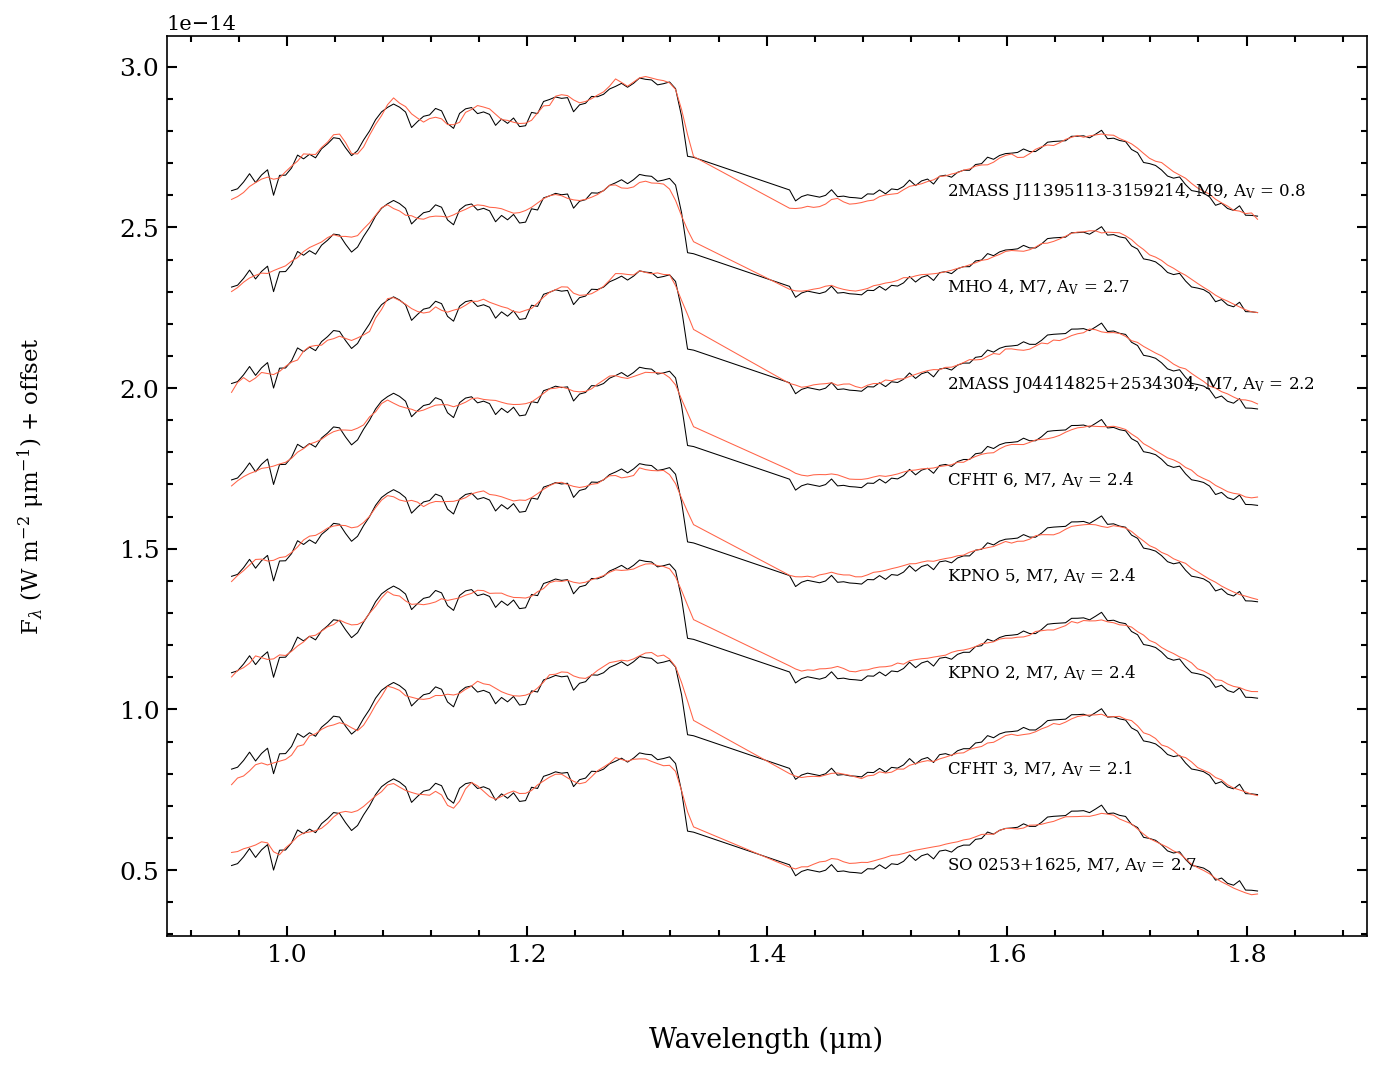

In [8]:
fs.compare_empirical_library('spex', spec_length='short', wavel_range=(0.9,1.9),
                sptypes=['M'],av_range =np.arange(0,5, 0.1),
                xlim = (0.9, 1.9), ylim=None, 
                flux_offset= 3e-15, label_position = (1.55, 0.5e-14))


--------------------
Add spectral library
--------------------

Database tag: bonnefoy+2014
Spectral types: ['M']



0.00B [00:00, ?B/s]     
SHA256 hash of downloaded file: dc167e8bd2c01454bbccfeb674242a9b9e181e0b55ae0c502f3538b95037e8cd
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.



Unpacking spectra of young M/L type objects from Bonnefoy et al. 2014 (2.3 MB)... [DONE]

Adding spectra... [DONE]    
Processing spectra... [DONE]    
Best-fitting spectra:
    1. G = 1.64e+03 -> 2M1207A, M8, A_V = 2.10, RV = 0 km/s,
                       scalings = [67969374.41982022]
    2. G = 2.01e+03 -> USco 108 B, M7, A_V = 0.70, RV = 0 km/s,
                       scalings = [1.20445913e+09]
    3. G = 2.04e+03 -> DH Tau B, M9, A_V = 0.00, RV = 0 km/s,
                       scalings = [4.95424589e+08]
    4. G = 3.09e+03 -> OTS 44, M9.5, A_V = 0.00, RV = 0 km/s,
                       scalings = [8.55714554e+08]
    5. G = 3.40e+03 -> KPNO Tau 4, M9.5, A_V = 0.00, RV = 0 km/s,
                       scalings = [2.30476203e+08]
    6. G = 5.49e+03 -> Cha1109, M9, A_V = 0.00, RV = 0 km/s,
                       scalings = [2.07411869e+09]
    7. G = 1.05e+04 -> TWA 5B, M8.5, A_V = 0.00, RV = 0 km/s,
                       scalings = [7.00770274e-15]
    8. G = 1.13e+04 -> CT C

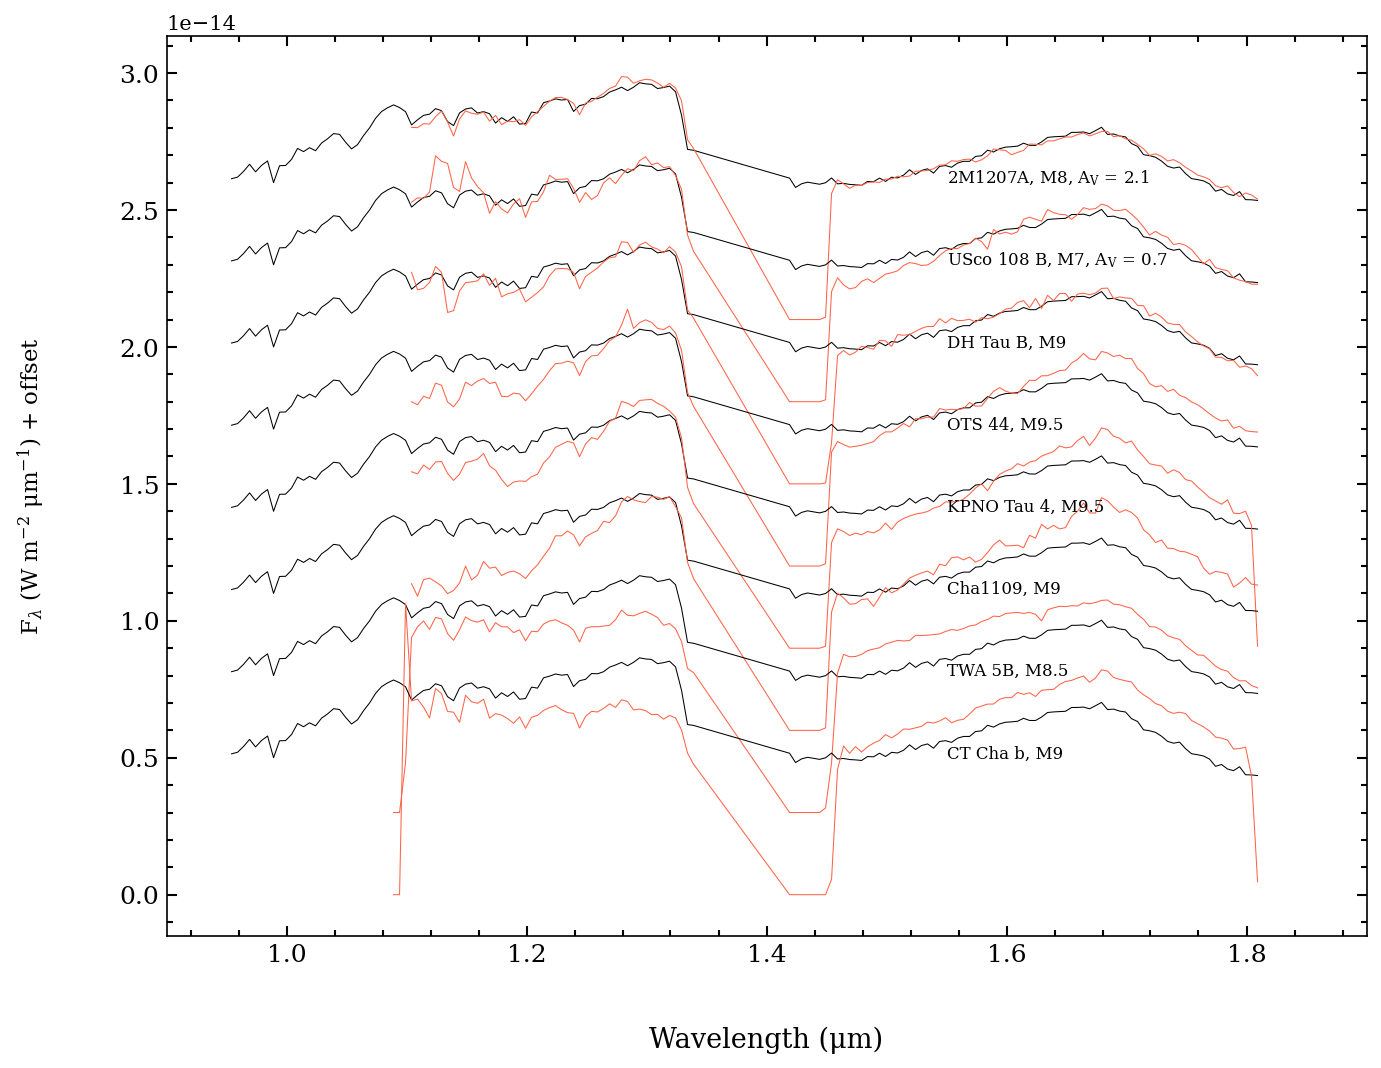

In [9]:
fs.compare_empirical_library('bonnefoy+2014', spec_length='short', wavel_range=(0.9,1.9),
                sptypes=['M'],av_range =np.arange(0,5, 0.1),
                xlim = (0.9, 1.9), ylim=None, 
                flux_offset= 3e-15, label_position = (1.55, 0.5e-14))

### Spectral Model Grid search

Next, we find the best fit theoretical model for our spectra using a grid search.  The model library was chosen when we initalized the class.  We again chose which part of the spectra to fit the models to: ```spec_length = 'short'``` and ```wavel_range=(0.9,1.9)```.  We can also select which temperature range we want to look through, the range of Av to test against.  Finally, we have optional kwargs for plotting.  The label position refers to the position of the bottom most label in the figure. 


-------------------------
Add grid of model spectra
-------------------------

Database tag: bt-settl-cifist
Model name: BT-Settl CIFIST



100%|████████████████████████████████████████| 463M/463M [00:00<00:00, 692GB/s]



Unpacking 53/353 model spectra from BT-Settl CIFIST (442 MB)... [DONE]

Wavelength range (um) = 0.9 - 1.9
Sampling (lambda/d_lambda) = 10000
Teff range (K) = 2100.0 - 2900.0

Adding BT-Settl CIFIST model spectra... data/bt-settl-cifist/bt-settl-cifist_teff_2900_logg_5.5_spec.npy

Grid points stored in the database:
   - Teff = [2100. 2200. 2300. 2400. 2500. 2600. 2700. 2800. 2900.]
   - log(g) = [3.  3.5 4.  4.5 5.  5.5]

Number of grid points per parameter:
   - teff: 9
   - logg: 6

Fix missing grid points with a linear interpolation:
   - teff = 2700.0, logg = 4.0

Number of stored grid points: 54
Number of interpolated grid points: 1
Number of missing grid points: 0
Processing model spectrum 450/450... [DONE]
Best-fit parameters:
   - Goodness-of-fit = 1.03e+02
   - teff = 2700.0
   - logg = 4.0
   - ism_ext = 2.3000000000000003
   - Radius (Rjup) = 6.09
   - Scaling = 5.72e-21
Plotting model spectra comparison: 2MASS J11011926-7732383_btsettlcifistgrid_comparison... [DONE]


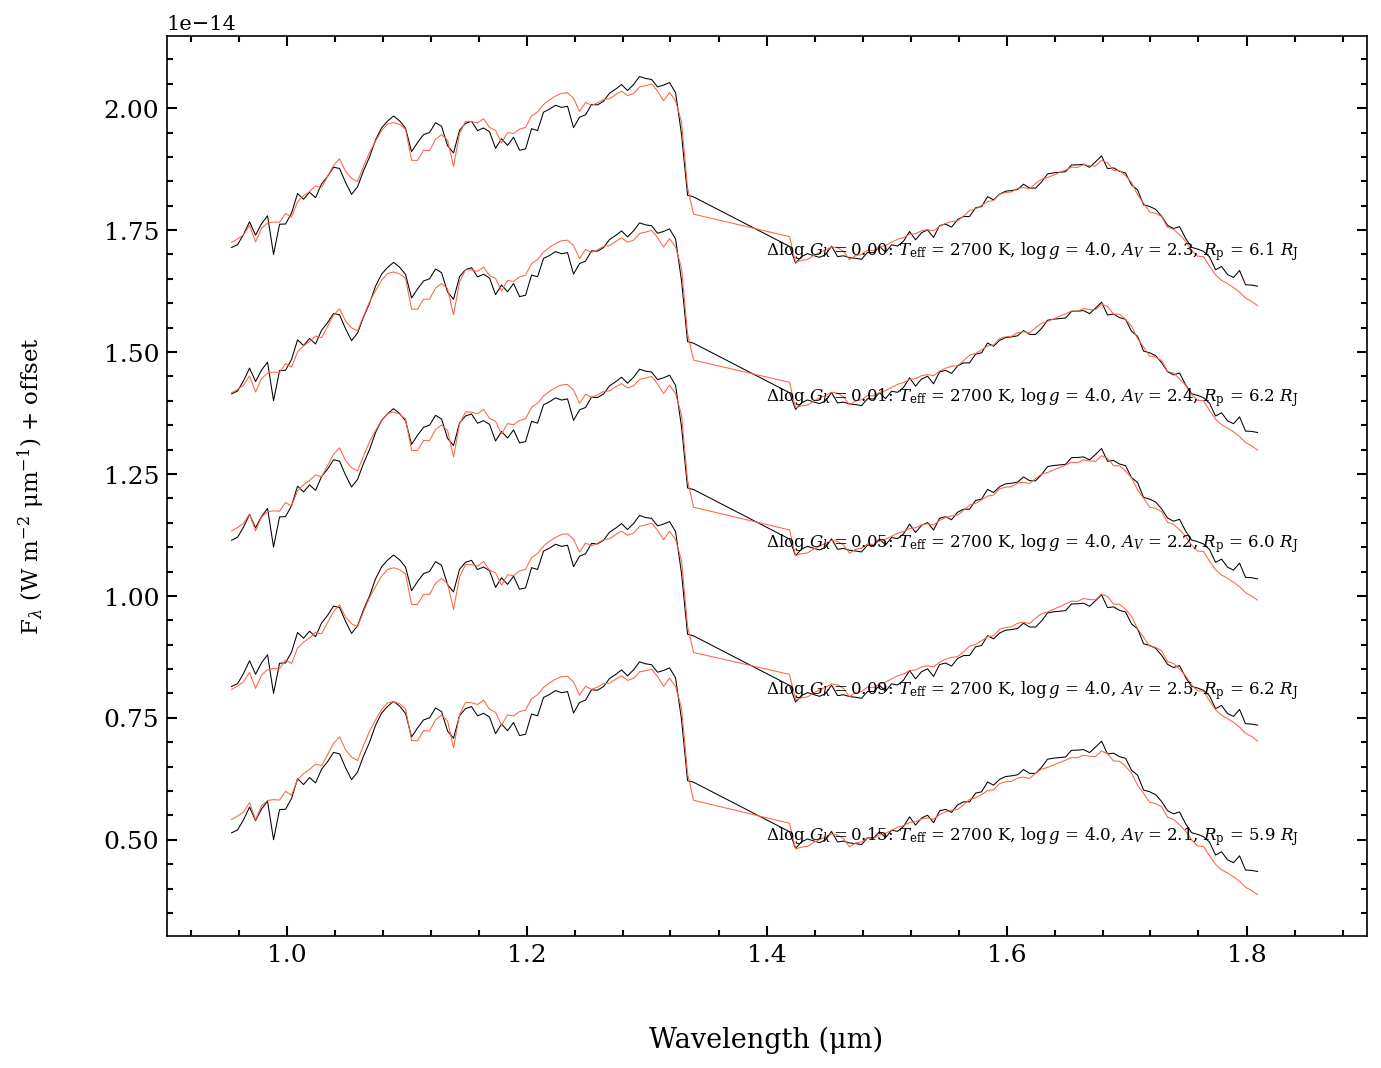

In [10]:
fs.compare_model(spec_length='short', wavel_range=(0.9, 1.9),
              teff_range=(2100., 2900.), av_range=np.arange(0,5,0.1), 
              xlim = (0.9, 1.9), ylim=None, 
              flux_offset= 3e-15, label_position = (1.4, 0.5e-14))

## Model fitting using multinest MCMC

Now we get to the main portion of ```fitspec``` -- the mcmc fitting to the theoretical spectra.  Here, we are using ```species``` multinest fitting.  

We first determine the free paramters and bounds (see ```species``` for which parameters are available.  By using the same value for the beginning and end, the value is held constant.  We again use the short ```spec_length``` as we do not want any excess emission at 2.4 μm to effect the Av estimate.  

The more ```n_live_points``` chosen, the better the fit.  We estimate ~2000 is good for a well populated parameter space.  The ```teff_range``` is the range of temperature range of models and must be equal to or larger than the bounds ```teff```.  In this example we use 100 for computational speed.

In [11]:
bounds = {'teff': (2200,3400),
          'radius': (1, 15),
          'ext_av':(0, 5), 
          'logg':(4.0, 4.0)}
fs.mcmc_fitting(bounds, spec_length='short', n_live_points=100, teff_range=(2100., 3600.))


-------------------------
Add grid of model spectra
-------------------------

Database tag: bt-settl-cifist
Model name: BT-Settl CIFIST

Unpacking 95/353 model spectra from BT-Settl CIFIST (442 MB)... [DONE]

Wavelength range (um) = 0.1 - 5000
Sampling (lambda/d_lambda) = 10000
Teff range (K) = 2100.0 - 3600.0

Adding BT-Settl CIFIST model spectra... data/bt-settl-cifist/bt-settl-cifist_teff_3600_logg_5.5_spec.npy

Grid points stored in the database:
   - Teff = [2100. 2200. 2300. 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200.
 3300. 3400. 3500. 3600.]
   - log(g) = [3.  3.5 4.  4.5 5.  5.5]

Number of grid points per parameter:
   - teff: 16
   - logg: 6

Fix missing grid points with a linear interpolation:
   - teff = 2700.0, logg = 4.0

Number of stored grid points: 96
Number of interpolated grid points: 1
Number of missing grid points: 0

-----------------
Fit model spectra
-----------------

Object name: 2MASS J11011926-7732383
Model tag: bt-settl-cifist
Binary star: Fals

After fitting, we can plot the posterior


---------------------
Get posterior samples
---------------------

Database tag: 2MASS J11011926-7732383
Random samples: None
Samples shape: (399, 5)

Parameters:
   - teff
   - radius
   - parallax
   - ext_av
   - logg

Uniform priors (min, max):
   - ext_av = (0, 5)
   - radius = (1, 15)
   - teff = (2200, 3400)

Normal priors (mean, sigma):
   - parallax = (5.36, 0.15)

----------------------------
Plot posterior distributions
----------------------------

Database tag: 2MASS J11011926-7732383
Object type: planet
Manual parameters: None

Model type: atmosphere
Model name: bt-settl-cifist
Sampler: multinest

Median parameters:
   - teff = 2682.71
   - radius = 6.17
   - parallax = 5.36
   - ext_av = 2.32
   - logg = 4.00

Sample with the maximum likelihood:
   - teff = 2680.51
   - radius = 6.14
   - parallax = 5.39
   - ext_av = 2.32
   - logg = 4.00

Parameters included in corner plot:
   - teff
   - radius
   - parallax
   - ext_av
   - logg
   - log_lum_atm

Output: 2MASS J1101

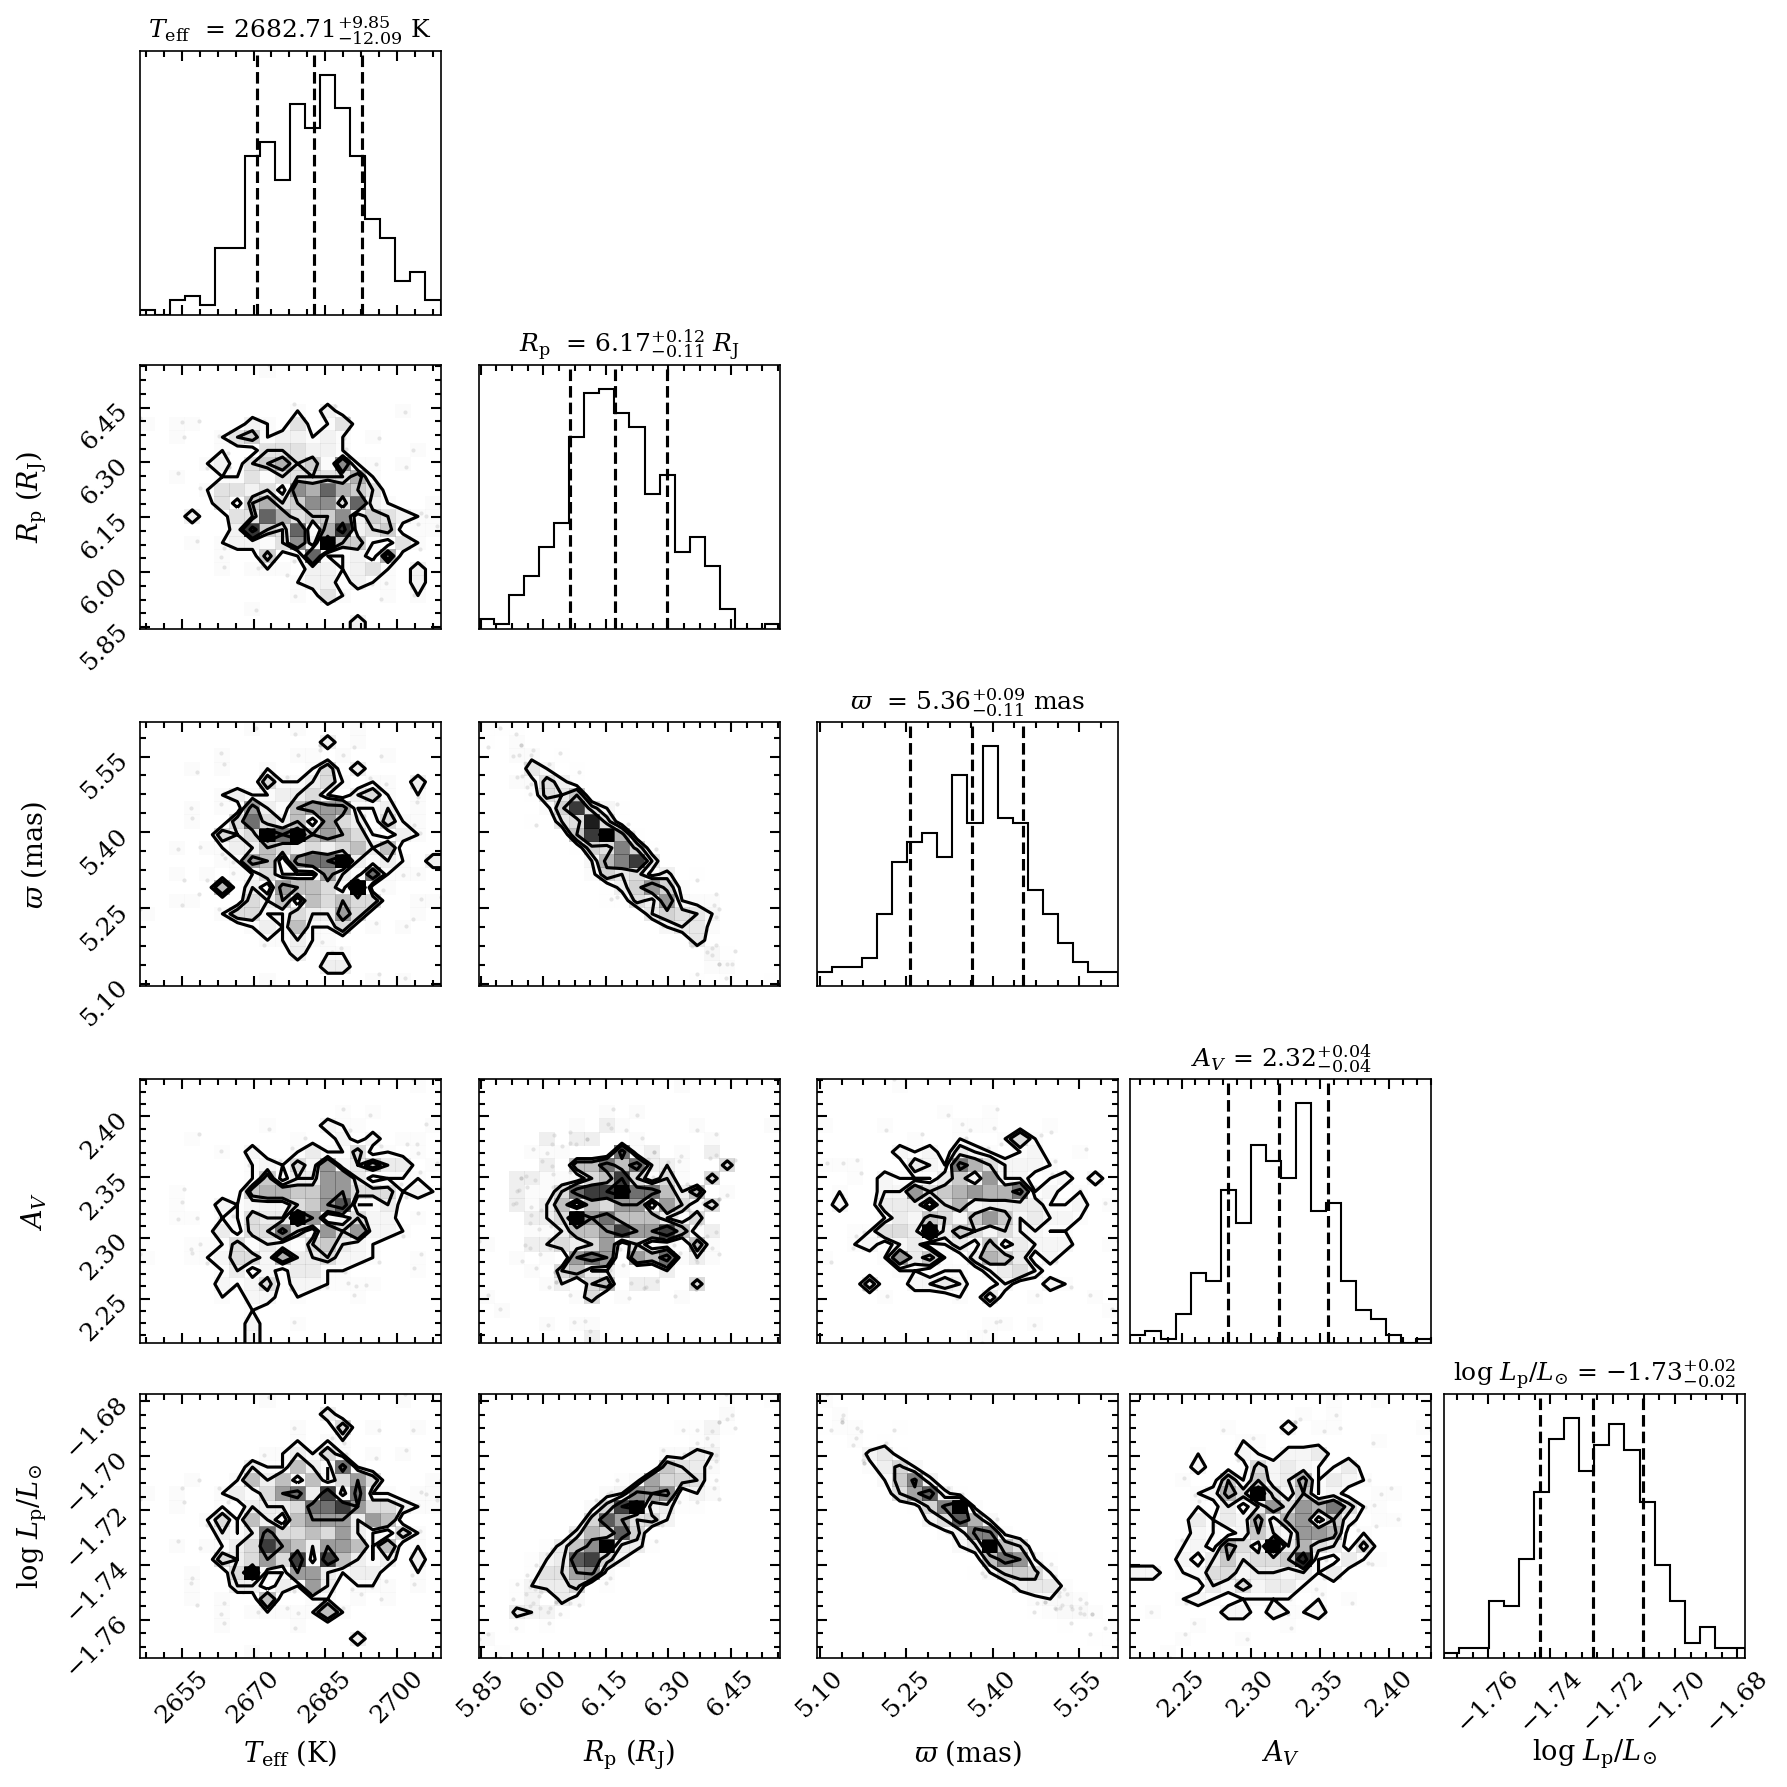

In [12]:
fs.posterior()

Next, we pull out all the posterior samples, the best fit samples (and luminosity), the best fit paramters, and the best fit spectra and residuals.

In [13]:
allsamples, best_parameters, best_model_spec, object_spec, residuals  = fs.all_samples(spec_length='full')
bestsamples = fs.bestfit_samples()


---------------------
Get posterior spectra
---------------------

Database tag: 2MASS J11011926-7732383
Wavelength range (um): None
Resolution: 500.0
Number of samples: 30



  0%|          | 0/30 [00:00<?, ?it/s]


---------------------
Get median parameters
---------------------

Database tag: 2MASS J11011926-7732383

Parameters:
   - teff = 2682.71
   - radius = 6.17
   - parallax = 5.36
   - ext_av = 2.32
   - logg = 4.00

----------
Get object
----------

Object name: 2MASS J11011926-7732383
Include photometry: False
Include spectra: ['2MASS J11011926-7732383_full']

----------------
Update ObjectBox
----------------


-------------------
Calculate residuals
-------------------

Database tag: 2MASS J11011926-7732383
Results type: FitModel
Model: bt-settl-cifist
Binary: False

Model parameters:
   - teff
   - radius
   - parallax
   - ext_av
   - logg

Fixed parameters:
   - logg

Include photometry: False
Include spectra: True

Residuals (sigma):
   - 2MASS J11011926-7732383_full: min = -2.32, max = 3.26

Number of data points = 264
Number of model parameters = 5
Number of fixed parameters = 1
Number of degrees of freedom = 260

chi2 = 232.66
reduced chi2 = 0.89

---------------------
Get po

Now we can plot the best fit model with residuals as well as a nicer "publication" version. We use the full length spectra for the plotting.


-------------
Plot spectrum
-------------

Boxes:
   - List with 30 x ModelBox
   - ModelBox
   - ObjectBox

Object type: planet
Quantity: flux density
Units: ('um', 'W m-2 um-1')
Filter profiles: None

Figure size: (8.0, 4.0)
Legend parameters: None
Include model name: False
Font sizes: {'xlabel': 11.0, 'ylabel': 11.0, 'title': 13.0, 'legend': 9.0}

Output: 2MASS J11011926-7732383_mcmc_bestfit
{'2MASS J11011926-7732383_full': array([[ 9.54210763e-01, -1.34290492e-01],
       [ 9.59210763e-01, -1.27755278e-01],
       [ 9.64210763e-01,  4.30738568e-01],
       [ 9.69210763e-01,  4.60570104e-01],
       [ 9.74210763e-01,  9.47392692e-01],
       [ 9.79210763e-01,  6.30942782e-01],
       [ 9.84210763e-01,  1.14956809e+00],
       [ 9.89210763e-01, -1.42998739e+00],
       [ 9.94210763e-01,  2.63193912e-02],
       [ 9.99210763e-01, -6.69843176e-01],
       [ 1.00421076e+00,  4.08340650e-01],
       [ 1.00921076e+00,  7.34939443e-01],
       [ 1.01421076e+00, -1.44755956e-01],
       [ 

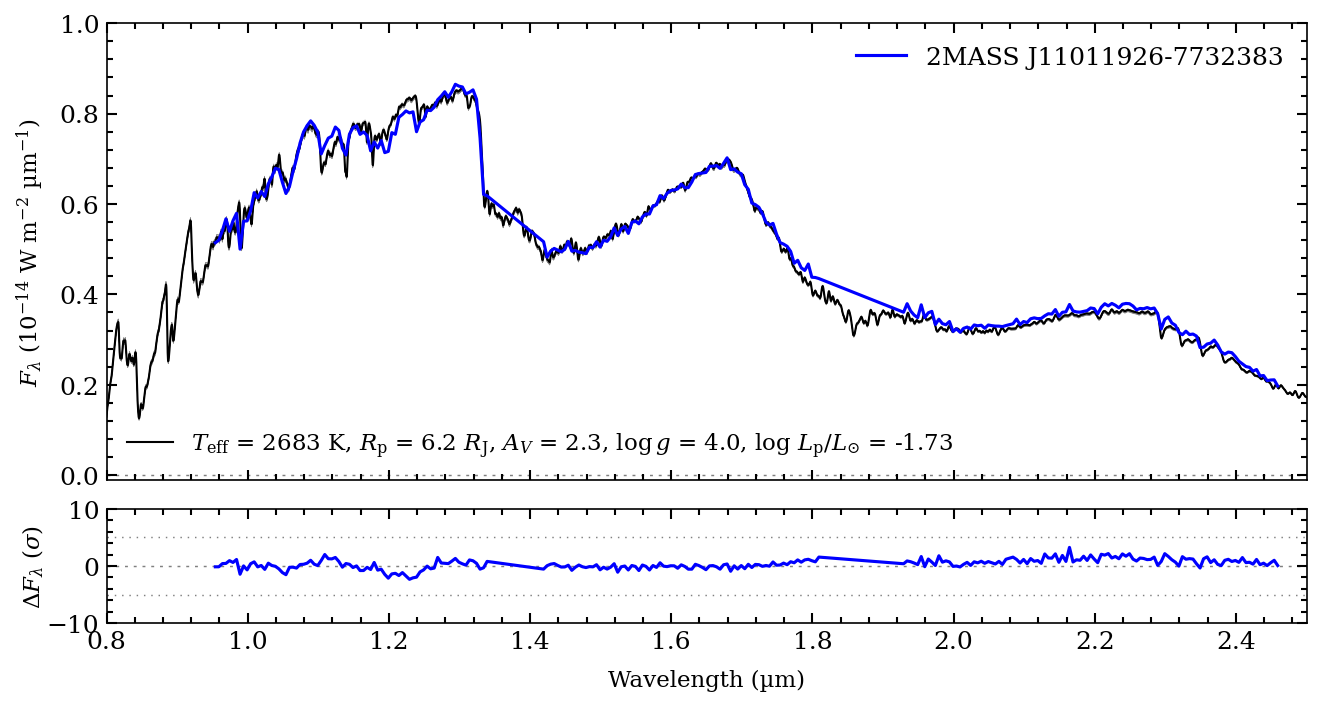

In [14]:
cont_residuals = fs.plot_bestmodel_residual(spec_length='full', 
              xlim=(0.8, 2.5), ylim=(-1.15e-16, 1e-14), label=OBJ_NAME)

2.4592107629776017
0
1


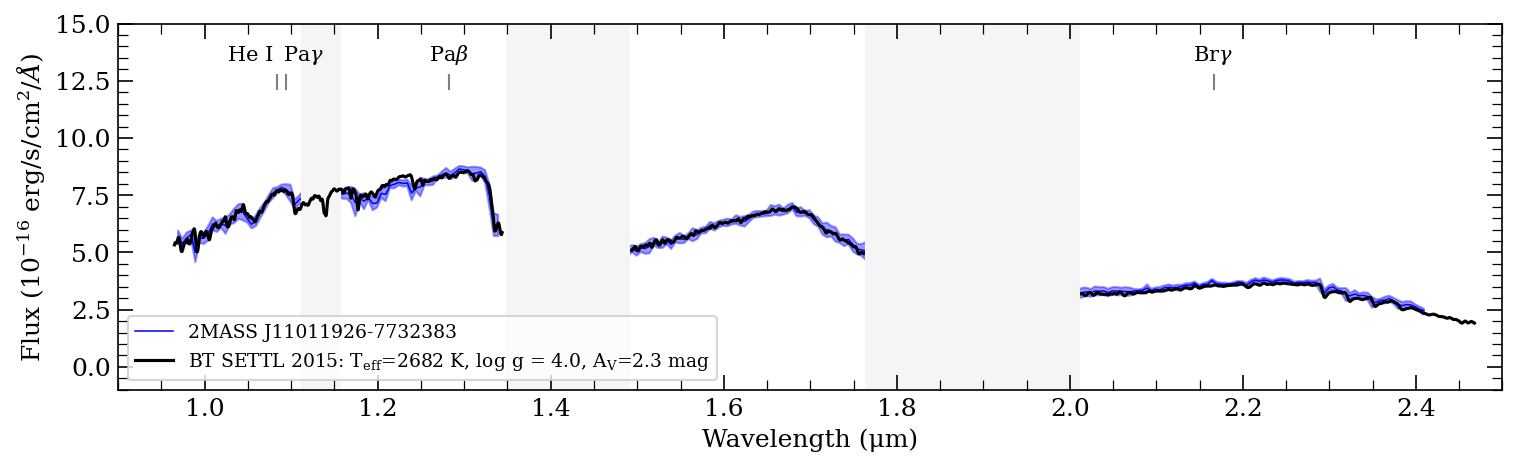

In [15]:
fs.plot_bestmodel(object_spec, best_model_spec, spec_length='full', 
                  wave_unit='um', flux_unit='W/m2/um',
                  xlim=(0.9, 2.5), ylim=(-1, 15), normalize_value = 1e-16, fontsize=12,
                  label=OBJ_NAME, figsize=(10,4), plot_waterbands=True, plot_HI=True)

## Compute the Errors on the Parameters. 
```species``` MCMC errors are often underestimated and statistical.  Therefore, we want more robust errors that take into account the grid spacing.  We follow the method of Andrews+2013 (see their Fig.15).  

We know from our grid, the temperature is only known to +/- 100 K.  Therefore, using our best fit Temperature, we determine the best fit parameters when Teff+100 and Teff-100.  Then, the errors on each parameter is the distance from the best fit value to the furthest 68% percentile.  

In [16]:
bounds = {'teff': (2200,3400),
          'radius': (1, 15),
          'ext_av':(0, 5), 
          'logg':(4.0, 4.0)}
plus_samples, plus_vals, minus_samples, minus_vals = fs.compute_errors(bounds, spec_length='short', 
               Teff=None, teff_range=(2100., 3600.), n_live_points=100)


-------------------------
Add grid of model spectra
-------------------------

Database tag: bt-settl-cifist
Model name: BT-Settl CIFIST

Unpacking 95/353 model spectra from BT-Settl CIFIST (442 MB)... [DONE]

Wavelength range (um) = 0.1 - 5000
Sampling (lambda/d_lambda) = 10000
Teff range (K) = 2100.0 - 3600.0

Adding BT-Settl CIFIST model spectra... data/bt-settl-cifist/bt-settl-cifist_teff_3600_logg_5.5_spec.npy

Grid points stored in the database:
   - Teff = [2100. 2200. 2300. 2400. 2500. 2600. 2700. 2800. 2900. 3000. 3100. 3200.
 3300. 3400. 3500. 3600.]
   - log(g) = [3.  3.5 4.  4.5 5.  5.5]

Number of grid points per parameter:
   - teff: 16
   - logg: 6

Fix missing grid points with a linear interpolation:
   - teff = 2700.0, logg = 4.0

Number of stored grid points: 96
Number of interpolated grid points: 1
Number of missing grid points: 0
{'teff': (2200, 3400), 'radius': (1, 15), 'ext_av': (0, 5), 'logg': (4.0, 4.0)}
>>> changing bound["teff"] from (2200, 3400) to (2782.710

best fit Teff =  2682.7108823912167


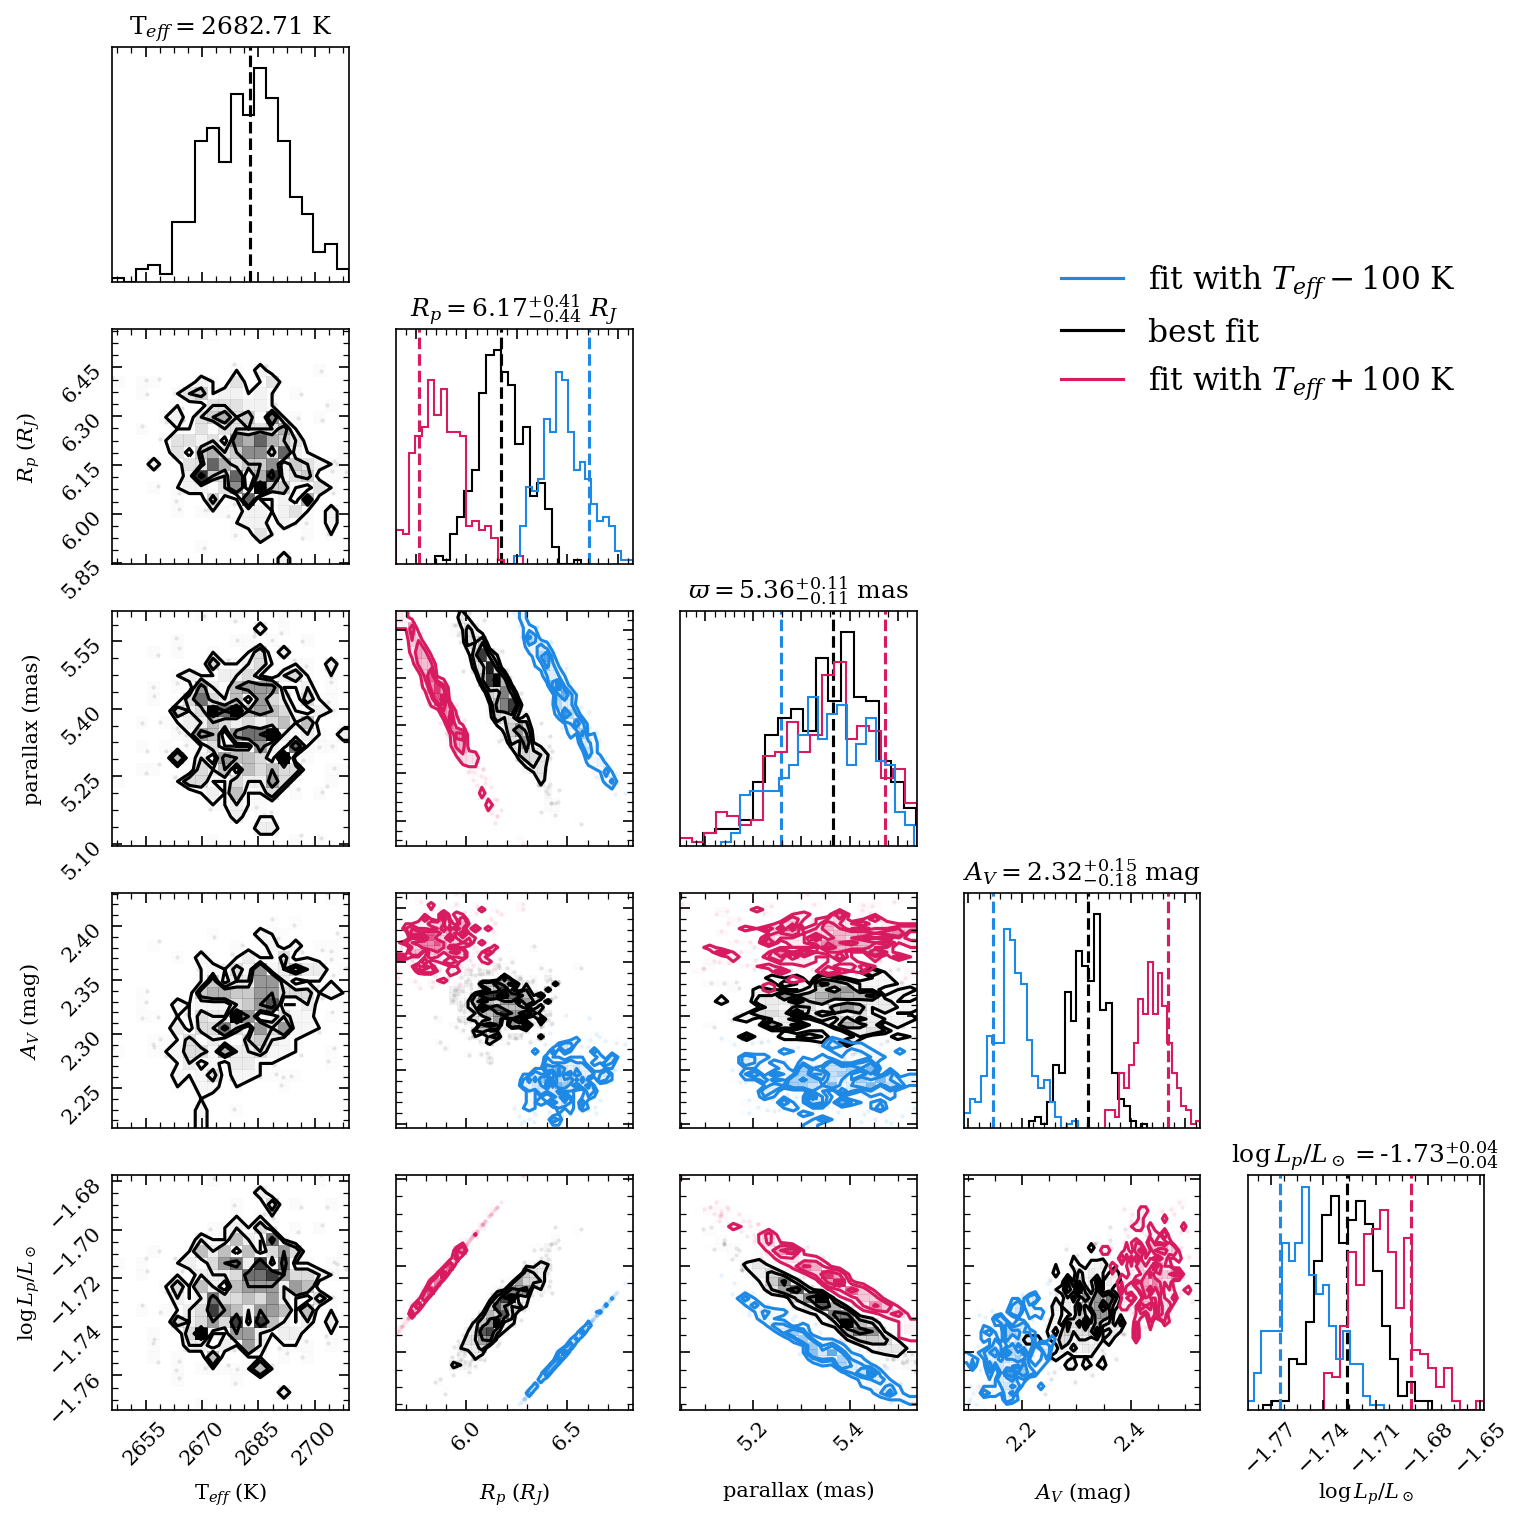

In [17]:
fs.plot_error_corner(plus_samples, plus_vals, minus_samples, minus_vals)

## Finally, we save our best fit model and best fit parameters 

In [18]:
fs.save_bestfit_model()
fs.save_bestfit_parameters(plus_vals, minus_vals)


---------------------
Get median parameters
---------------------

Database tag: 2MASS J11011926-7732383

Parameters:
   - radius = 6.48
   - parallax = 5.36
   - ext_av = 2.18
   - teff = 2582.71
   - logg = 4.00
saving best fit model to:  2MASS J11011926-7732383_BTSettl_bestfit_spectra_T2582_logg4.0_Av2.2.txt
save best fit parameters to:  2MASS J11011926-7732383_BTSettle_bestfit_parameters.csv
